## Check List 7.1. Demo - White board sweeping
* In this demo file, we will use two robots (Indy7, Panda) to sweep a white board, removing obstacles

* You need trained model to use ReachChecker
  - model/reach_svm/indy7.json
  - model/reach_svm/panda.json
  - 백업: 개인 이동식 하드디스크, 강준수

### Prepare the task scene
* Prepare Indy7 and panda, and install sweeping tool to indy. (Check release/Figs/7.1.WhiteBoardSweeping.jpg)
* Prepare "floor", "track", "box1", "box2" objects as defined in pkg.detector.aruco.marker_config.py
* The robots and "track" are installed on "floor".
* "box1" and "box2" are on "track"
<img src="../Figs/7.1.WhiteBoardSweeping.jpg" width="80%">

## set running directory to project source

In [1]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
from pkg.utils.code_scraps import add_indy_sweep_tool, use_current_place_point_only, use_current_sub_binders_only, finish_L_shape, set_l_shape_object, ModeSwitcher

## init combined robot config

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0.3,-0.4,0), (0,0,np.pi/2)),
                INDY_IP),
    RobotConfig(1, RobotType.panda, ((-0.3,-0.4,0), (0,0,np.pi/2)),
                "{}/{}".format(PANDA_REPEATER_IP, PANDA_ROBOT_IP))]
              , connection_list=[False, False])

connection command:
indy0: False
panda1: False


In [3]:
from pkg.detector.aruco.marker_config import *
from pkg.detector.aruco.stereo import ArucoStereo
from pkg.detector.camera.realsense import RealSense
from pkg.detector.camera.kinect import Kinect
aruco_map = get_aruco_map()
stereo = ArucoStereo(aruco_map, [Kinect(), RealSense()])
stereo.initialize()
stereo.calibrate()

Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.


Start streaming


[(array([[1.82983423e+03, 0.00000000e+00, 1.91572046e+03],
         [0.00000000e+00, 1.82983423e+03, 1.09876086e+03],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  array([ 7.09966481e-01, -2.73409390e+00,  1.45804870e-03, -3.24774766e-04,
          1.44911301e+00,  5.84310412e-01, -2.56374550e+00,  1.38472950e+00])),
 (array([[1.39560388e+03, 0.00000000e+00, 9.62751587e+02],
         [0.00000000e+00, 1.39531934e+03, 5.47687012e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  array([0., 0., 0., 0., 0.])),
 array([[ 0.82722926, -0.02408086, -0.56134826,  0.6478475 ],
        [ 0.16690272,  0.96451575,  0.20457968, -0.15224595],
        [ 0.5365028 , -0.26292485,  0.8018948 ,  0.08928686],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32)]

## create scene builder

In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(stereo)
s_builder.reset_reference_coord(ref_name="floor")

## detect robot and make geometry scene

In [5]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
# save_pickle("xyz_rpy_robots.pkl", xyz_rpy_robots)
xyz_rpy_robots = load_pickle("xyz_rpy_robots.pkl")
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## init planning pipeline

In [6]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


```
open web ui on <your ip>:8050
click geometry items / Handles / Binders to highlight geometry on RVIZ
other functions may be buggy.. please report
```

## add environment

In [7]:
# gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.ENVIRONMENT])

 * Environment: production
   Use a production WSGI server instead.


In [8]:
self=s_builder
item_names=None
level_mask=[DetectionLevel.ENVIRONMENT]
color=(0.6,0.6,0.6,1)
collision=True
gscene=gscene
visualize=False
    
# xyz_rpy_dict = self.detect_items(item_names=item_names, level_mask=level_mask, visualize=visualize)
# save_pickle("env_dict.pkl", xyz_rpy_dict)
xyz_rpy_dict = load_pickle("env_dict.pkl")
gtem_dict = {}
for ename, xyzrpy in xyz_rpy_dict.items():
    kwargs = dict(name=ename, center=xyzrpy[0], rpy=xyzrpy[1], color=color,
                  link_name=self.base_link, collision=collision)
    kwargs.update(self.detector.get_geometry_kwargs(ename))
    gtem_dict[ename] = gscene.create_safe(**kwargs)

 * Debug mode: off
Please create a subscriber to the marker


In [9]:
# add cam poles
ptems = s_builder.add_poles({"cam0": s_builder.ref_coord_inv[:3,3], "cam1":np.matmul(s_builder.ref_coord_inv, stereo.T_c12)[:3,3]},
                            color=(0.6,0.6,0.6,0.0))
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.NAME_DICT["floor"].dims = (2,1,0.01)
gscene.set_workspace_boundary( -1, 1, -0.5, 0.5, -0.1, 1.05)

## add indy tool

In [10]:
add_indy_sweep_tool(gscene, "indy0", face_name="brush_face")

## add sweep face

In [11]:
# track = s_builder.detect_and_register(item_names=["track"], level_mask=[DetectionLevel.ENVIRONMENT])["track"]

In [12]:
track = gtem_dict["track"]

In [13]:
track_face = gscene.copy_from(track, new_name="track_face", collision=False)
track_face.dims = (track.dims[0]-0.22, track.dims[1]-0.12, track.dims[2])
# track.dims = (track.dims[0]-0.32, track.dims[1]-0.12, track.dims[2])

In [14]:
gscene.update_markers_all()

## add wp

In [ ]:
TOOL_DIM = [0.06, 0.10]
TACK_WIDTH = 0.17
TRACK_DIM = track_face.dims
TRACK_NUM = np.ceil(np.divide(TRACK_DIM[1]-TOOL_DIM[1], TOOL_DIM[1])).astype(np.int)+1
TRACK_STEP = (TRACK_DIM[1]-TOOL_DIM[1])/(TRACK_NUM-1)
WP_REF_A = -np.subtract(TRACK_DIM[:2], TOOL_DIM[:2])/2
WP_REF_B = np.array([-WP_REF_A[0], WP_REF_A[1]])
WP_REF_M = np.array([0, WP_REF_A[1]])
TRC_THIC = TRACK_DIM[2]
track_list = []
for i_trc in range(TRACK_NUM):
    wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             tuple(WP_REF_A+[0,TRACK_STEP*i_trc])+(0,),rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    wp2 = gscene.create_safe(GEOTYPE.BOX, "wp{}b".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             tuple(WP_REF_B+[0,TRACK_STEP*i_trc])+(0,),rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    face = gscene.create_safe(GEOTYPE.BOX, "face{}".format(i_trc+1), "base_link", 
                              (TRACK_DIM[0] - TOOL_DIM[0]/2,TACK_WIDTH,TRC_THIC), 
                             center=tuple(WP_REF_M+[0,TRACK_STEP*i_trc])+(1e-2,),rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    track_list.append((wp1, wp2, face))

In [ ]:
gscene.update_markers_all()

## add blocking structure on table

In [ ]:
# gscene.create_safe(gtype=GEOTYPE.BOX, name="blocker", link_name="base_link",
#                             center=(-0.27,-0.2,0.15), dims=(0.1,0.3, 0.4), rpy=(0,0,0), color=(0.0,0.8,0.0,0.5),
#                             collision=True, fixed=True)

## add box

In [ ]:
# gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

In [ ]:
self=s_builder
item_names=None
level_mask=[DetectionLevel.MOVABLE]
color=(0.6,0.6,0.6,1)
collision=True
gscene=gscene
visualize=False
    
# xyz_rpy_dict = self.detect_items(item_names=item_names, level_mask=level_mask, visualize=visualize)
# save_pickle("obj_dict.pkl", xyz_rpy_dict)
xyz_rpy_dict = load_pickle("obj_dict.pkl")
gtem_dict = {}
for ename, xyzrpy in xyz_rpy_dict.items():
    kwargs = dict(name=ename, center=xyzrpy[0], rpy=xyzrpy[1], color=color,
                  link_name=self.base_link, collision=collision)
    kwargs.update(self.detector.get_geometry_kwargs(ename))
    gtem_dict[ename] = gscene.create_safe(**kwargs)

In [ ]:
gscene.update_markers_all()

## Register binders

In [ ]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot

In [ ]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip1", link_name="panda1_hand", 
                 dims=(0.01,)*3, center=(0,0,0.112), rpy=(-np.pi/2,0,0), color=(1,0,0,1), display=True, collision=False, fixed=True)

pscene.create_binder(bname="grip1", gname="grip1", _type=Gripper2Tool, point=(0,0,0), rpy=(0,0,0))
pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepFramer, point=(0,0,gscene.NAME_DICT['brush_face'].dims[2]/2), 
                     rpy=(0,np.pi,0))
pscene.create_binder(bname="track_face", gname="track_face", _type=PlacePlane)

## add objects

In [ ]:
from pkg.planning.constraint.constraint_subject import \
        CustomObject, Grasp2Point, PlacePoint, SweepFrame, SweepTask, BoxObject, FixturePoint, AbstractObject

In [ ]:
for gname in sorted(gtem_dict.keys()):
    pscene.create_subject(oname=gname, gname=gname, _type=BoxObject, hexahedral=True)
# box3= pscene.create_subject(oname="box3", gname="box3", _type=BoxObject, hexahedral=True)

In [ ]:
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask
from pkg.planning.constraint.constraint_subject import SweepLineTask

In [ ]:
sweep_list = []
for i_t, track_tem in enumerate(track_list):
    wp1, wp2, face = track_tem
    sweep_ = pscene.create_subject(oname="sweep{}".format(i_t+1), gname="track_face", _type=SweepLineTask, 
                                   action_points_dict = {wp1.name: SweepFrame(wp1.name, wp1, [0,0,0.005], [0,0,0]),
                                                       wp2.name: SweepFrame(wp2.name, wp2, [0,0,0.005], [0,0,0])}, 
                                   clearance=[face])
    sweep_list.append(sweep_)

### planners

In [ ]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

## motion filters

In [ ]:
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
from pkg.planning.filtering.task_clearance_filter import TaskClearanceChecker

gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)
# checkers_all = [rcheck, gcheck]
tcheck = TaskClearanceChecker(pscene, gcheck)
checkers_all = [tcheck, rcheck, gcheck]
# lcheck = LatticedChecker(pscene, gcheck)
# checkers_all.append(lcheck)

In [ ]:
mplan.motion_filters = checkers_all

In [ ]:
gscene.show_pose(crob.home_pose)

## Set initial condition

In [ ]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy
gtimer = GlobalTimer.instance()
initial_state = pscene.initialize_state(crob.home_pose)
print(initial_state.node)

# remove place points except for the current one
use_current_place_point_only(pscene, initial_state)

In [ ]:
pscene.subject_name_list

# Node Sampler

In [ ]:
# from pkg.planning.sampling.node_sampling import make_state_param_hashable, UniformNodeSampler, PenaltyNodeSampler, GrowingSampler

# tplan.new_node_sampler = PenaltyNodeSampler(3, 1)
# tplan.parent_node_sampler = UniformNodeSampler(3)
# # tplan.parent_snode_sampler = GrowingSampler(3)

# CustomRule

In [ ]:
# from pkg.planning.task.custom_rules.sweep_entrance_control import SweepEntranceControlRule
# tplan.custom_rule = SweepEntranceControlRule(pscene)

In [ ]:
# from copy import deepcopy
# from ....utils.utils import *
# from ...constraint.constraint_subject import AbstractObject, SweepLineTask, SubjectType
from pkg.planning.task.custom_rules.interface import CustomRuleInterface


##
# @class SweepEntranceControlRule
# @brief Strictly control entrance to sweep tasks, as they are fully defined and no need to be sampled multiple times
class SweepEntranceControlRule(CustomRuleInterface):
    def __init__(self, pscene):
        self.pscene = pscene
        self.chain_dict = pscene.robot_chain_dict
        self.NUM_WP_TRIALS = 1
        self.refoliate_flag = True

    def init(self, tplan, multiprocess_manager):
        self.multiprocess_manager = multiprocess_manager

        no_enter_sidxes = [stype == SweepLineTask for stype in enumerate(self.pscene.subject_type_list)]
        no_enter_initials = [tplan.initial_state.node[sidx] for sidx in no_enter_sidxes]
        self.sorted_unstop_keys = sorted(tplan.unstoppable_terminals.keys())

        self.node_dict = {}
        self.enter_dict = {}
        for node, leafs in tplan.node_dict.items():
            self.node_dict[node] = deepcopy(leafs)
            if not all([node[k] in terms for k, terms in tplan.unstoppable_terminals.items()]):
                tplan.node_dict[node] = set([])  ## unstoppable node change will be reserved by this custom rule
            else:
                # entering to unstoppable terminal is controlled by this rule
                self.enter_dict[node] = set([leaf for leaf in leafs
                                             if any(
                        [leaf[k] not in terms for k, terms in tplan.unstoppable_terminals.items()])
                                             and all(
                        [leaf[k] >= leaf[k + 1] for k in self.sorted_unstop_keys[:-1]])])  # the task is done in order
                tplan.node_dict[node] = set([leaf for leaf in leafs
                                             if
                                             all([leaf[k] in terms for k, terms in tplan.unstoppable_terminals.items()])
                                             ])

        self.node_parent_dict = {}
        for node, parents in tplan.node_parent_dict.items():
            self.node_parent_dict[node] = deepcopy(parents)
            tplan.node_parent_dict[node] = set(
                [parent for parent in parents  ## unstoppable node change will be reserved by this custom rule
                 if all([parent[k] in terms for k, terms in tplan.unstoppable_terminals.items()])])

    ##
    # @brief    re-foliate for some defined cases
    # @remark   case 1: meaningless homing - stayed on same node for two turns and do action of same kind \n
    #           case 2: already-moved object
    def refoliate(self, tplan, new_node, parent_sidx):
        if not self.refoliate_flag:
            return new_node, parent_sidx, False
        else:
            reject = False
            parent_snode = tplan.snode_dict[parent_sidx]
            parent_node = parent_snode.state.node
            anc_nodes = [tplan.snode_dict[pidx].state.node for pidx in parent_snode.parents]
            if new_node != parent_node:  # this is not homing motion
                # subject_gname_list = [obj.geometry.name for obj in self.pscene.subject_dict.values()
                #                       if obj.stype == SubjectType.OBJECT]
                active_binder_geo = [b for a, b in zip(parent_node, new_node) if a != b][0]
                if any([active_binder_geo in subject.geometry.get_family()
                        for subject in self.pscene.subject_dict.values() if isinstance(subject, AbstractObject)]):     # don't put on other object
                    reject = True
                    return new_node, parent_sidx, reject

                if len(anc_nodes) > 1 and anc_nodes[-1] == parent_node:  # previous motion was homing
                    if ([a for a, b in zip(anc_nodes[-2], parent_node) if a != b][0]
                            == [b for a, b in zip(parent_node, new_node) if a != b][0]):  # use same binder after homing
                        parent_sidx = parent_snode.parents[-1]
                        parent_snode = tplan.snode_dict[parent_sidx]
                        parent_node = parent_snode.state.node
                        anc_nodes = anc_nodes[:-1]
                if len(anc_nodes) > 0 and new_node in anc_nodes:  # already-moved object
                    active_binder_geo = [b for a, b in zip(parent_node, new_node) if a != b][0]
                    if ((active_binder_geo not in self.pscene.geometry_actor_dict)  # active binder is doing Task
                            or
                            (self.pscene.actor_robot_dict[self.pscene.geometry_actor_dict[active_binder_geo][0]]
                             is not None)  # active binder is controllable actor
                    ):
                        first_access_idx = anc_nodes.index(new_node)
                        if first_access_idx == 0:  # this is returning to initial state
                            reject = True
                        else:  # foliate from before first move of this object
                            parent_sidx = parent_snode.parents[first_access_idx - 1]
                            parent_snode = tplan.snode_dict[parent_sidx]
                            parent_node = parent_snode.state.node
                            anc_nodes = anc_nodes[:first_access_idx - 1]
            return new_node, parent_sidx, reject

    def __call__(self, tplan, snode_src, snode_new, connection_result):
        #         print("CustomRule call")
        stack_res = False
        stack_items = []
        if connection_result and snode_new.state.node in self.enter_dict:
            with tplan.snode_dict_lock:
                nb_nodes = list(tplan.neighbor_nodes.keys())
                for nb_node in nb_nodes:
                    for ukey in self.sorted_unstop_keys:
                        if nb_node[ukey] < snode_new.state.node[ukey]:
                            del tplan.neighbor_nodes[nb_node]
                            break  # task is done in order

        if connection_result and snode_new.state.node in self.enter_dict:
            stack_res, stack_items = True, list(self.enter_dict[snode_new.state.node])

        if snode_src is not None:

            node_src = snode_src.state.node
            node_new = snode_new.state.node
            diff_sidxes = np.where([ntem_s != ntem_g for ntem_s, ntem_g in zip(node_src, node_new)])[0]
            #             print("{}->{} , diff: {}".format(node_src, node_new, diff_sidxes))
            if len(diff_sidxes) == 0:
                return stack_res, stack_items
            diff_sidx = diff_sidxes[0]
            diff_sname = self.pscene.subject_name_list[diff_sidx]
            diff_subject = self.pscene.subject_dict[diff_sname]

            if isinstance(diff_subject, SweepLineTask): # Sweep entrance control rule
                #                 print("Rule for SweepLineTask")
                with tplan.snode_dict_lock:
                    if node_src[diff_sidx] not in tplan.unstoppable_terminals[diff_sidx]:
                        # from intermediate wp -> remove access to them
                        snode_list = tplan.node_snode_dict[node_src]
                        if snode_src.idx in snode_list:
                            # print("Removing {} from {}: {} not in {}".format(
                            #     snode_src.idx, snode_list,
                            #     node_src[diff_sidx], tplan.unstoppable_terminals[diff_sidx]))
                            # print(snode_list)
                            snode_list.remove(snode_src.idx)
                            tplan.node_snode_dict[node_src] = snode_list
                            print(tplan.node_snode_dict[node_src])
                        if len(snode_list) == 0 and node_new in tplan.neighbor_nodes:
                            del tplan.neighbor_nodes[node_new]
                    if connection_result:
                        if node_new[diff_sidx] in tplan.unstoppable_terminals[diff_sidx]:  ## in terminal condition
                            # print("Check home: {} in {}".format(
                            #     node_new[diff_sidx], tplan.unstoppable_terminals[diff_sidx]))
                            link_name = self.pscene.gscene.NAME_DICT[
                                snode_new.state.binding_state[diff_sidx][-1]].link_name
                            rname_candis = [rname for rname, chain_vals in self.chain_dict.items() if
                                            link_name in chain_vals['link_names']]
                            if len(rname_candis) == 0:
                                print("no robot candis")
                            else:
                                #                                 print("reserve homing = {}".format(snode_new.idx))
                                newstate = snode_new.state.copy(self.pscene)
                                jidxes = self.pscene.combined_robot.idx_dict[rname_candis[0]]
                                newstate.Q[jidxes] = self.pscene.combined_robot.home_pose[jidxes]
                                return True, [newstate] + stack_items
                        else:  ## not in terminal condition
                            # print("Reserve next wp from {}".format(snode_new.idx))
                            snode_list = tplan.node_snode_dict[node_new]
                            if snode_new.idx in snode_list:
                                # print("Removing {} from {} as next wp is reserved".format(snode_new.idx, snode_list))
                                snode_list.remove(snode_new.idx)
                                tplan.node_snode_dict[node_new] = snode_list
                            next_node_candis = list(self.node_dict[node_new])
                            assert len(
                                next_node_candis) == 1, "non-terminal sweep task should have only 1 leaf ({}) {}-{}".format(
                                diff_sidx, node_new, next_node_candis)
                            return True, next_node_candis * self.NUM_WP_TRIALS + stack_items
                return stack_res, stack_items

            if isinstance(diff_subject, AbstractObject):
                #                 print("Rule for AbstractObject")
                if connection_result:
                    link_name1 = snode_src.state.state_param[diff_sname][0]
                    link_name2 = snode_new.state.state_param[diff_sname][0]
                    rname_candis = [rname for rname, chain_vals in self.chain_dict.items() if
                                    link_name1 in chain_vals['link_names'] or link_name2 in chain_vals['link_names']]
                    if len(rname_candis) == 0:
                        print("no robot candis")
                        return stack_res, stack_items
                    else:
                        #                         print("try homing")
                        newstate = snode_new.state.copy(self.pscene)
                        jidxes = self.pscene.combined_robot.idx_dict[rname_candis[0]]
                        newstate.Q[jidxes] = self.pscene.combined_robot.home_pose[jidxes]
                        return True, [newstate] + stack_items
        return stack_res, stack_items

In [ ]:
tplan.custom_rule = SweepEntranceControlRule(pscene)

## Plan & show

In [ ]:
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType
from pkg.planning.constraint.constraint_common import get_binding_margins, fit_binding
from pkg.utils.traj_utils import simplify_schedule, mix_schedule
mplan.reset_log(False)
gtimer.reset()

In [ ]:
mplan.reset_log(False)
gtimer.reset()

with gtimer.block("detect"):
    for sname in pscene.subject_name_list:
        if isinstance(pscene.subject_dict[sname], AbstractObject):
            pscene.remove_subject(sname)
            
#     gscene.clear_non_fixed()
    
#     ## detect again
#     gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

    ## create boxes
    box_list =  [] 
    for gname in sorted(gtem_dict.keys()):
        with gtimer.block(gname):
            box_new = pscene.create_subject(oname=gname, gname=gname, _type=BoxObject, hexahedral=True)
            box_new.register_binders(pscene, PlacePlane)
            box_list.append(box_new)
            
initial_state = pscene.initialize_state(crob.home_pose, force_fit_binding=True)
gscene.update_markers_all()

# remove place points and sub-binders except for the current ones
use_current_place_point_only(pscene, initial_state)
use_current_sub_binders_only(pscene, initial_state)
tplan.prepare()
mplan.update_gscene()

In [ ]:
print(gtimer)

## w/o redundant motions

In [165]:
mplan.reset_log(False)
gtimer.reset()
tplan.custom_rule.refoliate_flag = True

# with gtimer.block("detect"):
#     for sname in pscene.subject_name_list:
#         if isinstance(pscene.subject_dict[sname], AbstractObject):
#             pscene.remove_subject(sname)
            
#     gscene.clear_non_fixed()
    
#     ## detect again
#     gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

#     ## create boxes
#     box_list =  [] 
#     for gname in sorted(gtem_dict.keys()):
#         box_new = pscene.create_subject(oname=gname, gname=gname, _type=BoxObject, hexahedral=True)
#         box_new.register_binders(pscene, PlacePlane)
#         box_list.append(box_new)
    
#     initial_state = pscene.initialize_state(crob.home_pose, force_fit_binding=True)
#     gscene.update_markers_all()

#     # remove place points and sub-binders except for the current ones
#     use_current_place_point_only(pscene, initial_state)
#     use_current_sub_binders_only(pscene, initial_state)
#     tplan.prepare()
#     mplan.update_gscene()
    
print(initial_state.node)

result_list = []
traj_list = []
trans_list = []
snode_schedule_all_stack = []
for _ in range(10):
    with gtimer.block("one_plan", stack=True):
        gtimer.tic("firstmove")
        obj_num = len(gtem_dict)
        sweep_num = len(sweep_list)
        from_state = initial_state
        t_exe = None
        snode_schedule_all = []
        traj_len = 0
        for sweep_idx in range(sweep_num):
            gcheck.put_banned = [track_list[sweep_idx][2]]
            sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
        #     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
            goal_nodes = [("track_face",)*obj_num+sweep_goal]
            if sweep_idx < sweep_num-1:
                for i_s in range(obj_num):
                    obj_goal = ["track_face"]*obj_num
                    obj_goal[i_s] = "grip1"
                    goal_nodes += [tuple(obj_goal)+sweep_goal]
            gtimer.tic("plan{}".format(sweep_idx))
            ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                          timeout_loop=200, multiprocess=True, timeout=10,
                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault, cs_type=ConstrainedSpaceType.TANGENTBUNDLE, post_projection=True)
            gtimer.toc("plan{}".format(sweep_idx), stack=True)
            schedules = ppline.tplan.find_schedules()
            if len(schedules)==0:
                break
            schedules_sorted = ppline.tplan.sort_schedule(schedules)
            snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
            snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
            snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 0.5, 1)
#             snode_schedule = snode_schedule_safe
            snode_schedule = mix_schedule(mplan, snode_schedule_safe)
            from_state = snode_schedule[-1].state
            if t_exe:
                t_exe.join()
            else:
                if len(snode_schedule_all)==0:
                    gtimer.toc("firstmove")
            snode_schedule_all.append(snode_schedule)
        result_list.append(len(schedules)!=0)
        if len(schedules)!=0:
            traj_list.append([snode_schedule[-1].traj_tot for snode_schedule in snode_schedule_all])
            trans_list.append([len(snode_schedule[-1].parents) for snode_schedule in snode_schedule_all])
            snode_schedule_all_stack.append(snode_schedule_all)
        #     t_exe = Thread(target=ppline.play_schedule, args = (snode_schedule,), kwargs=dict( period=0.01))
        #     t_exe.start()
        # t_exe.join()

('track_face', 'track_face', 0, 0, 0)
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) =

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->1 (0.94/200.0 s, steps/err: 64(391.857147217 ms)/0.00176363091014)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motion
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0,

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
try transition motion
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0,

try: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 10 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: True
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try joint motion
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 7 - ('track_face', 'track_face', 0,

branching: 0->19 (2.34/200.0 s, steps/err: 67(285.78710556 ms)/0.00172408988106)
try: 19 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 19 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 18 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
branching: 0->20 (2.36/200.0 s, steps/err: 52(956.565856934 ms)/0.00142542873135)
try joint motion
joint motion tried: True
result: 19 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0,

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 26 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 18 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
result: 26 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 24->26 (2.63/200.0 s, steps/err: 24(122.067928314 ms)/3.84941440119e-16)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried

result: 36 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
transition motion tried: True
result: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 31 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 34 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 31->37 (2.96/200.0 s, steps/err: 62(139.990091324 ms)/8.88462172429e-16)
transition motion tried: True
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 0->38 (2.97/200.0 s, s

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
result: 19 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 31 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 17 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 46 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 0 - ('track_face',

try transition motion
joint motion tried: True
result: 47 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 53 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 49 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 54 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 49->54 (3.45/200.0 s, steps/err: 69(173.127889633 ms)/1.24216721966e-15)
result: 46 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
transition motion tried: True
result: 54 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 46->55 (3.45/200.0 s, steps/err: 46(232.

try joint motion
result: 62 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 0->63 (3.65/200.0 s, steps/err: 69(293.601036072 ms)/0.000689690180571)
try: 64 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 63 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
transition motion tried: True
branching: 0->64 (3.66/200.0 s, steps/err: 44(238.559961319 ms)/0.00171950160379)
try: 64 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try transition motion
result: 63 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 57 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0,

branching: 62->73 (3.88/200.0 s, steps/err: 55(222.229003906 ms)/7.65323158575e-16)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 57 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
try constrained motion
try: 74 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try constrained motion
result: 73 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->74 (3.91/200.0 s, steps/err: 49(226.879119873 ms)/0.00199708412993)
try constrained motion
try: 57 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 57 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 74 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 13 - ('track_face', '

result: 72 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: True
try: 86 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 72 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 80 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 50 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 83 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 86 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) 

branching: 25->100 (4.49/200.0 s, steps/err: 66(1894.48595047 ms)/1.07750610934e-15)
======================= terminated 34: first answer acquired from other agent ===============================
constrained motion tried: True
branching: 50->101 (4.58/200.0 s, steps/err: 35(385.703802109 ms)/0.00154760244063)
result: 50 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
++ adding return motion to acquired answer ++
transition motion tried: True
try joint motion
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 23->102 (4.63/200.0 s, steps/err: 80(2044.9860096 ms)/0.00129521946802)
======================= terminated 31: first answer acquired ===============================
joint motion tried: True
======================= terminated 3: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired ===============================
constrain

try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
branching: 50->107 (5.61/200.0 s, steps/err: 31(1710.51692963 ms)/0.00174085860197)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
result: 12 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
++ adding return motion to acquired answer ++
result: 2 - ('track_face', 'track_face', 2, 0, 0)-

======================= terminated 11: first answer acquired from other agent ===============================
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 28: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - 

try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
branching: 0->7 (1.72/200.0 s, steps/err: 45(179.491043091 ms)/0.00174519402646)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
======================= terminated 0: first answer acquired ===============================
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
res

transition motion tried: True
result: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try joint motion
try: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 2->14 (2.12/200.0 s, steps/err: 77(856.47892952 ms)/0.00152095139899)
try joint motion
result: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try joint motion
try: 13 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 15 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 16 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 2->18 (2.17/200.0 s, step

result: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
result: 13 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 16 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 16 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
======================= terminated 25: first answer acquired from other agent ===============================
try transition motion
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2

try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
result: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 13 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 13 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
constrained motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 20 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)

result: 20 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 14->30 (2.88/200.0 s, steps/err: 62(759.293079376 ms)/1.2072632743e-15)
try: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 30 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 9 - ('track_face', 'grip1', 2,

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 1->33 (3.07/200.0 s, steps/err: 24(405.27009964 ms)/0.00114142592107)
try: 33 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try joint motion
try joint motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
result: 33 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 34 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try transition motion
transition motion tried: True
joint motion tried: True
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
result: 27 - ('track_f

try: 29 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 29 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
======================= terminated 15: first answer acquired ===============================
try: 42 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 42 - ('track_face', 'track_face', 2, 0, 0)->('track_fac

branching: 6->52 (3.55/200.0 s, steps/err: 58(516.510009766 ms)/0.00167996357647)
branching: 42->51 (3.55/200.0 s, steps/err: 32(145.055055618 ms)/1.25520783855e-15)
try joint motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
try constrained motion
result: 51 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try constrained motion
result: 52 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 48 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_fa

transition motion tried: True
result: 61 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
constrained motion tried: True
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 58 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0) = success
joint motion tried: True
try transition motion
try: 56 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 9->62 (3.85/200.0 s, steps/err: 41(1941.83015823 ms)/0.00212118944186)
result: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 58->63 (3.85/200.0 s, steps/err: 29(92.365026474 ms)/0.00193211276732)
branching: 22->64 (3.85/200.0 s, steps/err: 42(1255.79404831 ms)/4.68601722441e-16)
transition motion tried: True
result: 56 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
++ adding return motion to acquired answer ++
result: 0 - (

======================= terminated 24: first answer acquired ===============================
branching: 73->78 (4.18/200.0 s, steps/err: 28(100.997924805 ms)/0.00132238536462)
======================= terminated 4: first answer acquired from other agent ===============================
joint motion tried: True
joint motion tried: True
result: 65 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 65->80 (4.26/200.0 s, steps/err: 106(304.186820984 ms)/1.054205625e-15)
joint motion tried: True
transition motion tried: True
======================= terminated 28: first answer acquired from other agent ===============================
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
transition motion tried: True
branching: 6->82 (4.33/200.0 s, steps/err: 55(261.686086655 ms)/0.000968573640699)
======================= terminated 33: first answer acquired from other agent ===============================


try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition moti

try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 0->5 (1.19/200.0 s, steps/err: 65(296.316146851 ms)/0.00177383513422)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try joint motion
try transition motion
======================= terminated 29: first answer acquired from other agent ===============================
branching: 0->6 (1.23/200.0 s, steps/err: 61(271.123886108 ms)/0.00147357475951)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try joint motion
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 0 - ('track_face', 'grip1', 2,

try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
transition motion tried: True
branching: 6->8 (1.86/200.0 s, steps/err: 48(474.546909332 ms)/0.00152001728983)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 8 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 6 - ('track_face', 'track_face', 

result: 26 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 8 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try joint motion
result: 12 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
try: 8 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 26->94 (7.11/200.0 s, steps/err: 29(4273.7288475 ms)/0.00174924001667)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 14 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try transition motion
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try transition motion
try transition motion
transition motion tried: True
result: 13 - ('track_face', 

transition motion tried: True
try transition motion
result: 20 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try joint motion
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 8 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 0->22 (2.69/200.0 s, steps/err: 49(1177.69503593 ms)/0.00147960900302)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 8->23 (2.7/200.0 s, steps/err: 31(248.783111572 ms)/0.00142847127258)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 22 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 24 - ('grip1', 'track_face', 2, 2, 

branching: 53->97 (7.85/200.0 s, steps/err: 48(4132.30919838 ms)/7.80290857859e-16)
transition motion tried: True
try: 31 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
joint motion tried: True
try: 31 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try joint motion
result: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 19 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
try: 32 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
branching: 13->31 (3.09/200.0 s, steps/err: 76(650.189876556 ms)/0.00151825524472)
branching: 19->98 (7.9/200.0 s, steps/err: 29(5549.64613914 ms)/0.00192941103384)
result: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 27 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 27->33 (3.13/200.0 s, steps/err: 36(231.504917145 ms)/9

constrained motion tried: True
try: 40 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try joint motion
branching: 13->40 (3.51/200.0 s, steps/err: 31(1135.57600975 ms)/0.0018422283803)
++ adding return motion to acquired answer ++
result: 34 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
try transition motion
branching: 34->41 (3.52/200.0 s, steps/err: 26(228.129148483 ms)/0.00143629441494)
result: 50 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 38 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try joint motion
try joint motion
try: 40 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
branching: 50->129 (13.19/200.0 s, steps/err: 29(9164.56007957 ms)/0.00142271250927)
try: 8 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
++ adding return motion to acquired answer ++
++ adding return motion to acqui

======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 24: first answer acquired from other agent ===============================
result: 46 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
constrained motion tried: True
constrained motion tried: True
transition motion tried: True
transition motion tried: True
branching: 46->53 (4.02/200.0 s, steps/err: 26(194.097995758 ms)/0.00100042257013)
result: 42 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2) = success
branching: 42->54 (4.05/200.0 s, steps/err: 26(353.9249897 ms)/0.00135989738857)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 6->56 (4.07/200.0 s, steps/err: 143(2275.44689178 ms)/0.00126705502013)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
++ adding return motion to acquir

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
joint motion tried: True
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', '

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 22->61 (6.34/200.0 s, steps/err: 60(3604.9888134 ms)/6.99928521892e-16)
try: 5 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 4->5 (1.77/200.0 s, steps/err: 30(198.520898819 ms)/7.49919775404e-16)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_fa

try: 11 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
try transition motion
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
result: 11 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
joint motion tried: True
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 8 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 11

try: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 0->18 (3.03/200.0 s, steps/err: 73(743.062019348 ms)/0.00177060938689)
try: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 0 - ('track_face', 'track_face'

transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 8 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 57 - ('track_face', 

joint motion tried: True
try: 8 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
result: 26 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 10->27 (3.65/200.0 s, steps/err: 56(1294.672966 ms)/6.12040153225e-16)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 0->28 (3.67/200.0 s, steps/err: 45(339.831829071 ms)/0.00188459080634)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0

result: 13 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
constrained motion tried: True
transition motion tried: True
transition motion tried: True
try: 34 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 13->34 (3.96/200.0 s, steps/err: 27(1362.84303665 ms)/6.85731716578e-16)
try joint motion
result: 31 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
transition motion tried: False
result: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 33 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 31->35 (3.98/200.0 s, steps/err: 34(108.650922775 ms)/0.00182332273516)
result: 34 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 4->36 (3.99/200.0 s, steps/err: 48(789.597988129 ms)/0

try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 32 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 44 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 18->44 (4.25/200.0 s, steps/err: 55(1096.35710716 ms)/1.04444371566e-15)
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 

transition motion tried: False
joint motion tried: True
transition motion tried: False
======================= terminated 24: first answer acquired from other agent ===============================
result: 35 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
======================= terminated 33: first answer acquired from other agent ===============================
result: 55 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 26 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
======================= terminated 3: first answer acquired from other agent ===============================
transition motion tried: True
======================= terminated 19: first answer acquired from other agent ===============================
branching: 26->49 (4.47/200.0 s, steps/err: 146(829.413890839 ms)/3.58785502148e-16)
======================= terminated 3: first answer acquired from other agent ========

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: False
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - (

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = succ

try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', '

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_

try: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
transition motion tried: True
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
======================= terminated 4: first answer acquired from other agent ===============================
result: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 

try transition motion
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 39->61 (8.16/200.0 s, steps/err: 54(4042.05799103 ms)/6.59534506016e-16)
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
r

======================= terminated 16: first answer acquired from other agent ===============================
try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 32 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 32->62 (8.36/200.0 s, steps/err: 47(4428.52687836 ms)/6.43541149612e-16)
try transition motion
result: 2 - ('

try: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
joint motion tried: True
result: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: False
try transition motion
result: 18 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 19 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
transition motion tried: True
joint motion tried: True
constrained motion tried: True
result: 17 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
transition motion tried: True
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 17->19 (3.34/200.0 s, steps/err: 42(109.360933304 ms)/1.1392096522e-15)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 

branching: 2->29 (3.57/200.0 s, steps/err: 52(534.528017044 ms)/0.00195108693092)
branching: 8->28 (3.58/200.0 s, steps/err: 33(344.954013824 ms)/0.0017487385269)
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 6->66 (8.9/200.0 s, steps/err: 31(6876.30987167 ms)/5.32531307177e-16)
branching: 4->67 (8.9/200.0 s, steps/err: 15(6431.78892136 ms)/0.00144332234525)
try: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 22 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try joint motion
result: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 29 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 29 - ('track_face', 'grip1', 

branching: 27->33 (3.85/200.0 s, steps/err: 59(318.796873093 ms)/6.75255491077e-16)
result: 44 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 32 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try joint motion
joint motion tried: True
try: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 0->32 (3.83/200.0 s, steps/err: 41(189.892053604 ms)/0.00137279998278)
======================= terminated 29: first answer acquired from other agent ===============================
try: 22 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
branching: 6->71 (13.77/200.0 s, steps/err: 53(12527.8449059 ms)/7.64468793085e-16)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 22 - ('track_face', 'grip1', 2,

try: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 31->40 (4.12/200.0 s, steps/err: 34(353.701114655 ms)/8.14251096741e-16)
try: 40 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 33 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = success
try constrained motion
try: 41 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
joint motion tried: True
try transition motion
branching: 33->42 (4.14/200.0 s, steps/err: 52(282.579898834 ms)/0.00143717630623)
try: 42 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0)
result: 36 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 43 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try constrained motion
branching: 36->43 (4.16/200.0 s, steps/err: 47(175.041913986 ms)/5.47966516226e-16)
try constrained motion
try: 2 - ('track

branching: 42->47 (4.57/200.0 s, steps/err: 27(398.281097412 ms)/0.00100672426398)
constrained motion tried: True
++ adding return motion to acquired answer ++
result: 14 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 14->48 (4.6/200.0 s, steps/err: 52(181.270837784 ms)/0.00174151637544)
======================= terminated 5: first answer acquired from other agent ===============================
++ adding return motion to acquired answer ++
try joint motion
try joint motion
joint motion tried: True
result: 45 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 45->49 (4.64/200.0 s, steps/err: 54(208.101987839 ms)/1.18089941818e-15)
======================= terminated 34: first answer acquired from other agent ===============================
joint motion tried: True
transition motion tried: True
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 10->70 (1

try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 9->53 (5.71/200.0 s, steps/err: 28(3237.65683174 ms)/0.00154504397256)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
======================= terminated 19: first answer acquired from other agent ===============================
try joint motion
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 1 - ('track_face', 'track_face', 2

try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = fail
joint motion tried: True
transition motion tried: True
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
joint motion tried: True
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 24 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
result: 0 - ('track_face', 'gri

branching: 0->10 (1.68/200.0 s, steps/err: 67(582.558870316 ms)/0.00166723378707)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
transition motion tried: False
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try joint motion
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 67 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1',

try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 12 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
result: 13 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 10 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 10->16 (2.32/200.0 s, steps/err: 52(496.103048325 ms)/0.00228393046673)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 15 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 12->15 (2.32/200.0 s, steps/e

try: 18 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
result: 18 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 18 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
branching: 5->19 (2.7/200.0 s, steps/err: 50(1514.59717751 ms)/1.01456343886e-15)
try: 17 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 19 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try: 18 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2

joint motion tried: True
result: 24 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 28 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try joint motion
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired ===============================
result: 24 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 24->30 (3.03/200.0 s, steps/err: 39(150.588035583 ms)/6.83948349195e-16)
result: 28 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===========================

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face',

try joint motion
branching: 23->36 (4.96/200.0 s, steps/err: 66(2082.14616776 ms)/1.23496005919e-15)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 1 - ('t

result: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 0->37 (5.59/200.0 s, steps/err: 43(4998.15511703 ms)/0.000750962093343)
try joint motion
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 0->38 (5.59/200.0 s, steps/err: 46(3405.33781052 ms)/0.00159686565612)
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try: 5 - ('track_face', 'grip1', 0, 0, 0)->(

branching: 1->9 (2.44/200.0 s, steps/err: 42(640.825986862 ms)/0.000862052012901)
branching: 0->11 (2.44/200.0 s, steps/err: 62(691.091060638 ms)/0.00196249755209)
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 0->41 (6.15/200.0 s, steps/err: 61(4684.1738224 ms)/0.00138528096549)
transition motion tried: True
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try transition motion
try joint motion
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face',

try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 4->16 (2.89/200.0 s, steps/err: 81(736.059188843 ms)/0.00199593199857)
result: 22 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = success
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 8 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 22->44

try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 0->20 (3.19/200.0 s, steps/err: 32(1579.40411568 ms)/0.00134525557786)
result: 14 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
tr

try: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint motion
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 6->24 (3.49/200.0 s, steps/err: 34(642.654895782 ms)/0.00176509946411)
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)

try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
joint motion tried: True
try: 31 - ('tr

result: 29 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face

result: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 44 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 0->50 (8.16/200.0 s, steps/err: 59(7630.71298599 ms)/0.00204308341259)
branching: 12->45 (4.45/200.0 s, steps/err: 98(491.672992706 ms)/0.00195349631212)
result: 44 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 45 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
result: 42 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 29->44 (4.46/200.0 s, steps/err: 68(787.966966629 ms)/7.54523856076e-16)
try transition motion
branching: 27->49 (8.17/200.0 s, steps/err: 26(5226.67002678 ms)/0.001830

result: 34 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: False
branching: 38->59 (4.69/200.0 s, steps/err: 44(364.869117737 ms)/7.08796905978e-16)
result: 45 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 10->58 (4.69/200.0 s, steps/err: 84(2226.67908669 ms)/5.35695389343e-16)
try: 56 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 43->56 (4.68/200.0 s, steps/err: 74(256.063938141 ms)/7.89049095816e-16)
branching: 45->57 (4.7/200.0 s, steps/err: 64(190.787792206 ms)/1.20068776922e-15)
result: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 3->55 (4.69/200.0 s, steps/err: 42(190.058946609 ms)/0.00136699507244)
try: 57 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 53 - ('track_face', 'track_

transition motion tried: True
joint motion tried: True
======================= terminated 15: first answer acquired ===============================
try: 2 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 63 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 47 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
joint motion tried: True
result: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 65 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 64 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 55->64 (5.04/200.0 s, steps/err: 44(303.420782089 ms)/9.52432346814e-16)
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 26 - ('

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try constrained motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 2 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
transition motion tried: True
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
joint motion tried: True
try: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 2 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 

try: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 70->82 (5.61/200.0 s, steps/err: 30(383.941173553 ms)/6.40679566362e-16)
try joint motion
result: 65 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 43->81 (5.62/200.0 s, steps/err: 36(379.491090775 ms)/0.00111260822917)
try: 82 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 83 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
constrained motion tried: True
branching: 65->83 (5.64/200.0 s, steps/err: 83(540.301799774 ms)/5.29586438835e-16)
try: 45 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 83 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 69 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 

transition motion tried: True
result: 90 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 47 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try joint motion
try: 91 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 84 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 47->95 (6.0/200.0 s, steps/err: 63(243.56007576 ms)/0.00119732149953)
try joint motion
try: 92 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 92 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 89 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 86 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = success
try: 93 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 84->96 (6.04/200.0 s, steps/err: 63

joint motion tried: True
joint motion tried: True
branching: 89->105 (6.6/200.0 s, steps/err: 51(634.589195251 ms)/8.99898829998e-16)
result: 89 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
======================= terminated 18: first answer acquired from other agent ===============================
transition motion tried: True
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 10->106 (6.72/200.0 s, steps/err: 147(1626.19996071 ms)/0.00125820939296)
======================= terminated 23: first answer acquired from other agent ===============================
======================= terminated 17: first answer acquired ===============================
Use 36/36 agents
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('tr

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face'

result: 79 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = success
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'trac

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 5: first answer acquired from other agent ===============================
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 27: first answer acquired from other agent ===============================
branching: 0->1 (2.2/200.0 s, steps/err: 50(168.406009674 ms)/0.00147309082405)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
======================= terminated 9: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try jo

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try joint motion
======================= terminated 27: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('

======================= terminated 24: first answer acquired from other agent ===============================
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
======================= terminated 14: first answer acquired from other agent ===============================
branching: 6->10 (3.11/200.0 s, steps/err: 67(339.304924011 ms)/1.03519618104e-15)
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
try transition motion
branching: 9->11 (3.17/200.0 s, steps/err: 44(122.166872025 ms)/1.28006658082e-15)
result: 0

try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
result: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 0 -

try: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 19->24 (4.12/200.0 s, steps/err: 36(139.657974243 ms)/8.86717305961e-16)
try joint motion
result: 21 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 24 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 0 - ('grip1', 'track_fac

======================= terminated 0: first answer acquired from other agent ===============================
joint motion tried: True
transition motion tried: True
result: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
branching: 31->36 (4.63/200.0 s, steps/err: 29(123.83890152 ms)/0.00154377084299)
branching: 31->35 (4.63/200.0 s, steps/err: 71(179.042100906 ms)/8.65455487756e-16)
try: 35 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 36 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
result: 34 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = success
branching: 34->37 (4.67/200.0 s, steps/err: 28(109.496831894 ms)/0.00178395277838)
try constrained motion
try transition motion
try: 37 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 

++ adding return motion to acquired answer ++
try joint motion
joint motion tried: True
Use 36/36 agents
======================= terminated 20: first answer acquired ===============================
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2,

try: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 3 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 4 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 5 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try transition motion
transition motion tried: False
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1',

result: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try joint motion
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try joint motion
joint motion tried: True
branching: 3->8 (1.68/200.0 s, steps/err: 21(374.666929245 ms)/0.00169543995519)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try transition motion
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
result: 0 -

try: 12 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 1 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 7->61 (8.14/200.0 s, steps/err: 36(3860.4798317 ms)/0.00131921438201)
try: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 14 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 14 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 0->14 (2.21/200.0 s, steps/err: 37(683.325052261 ms)/0.0011082547959)
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
transition motion tried: True
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 14 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 12 - ('track_fa

result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
======================= terminated 32: first answer acquired from other agent ===============================
joint motion tried: True
result: 18 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 1 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
try transition motion
try: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
branching: 22->64 (8.63/200.0 s, steps/err: 44(4398.02408218 ms)/9.23200146892e-16)
branching: 0->20 (2.7/200.0 s, steps/err: 62(842.011928558 ms)/0.00176621166393)
try: 20 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 15->19 (2.7/200.0 s, steps/err: 36(256.045818329 ms)/7.80756516186e-16)
try: 2 - ('track_face', 'grip1', 2, 2, 0)->('track_face', '

result: 1 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try joint motion
branching: 6->23 (3.07/200.0 s, steps/err: 35(975.481033325 ms)/0.00128290984811)
joint motion tried: True
transition motion tried: True
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
transition motion tried: True
result: 20 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 1 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
branching: 20->24 (3.11/200.0 s, steps/err: 72(383.723974228 ms)/8.430832411e-16)
branching: 1->25 (3.13/200.0 s, steps/err: 33(208.334922791 ms)/0.001608266638

result: 33 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
try: 36 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
branching: 29->36 (3.47/200.0 s, steps/err: 42(156.516075134 ms)/5.01333674525e-16)
try joint motion
branching: 23->38 (3.48/200.0 s, steps/err: 38(399.569988251 ms)/7.43353481077e-16)
branching: 27->35 (3.46/200.0 s, steps/err: 48(215.126991272 ms)/6.32497420928e-16)
try: 38 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 97 - ('track_face', 'track_face', 1, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
transition motion tried: True
result: 34 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 35 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
branching: 0->37 (3.48/200.0 s, steps/err: 60(423.061132431 ms)/0.00175651762427)
try: 37 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face',

try: 14 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 15 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 68 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = success
result: 30 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 9 -

try: 15 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 48 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
branching: 40->48 (4.01/200.0 s, steps/err: 22(189.857959747 ms)/0.00144004457386)
transition motion tried: True
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try joint motion
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
try transition motion
try transition motion
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 8->67 (10.0/200.0 s, steps/err: 47(5558.25400352 ms)/0.00192563701662)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('track_face',

joint motion tried: True
transition motion tried: True
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 56 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
transition motion tried: True
result: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 57 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 48 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 50 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 50->57 (4.49/200.0 s, steps/err: 56(284.493923187 ms)/8.44477624111e-16)
branching: 23->58 (4.49/200.0 s, steps/err: 52(550.629854202 ms)/0.00192177841223)
try transition motion
try transition motion
result: 1 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 't

result: 66 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
++ adding return motion to acquired answer ++
try: 69 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try constrained motion
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
transition motion tried: True
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try joint motion
try: 70 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 8->70 (4.84/200.0 s, steps/err: 100(1110.63599586 ms)/0.00210242968322)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 65 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 60 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = success
try: 70 - (

result: 76 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 81 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 75 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try transition motion
try: 82 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
transition motion tried: True
branching: 75->84 (5.11/200.0 s, steps/err: 63(155.860900879 ms)/5.80654983631e-16)
branching: 76->83 (5.11/200.0 s, steps/err: 54(116.762876511 ms)/1.16574792773e-15)
result: 71 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 8 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 82 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
try: 83 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 

try: 37 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 59 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
result: 3 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
transition motion tried: True
result: 1 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
branching: 28->72 (11.29/200.0 s, steps/err: 29(6917.34480858 ms)/0.00172289155794)
branching: 3->90 (5.37/200.0 s, steps/err: 58(4112.60604858 ms)/0.00121490252122)
try: 90 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 90 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
result: 37 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
joint motion tried: True
result: 62 - ('track_fa

try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 97 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
transition motion tried: True
joint motion tried: True
try: 67 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 96 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 97 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 55 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
joint motion tried: True
try: 99 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 98 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 67 - ('track_face', 'grip1',

transition motion tried: True
joint motion tried: True
try transition motion
try transition motion
result: 105 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 104 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = success
branching: 105->109 (6.16/200.0 s, steps/err: 54(161.323785782 ms)/6.06303413313e-16)
branching: 104->110 (6.17/200.0 s, steps/err: 27(153.524160385 ms)/0.00116743884091)
joint motion tried: True
result: 74 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 109 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 110 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2)
branching: 74->111 (6.19/200.0 s, steps/err: 58(1264.28890228 ms)/8.07571931036e-16)
transition motion tried: True
result: 109 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2,

======================= terminated 31: first answer acquired from other agent ===============================
transition motion tried: False
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
======================= terminated 10: first answer acquired from other agent ===============================
transition motion tried: False
result: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
======================= terminated 8: first answer acquired from other agent ===============================
transition motion tried: False
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
======================= terminated 27: first answer acquired from other agent ===============================
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
resu

joint motion tried: True
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 30 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
======================= terminated 1: first answer acquired from other agent ===============================
result: 49 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 49->119 (8.59/200.0 s, steps/err: 49(4439.96191025 ms)/1.10317201931e-15)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 

try: 5 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
======================= terminated 32: first answer acquired from other agent ===============================
try: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 5 - ('grip1', 'track_face'

try joint motion
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 10 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('t

try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 1->16 (2.5/200.0 s, steps/err: 74(953.721046448 ms)/0.00150387193415)
branching: 0->15 (2.5/200.0 s, steps/err: 40(307.396173477 ms)/0.00206024259655)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face

try transition motion
try transition motion
joint motion tried: True
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 16->23 (2.92/200.0 s, steps/err: 49(284.910202026 ms)/3.06282802462e-16)
transition motion tried: True
branching: 0->21 (2.92/200.0 s, steps/err: 43(680.416107178 ms)/0.00172513489809)
result: 17 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 8->22 (2.92/200.0 s, steps/err: 52(976.117134094 ms)/6.16896417174e-16)
try: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 20 - ('track_face', 'grip1', 0, 0, 0)->(

try: 31 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
transition motion tried: True
try: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
transition motion tried: True
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 31 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 32 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0,

try: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 33->39 (3.54/200.0 s, steps/err: 33(256.381988525 ms)/7.80555822524e-16)
result: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
transition motion tried: True
branching: 6->40 (3.55/200.0 s, steps/err: 35(1907.39512444 ms)/1.19815654195e-15)
result: 38 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
try transition motion
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 34->41 (3.58/200.0 s, steps/err: 44(257.176876068 ms)/6.55103273832e-16)
try: 41 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face',

======================= terminated 3: first answer acquired from other agent ===============================
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
branching: 26->45 (3.79/200.0 s, steps/err: 43(751.879930496 ms)/7.51224145862e-16)
try: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 44 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 8->44 (3.79/200.0 s, steps/err: 24(413.653850555 ms)/0.00144133751839)
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 45 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 2 - ('grip1', 'track_face', 0, 0, 0)

joint motion tried: True
try joint motion
======================= terminated 24: first answer acquired from other agent ===============================
result: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 47 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 51 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 52 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
======================= terminated 26: first answer acquired from other agent ===============================
branching: 47->53 (4.14/200.0 s, steps/err: 49(266.050100327 ms)/6.13977026201e-16)
branching: 0->54 (4.15/200.0 s, steps/err: 88(1930.21702766 ms)/0.00193012389465)
branching: 0->131 (11.6

result: 60 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
try: 63 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 43 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 63 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 62 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
try: 36 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
constrained motion tr

result: 70 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
joint motion tried: True
try: 71 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 67 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 72 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 67->72 (4.64/200.0 s, steps/err: 32(84.0489864349 ms)/3.39801495125e-16)
transition motion tried: True
result: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try constrained motion
try transition motion
try transition motion
branching: 18->73 (4.68/200.0 s, steps/err: 63(1799.39508438 ms)/0.00163918807622)
result: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 73 - ('track_face', 'trac

branching: 75->89 (5.01/200.0 s, steps/err: 29(163.273096085 ms)/0.0021538925489)
result: 68 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = success
try: 82 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 83 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 83 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 84 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 68->88 (5.02/200.0 s, steps/err: 30(437.014102936 ms)/0.00132104462207)
try: 84 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 85 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 83 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 85 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motion
try: 87 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
++ ad

constrained motion tried: True
try: 99 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 93 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 93->100 (5.32/200.0 s, steps/err: 31(128.20482254 ms)/0.00142806676552)
branching: 0->99 (5.33/200.0 s, steps/err: 56(3501.31893158 ms)/0.00199976185111)
joint motion tried: True
try joint motion
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 85 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 101 - ('track_face', 'grip1', 0, 0, 0)->

======================= terminated 17: first answer acquired from other agent ===============================
joint motion tried: True
joint motion tried: True
joint motion tried: True
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 30->108 (5.68/200.0 s, steps/err: 77(2519.97590065 ms)/1.03041170944e-15)
result: 76 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 76->109 (5.69/200.0 s, steps/err: 38(829.293012619 ms)/1.327641921e-15)
transition motion tried: True
======================= terminated 12: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 0->111 (5.7/200.0 s, steps/err: 62(626.74498558 ms)/0.00116703870297)
======================= terminated 5: first answer acquired from other agent ===============================
======================= terminate

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'trac

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transiti

result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: True
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 5 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 5 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try joint motion
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
======================= terminated 26: first answer acquired ============

try transition motion
try transition motion
joint motion tried: True
try transition motion
branching: 3->11 (2.14/200.0 s, steps/err: 55(417.402029037 ms)/8.13788899855e-16)
branching: 2->12 (2.17/200.0 s, steps/err: 52(500.111103058 ms)/7.41860003276e-16)
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
======================= terminated 18: first answer acquired from other agent ===============================
result: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip

branching: 1->18 (2.77/200.0 s, steps/err: 97(1329.9241066 ms)/0.00103741978447)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 5 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 5 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 1 - ('track_face', 'track_face', 2, 0, 0)->(

result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 5 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('t

try: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
try: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 4->27 (3.43/200.0 s, steps/err: 103(1276.3299942 ms)/0.00144170016947)
try joint motion
try transition motion
try joint motion
======================= terminated 24: first answer acquired from other agent ===============================
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try transition motion
branching: 0->28 (3.48/200.0 s, steps/err: 56(470.576047897 ms)/0.0012689201436)
try joint motion
try transition motion
try:

result: 32 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try constrained motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try constrained motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 18 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
constrained motion tried: True
try: 0 - ('grip1', 'track_face', 2, 0

======================= terminated 22: first answer acquired from other agent ===============================
branching: 77->136 (18.54/200.0 s, steps/err: 64(12967.2729969 ms)/0.00118556189464)
transition motion tried: True
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
======================= terminated 11: first answer acquired from other agent ===============================
branching: 2->47 (4.71/200.0 s, steps/err: 124(1929.62098122 ms)/0.0012127275709)
======================= terminated 2: first answer acquired from other agent ===============================
joint motion tried: True
result: 44 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 44->48 (4.78/200.0 s, steps/err: 62(419.750928879 ms)/7.22123395072e-16)
======================= terminated 5: first answer acquired from other agent ===============================
Use 36/36 agents
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('

try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
try transition motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
joint motion tried: True
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 

try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
try: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
======================= ter

result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 15->52 (7.44/200.0 s, steps/err: 41(4077.61001587 ms)/0.00160253610254)
branching: 0->13 (2.51/200.0 s, steps/err: 46(396.401166916 ms)/0.00193666638411)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 10 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
try joint motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_fac

result: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
joint motion tried: True
try: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try transition motion
constrained motion tried: True
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = success
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 15 - ('track_face', 'grip1', 2, 2, 2)->(

======================= terminated 23: first answer acquired from other agent ===============================
try: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 17 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 17 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try transition motion
result: 17 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
result: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 1 - ('track_face', 'grip1', 2, 2, 1)->('track

try: 25 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
transition motion tried: True
transition motion tried: True
transition motion tried: True
result: 15 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
======================= terminated 33: first answer acquired from other agent ===============================
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
transition motion tried: True
result: 25 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
branching: 8->26 (3.94/200.0 s, steps/err: 27(2103.27386856 ms)/0.00150720634652)
branching: 15->27 (3.95/200.0 s, steps/err: 139(1108.24203491 ms)/0.00186856062974)
try: 26 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
branching: 2->28 (3.97/200.0 s, steps/err: 12

try: 19 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try transition motion
result: 19 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
======================= terminated 9: first answer acquired from other agent ===============================
try constrained motion
try joint motion
result: 19 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try: 35 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
transition motion tried: True
constrained motion tried: True
result: 19 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
try: 38 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 35 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 26 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
branching: 19->38 (4.44/200.0 s, steps/err: 66(222.29886

joint motion tried: True
======================= terminated 11: first answer acquired from other agent ===============================
branching: 38->48 (4.91/200.0 s, steps/err: 71(241.13702774 ms)/0.00108794380542)
======================= terminated 4: first answer acquired from other agent ===============================
try joint motion
++ adding return motion to acquired answer ++
result: 28 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
transition motion tried: True
constrained motion tried: True
branching: 0->50 (4.96/200.0 s, steps/err: 51(2561.48505211 ms)/0.000814031633271)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 28->49 (4.95/200.0 s, steps/err: 111(904.882192612 ms)/5.74276353115e-16)
result: 1 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2) = success
try joint motion
======================= terminated 19: first answer acquired ===============================

try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 0->1 (0.84/200.0 s, steps/err: 66(521.257162094 ms)/0.00134961994876)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 13->55 (6.53/200.0 s, steps/err: 46(3997.27201462 ms)/1.16106982929e-15)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result:

transition motion tried: True
transition motion tried: False
result: 2 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
======================= terminated 16: first answer acquired from other agent ===============================
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
constrained motion tried: False
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_fa

======================= terminated 7: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 24: first answer acquired from other agent ===============================
result: 2 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 5->7 (2.3/200.0 s, steps/err: 57(209.082126617 ms)/9.37371690731e-16)
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 8 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
transition motion tried: True
result: 20 - ('track_face', 'track_face', 2, 0, 0)->('t

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
======================= terminated 16: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
======================= terminated 12: first answer acquired from other agent ===============================
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 10 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 10 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
constrained motion tried: True
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face'

try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: False
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
result: 29 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
======================= terminated 10: first answer acquired from other agent ======================

result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 31: first answer acquired from other agent ===============================
try: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
result: 18 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
joint motion tried: True
transition motion tried: False
try: 2 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 40 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 16 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try transition motion
branching: 16->19 (3.61/200.0 s, steps/err: 31(196.770191193 ms)/7.88204283641e-16)
res

branching: 22->25 (3.9/200.0 s, steps/err: 50(99.0400314331 ms)/5.03138497732e-16)
try: 20 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 23 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 23 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 2 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 22 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 20 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
try: 22 - ('grip1', 'track_face', 0, 0,

try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 4->29 (4.34/200.0 s, steps/err: 8(118.325948715 ms)/0.00178178613982)
try transition motion
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
branching: 4->30 (4.37/200.0 s, steps/err: 76(1267.70782471 ms)/0.00126345922669)
try transition motion
try joint motion
result: 10 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1

transition motion tried: True
try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try transition motion
transition motion tried: True
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
try: 38 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 34->38 (4.84/200.0 s, steps/err: 58(123.418092728 ms)/3.46443681204e-16)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
transition motion tried: True
try transition motion
try: 40 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 0->39 (4.85/200.0 s, steps/err: 51(1253.58510017 ms)/0.00180030425585)
try: 39 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 39 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 

try: 48 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
joint motion tried: True
try transition motion
transition motion tried: True
result: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: True
try joint motion
try transition motion
result: 48 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
branching: 14->49 (5.18/200.0 s, steps/err: 37(2028.32603455 ms)/6.30991816039e-16)
try: 49 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 50 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
joint motion tried: True
branching: 0->50 (5.21/200.0 s, steps/err: 53(1696.2211132 ms)/0.00143685122066)
result: 4 - ('grip1', 'track_face', 0,

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 22 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 58->60 (5.59/200.0 s, steps/err: 68(147.738933563 ms)/4.50929755184e-16)
try: 60 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 52 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 22->61 (5.59/200.0 s, steps/err: 56(1604.0160656 ms)/0.00115829564144)
try: 61 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 52->62 (5.62/200.0 s, steps/err: 43(309.784173965 ms)/7.18284259184e-16)
result: 60 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 61 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 62 -

result: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 51->70 (5.94/200.0 s, steps/err: 71(677.729845047 ms)/9.81617788595e-16)
result: 69 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 70 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 5->72 (5.98/200.0 s, steps/err: 59(1143.10407639 ms)/0.00209369029307)
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 71 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 71 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 72 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 67 - ('track_face', 'track_face', 0, 0, 0)->('tra

result: 79 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 83 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 83 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 14->83 (6.32/200.0 s, steps/err: 38(166.090011597 ms)/0.00209956727573)
try: 82 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try transition motion
result: 82 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
branching: 28->61 (17.07/200.0 s, steps/err: 63(13557.9888821 ms)/8.73153517361e-16)
try joint motion
transition motion tried: True
result: 77 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = success
try: 5

result: 93 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: False
try: 94 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 92 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 24 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
transition motion tried: False
try: 94 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 11 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
try: 71 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 94 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 94 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
try: 86 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 8: first answer acquired from o

branching: 97->103 (7.06/200.0 s, steps/err: 41(188.088178635 ms)/8.28565600964e-16)
transition motion tried: True
try joint motion
try: 102 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 103 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 100 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 102 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 103 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 6->104 (7.09/200.0 s, steps/err: 81(3657.9811573 ms)/0.00133867694198)
try: 104 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
result: 100 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try joint motion
try: 104 - ('track_face'

transition motion tried: False
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired ===============================
transition motion tried: True
result: 94 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 94->114 (7.83/200.0 s, steps/err: 146(1143.27096939 ms)/0.00127587003852)
======================= terminated 21: first answer acquired from other agent ===============================
joint motion tried: True
result: 94 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 94->115 (7.95/200.0 s, steps/err: 186(1292.27590561 ms)/7.57828031307e-16)
======================= terminated 7: first answer acquired from other agent ===============================
Use 36/36 agents
transition motion tried:

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 23: first answer acquired from other agent ===============================
transition motion tried: True
result: 55 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
branching: 55->116 (8.88/2

try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 16: first answer acquired ===============================
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 0->4 (1.35/200.0 s, steps/err: 59(421.658992767 ms)/0.00156189195952)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 

try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 0->8 (1.81/200.0 s, steps/err: 43(678.680181503 ms)/0.00137624174752)
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('tr

try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
joint

joint motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 5->19 (2.63/200.0 s, steps/err: 53(1047.99199104 ms)/1.07370185659e-15)
branching: 12->18 (2.63/200.0 s, steps/err: 52(186.805009842 ms)/0.00112487724953)
branching: 3->17 (2.63/200.0 s, steps/err: 39(1341.26782417 ms)/7.71533435399e-16)
try joint motion
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
======================= terminated 31: first answer acquired from other agent ===

try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('

result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_f

transition motion tried: True
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 6->23 (3.21/200.0 s, steps/err: 32(425.36687851 ms)/0.00118762012072)
try: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= termi

try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 25 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
transition motion tried: True
try: 25 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 26 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 23->24 (3.41/200.0 s, steps/err: 29(156.888008118 ms)/1.09229341522e-15)
try: 26 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try joint motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 0->25 (3.44/200.0 s, steps/err: 36(2659.00707245 ms)/0.00157917540708)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
b

result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
transition motion tried: True
try: 29 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 29 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 0->29 (3.66/200.0 s, steps/err: 46(2892.11916924 ms)/0.00124049167179)
======================= terminated 17: first answer acquired from other agent ===============================
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 30 - ('track_face', 

branching: 0->33 (3.91/200.0 s, steps/err: 45(364.64715004 ms)/0.00148042189326)
======================= terminated 28: first answer acquired from other agent ===============================
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 25 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 34 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 33 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 34 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3

result: 41 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 27 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 27 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 41 - ('track_face', 'g

======================= terminated 34: first answer acquired from other agent ===============================
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 0->139 (12.49/200.0 s, steps/err: 101(5549.00622368 ms)/0.00168877452155)
result: 12 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_fa

try: 54 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try joint motion
try joint motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 56 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 55 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 54 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 56 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
joint motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1'

result: 47 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 47->67 (5.08/200.0 s, steps/err: 52(670.950889587 ms)/1.05486302349e-15)
result: 60 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 65 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
transition motion tried: True
try: 67 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
branching: 60->68 (5.09/200.0 s, steps/err: 33(184.588909149 ms)/7.23486670612e-16)
try: 33 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 68 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
b

try constrained motion
joint motion tried: True
try joint motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
transition motion tried: True
++ adding return motion to acquired answer ++
result: 77 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
joint motion tried: True
result: 74 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
result: 73 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try joint motion
branching: 6->79 (5.38/200.0 s, steps/err: 43(2074.01704788 ms)/0.00151853315196)
branching: 73->80 (5.38/200.0 s, steps/err: 58(97.5999832153 ms)/1.13515249808e-15)
result: 71 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 79 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 74->81 (5.38/200.0 s, steps/err: 28(94.5649147034 ms)/0.00185003744571)
branching: 71->82 (5.38/200.0 s, steps/e

branching: 28->89 (5.67/200.0 s, steps/err: 37(642.004966736 ms)/0.00157166458039)
result: 76 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 76->90 (5.67/200.0 s, steps/err: 27(335.624933243 ms)/0.00180460689637)
transition motion tried: True
result: 78 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 89 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 89 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
transition motion tried: True
try joint motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
++ adding return motion to acquired answer ++
try joint motion
result: 89 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 91 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 0->91 (5.71/200.0 s, steps/err: 80(2070.41096687 ms)/0.000736043497805)
result:

======================= terminated 0: first answer acquired ===============================
======================= terminated 34: first answer acquired ===============================
transition motion tried: False
result: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
======================= terminated 4: first answer acquired from other agent ===============================
Use 36/36 agents
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try transition motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('tra

try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
++ adding return motion to acquired answer ++
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 31 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 2->109 (7.62/200.0 s, steps/err: 51(1873.00109863 ms)/0.00131391130444)
try: 0 - ('track_face', 'gri

branching: 2->111 (8.02/200.0 s, steps/err: 53(5777.35710144 ms)/0.00186283867723)
result: 5 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
transition motion tried: True
try: 5 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 5 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 5 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2

try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 6->13 (2.14/200.0 s, steps/err: 53(551.487922668 ms)/4.31854398057e-16)
try transition motion
try joint motion
result: 36 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
branching: 1->14 (2.15/200.0 s, steps/err: 40(1216.59207344 ms)/0.00142820204774)
try transition motion
joint motion tried: True
try: 14 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 9 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try joint motion
try: 9 - ('grip1', 't

try: 18 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
joint motion tried: True
ERROR sampling parent from : ('grip1', 'track_face', 2, 2, 2) / parent nodes: set([('track_face', 'track_face', 2, 2, 2)])
transition motion tried: True
result: 20 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = fail
result: 16 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
try: 22 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
result: 91 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 18 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
list index out of range
branching: 7->21 (2.65/200.0 s, steps/err: 28(844.888925552 ms)/0.00184581928936)
branch

result: 21 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
result: 25 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 21 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
joint motion tried: True
result: 17 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 29 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 29->116 (9.39/200.0 s, steps/err: 38(5724.87807274 ms)/1.00362010312e-15)
result: 21 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'gri

======================= terminated 28: first answer acquired from other agent ===============================
transition motion tried: True
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
result: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
======================= terminated 8: first answer acquired from other agent ===============================
branching: 9->34 (3.27/200.0 s, steps/err: 67(790.30585289 ms)/0.00149950167142)
======================= terminated 17: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
constrained motion tried: True
joint motion tried: True
======================= terminated 4: first answer acquired from other agent ===================

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'tr

try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 16: first answer acquired ===============================
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
branching: 0->40 (5.02/200.0 s, steps/err: 56(3726.73606873

result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 2->3 (1.87/200.0 s, steps/err: 50(141.386985779 ms)/8.69661705306e-16)
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
transition motion tried: True
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: True
try: 0 - ('track_face', 'track_face', 

result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 8 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 5->9 (2.51/200.0 s, steps/err: 50(327.847957611 ms)/6.39806702426e-16)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0,

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 13 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 12 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try transition motion
joint motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 10 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 0 - ('track_

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 24 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 0->17 (3.4/200.0 s, steps/err: 58(599.148988724 ms)/0.00156720237998)
try: 17 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 0->18 (3.43/200.0 s, steps/err: 57(2931.07104301 ms)/0.00129721478842)
try: 17 - ('grip1', 'track_face', 0

try joint motion
try: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
branching: 0->23 (3.74/200.0 s, steps/err: 258(861.047029495 ms)/0.000892876224232)
try: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 2->24 (3.74/200.0 s, steps/err: 58(222.748994827 ms)/0.00178447808639)
result: 23 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 22 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 24 - ('track_face', 't

branching: 0->27 (4.21/200.0 s, steps/err: 59(862.940073013 ms)/0.00208441714478)
try: 27 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try joint motion
======================= terminated 21: first answer acquired from other agent ===============================
transition motion tried: True
transition motion tried: True
transition motion tried: True
try: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 0->29 (4.29/200.0 s, steps/err: 72(1342.33522415 ms)/0.00207524118649)
branching: 0->28 (4.29/200.0 s, steps/err: 46(289.011955261 ms)/0.00162753861694)
try joint motion
transition motion tried: True
result: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 27 - ('track_face', 'grip1', 0, 0, 0)->('trac

try joint motion
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 30 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 36 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 35 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 30->35 (4.63/200.0 s, steps/err: 55(246.528863907 ms)/8.48233368923e-16)
branching: 4->36 (4.63/200.0 s, steps/err: 20(1282.36603737 ms)/0.0020621881917)
try: 36 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
try: 12 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_fac

result: 41 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 2->48 (5.03/200.0 s, steps/err: 57(249.6778965 ms)/0.00116129981825)
result: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: False
branching: 28->44 (5.03/200.0 s, steps/err: 40(721.879005432 ms)/8.70837044378e-16)
branching: 41->45 (5.04/200.0 s, steps/err: 53(101.861000061 ms)/1.04266831982e-15)
branching: 11->46 (5.04/200.0 s, steps/err: 51(304.830789566 ms)/0.00157503511607)
branching: 0->47 (5.02/200.0 s, steps/err: 49(4173.18892479 ms)/0.0015415793581)
try: 47 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 44 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 51 - ('track_face'

transition motion tried: True
branching: 24->53 (5.34/200.0 s, steps/err: 74(732.057094574 ms)/0.00162037436654)
try: 31 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 80 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 54 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 67 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 53 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 55 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 55 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 31 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 40 - ('

try joint motion
try: 61 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 60 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 61 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 48->61 (5.63/200.0 s, steps/err: 83(415.822029114 ms)/0.00142290703339)
branching: 0->62 (5.63/200.0 s, steps/err: 69(2549.97992516 ms)/0.00178008231702)
result: 82 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 62 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 62 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 38 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 62 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1'

result: 17 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
joint motion tried: True
branching: 53->70 (5.92/200.0 s, steps/err: 64(179.491996765 ms)/0.00159064656571)
branching: 0->72 (5.93/200.0 s, steps/err: 67(487.674951553 ms)/0.00135358981063)
result: 65 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
transition motion tried: True
result: 69 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
try: 71 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 17->71 (5.93/200.0 s, steps/err: 74(191.57910347 ms)/0.00130911334475)
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 65->74 (5.95/200.0 s, steps/err: 64(178.082942963 ms)/7.98478734872e-16)
result: 10 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
try

try: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 71 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 78 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = success
result: 80 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 78->84 (6.33/200.0 s, steps/err: 30(136.445999146 ms)/0.000598765783788)
branching: 71->82 (6.32/200.0 s, steps/err: 61(315.783023834 ms)/6.01317491698e-16)
transition motion tried: True
try constrained motion
try: 82 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 83

try: 88 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 88 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 89 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 87 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 88 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
result: 89 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 62 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 22 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try: 0 - ('track_face', '

result: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 102 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 94 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 22 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try transition motion
joint motion tried: True
try joint motion
branching: 22->103 (7.03/200.0 s, steps/err: 37(310.45794487 ms)/0.00175731573998)
branching: 24->102 (7.02/200.0 s, steps/err: 21(2292.25087166 ms)/0.00128114127746)
transition motion tried: True
try: 103 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 96 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 102 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 41 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
join

branching: 103->113 (7.33/200.0 s, steps/err: 44(284.801006317 ms)/8.85636472585e-16)
======================= terminated 21: first answer acquired from other agent ===============================
joint motion tried: True
result: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 81->114 (7.38/200.0 s, steps/err: 60(1048.38013649 ms)/8.76838095068e-16)
======================= terminated 26: first answer acquired from other agent ===============================
transition motion tried: True
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 37->115 (7.55/200.0 s, steps/err: 146(1399.05691147 ms)/0.0013021001272)
======================= terminated 29: first answer acquired from other agent ===============================
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 0->116 (7.67/200.0 s, steps/er

======================= terminated 18: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try transition motion
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - (

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try transition motion
try joint motion
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 23: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 0->2 (1.65/200.0 s, steps/err: 50(392.115831375 ms)/0.00

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try joint motion
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 72 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_fa

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 

result: 9 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 9 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 9 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_fac

result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 3: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 9 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
r

branching: 3->22 (3.48/200.0 s, steps/err: 37(584.635972977 ms)/0.00133519179657)
try joint motion
branching: 1->20 (3.49/200.0 s, steps/err: 38(683.979988098 ms)/0.00166086929625)
try: 21 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 9: first answer acquired ===============================
try: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 18 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 21 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 21 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 22 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0,

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 18 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 10 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 16 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 23 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
result: 22 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 16->28 (3.8/200.0 s, steps/err: 52(536.237001419 ms)/5.28144330914e-16)
result: 2 - ('track_fa

try joint motion
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 24: first answer acquired from other agent ===============================
try: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 1: first answer acquired from other agent ===============================
result: 22 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 18 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 19 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
transition motion tried: True
result: 19 - ('track_face', 'track_face', 2, 0, 0)->(

++ adding return motion to acquired answer ++
try: 47 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
transition motion tried: True
try transition motion
result: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 48 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try joint motion
try transition motion
transition motion tried: True
result: 47 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 37->48 (4.42/200.0 s, steps/err: 52(183.367967606 ms)/1.11816069331e-15)
branching: 0->130 (12.37/200.0 s, steps/err: 73(5382.97009468 ms)/0.0015916418627)
result: 47 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2

transition motion tried: True
++ adding return motion to acquired answer ++
result: 54 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
try joint motion
======================= terminated 5: first answer acquired from other agent ===============================
branching: 54->60 (4.67/200.0 s, steps/err: 28(137.31098175 ms)/0.000818699385931)
transition motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
======================= terminated 34: first answer acquired from other agent ===============================
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 1->61 (4.71/200.0 s, steps/err: 49(564.388990402 ms)/0.00142526751303)
joint motion tried: True
======================= terminated 20: first answer acquired from other agent ===============================
branching: 0->48 (16.33/200.0 s, steps/err: 53(132

try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try transition motion
result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
joint motion tried: True
joint motion tried: True
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
joint motion tried: True
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 21 - ('grip1', 'track_face', 2, 0, 0)

result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try transition motion
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
joint motion tried: True
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)


try: 13 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
branching: 8->12 (2.03/200.0 s, steps/err: 51(314.213991165 ms)/4.89890241519e-16)
branching: 1->13 (2.03/200.0 s, steps/err: 60(477.037906647 ms)/0.000528252005696)
joint motion tried: True
constrained motion tried: True
try: 9 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
++ adding return motion to acquired answer ++
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
joint motion tried: True
try joint motion
result: 106 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 9 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
result: 10 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
joint motion tried: True
branching: 106->131 (15.0/200.0 s, steps/err: 124(7867.65694618 ms)/7.9276354105e-16)
branching: 9->15 (2.1/200.0 

try transition motion
try: 16 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try transition motion
branching: 6->77 (7.53/200.0 s, steps/err: 70(4903.83291245 ms)/4.70744765015e-16)
======================= terminated 25: first answer acquired from other agent ===============================
try: 16 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
======================= terminated 35: first answer acquired from other agent ===============================
result: 15 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
constrained motion tried: True
try: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
result: 16 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
result: 16 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
result: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
transition

try: 23 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
branching: 1->23 (3.08/200.0 s, steps/err: 30(697.118997574 ms)/0.00181034369636)
transition motion tried: False
result: 35 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
======================= terminated 3: first answer acquired ===============================
try constrained motion
try joint motion
try: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try joint motion
======================= terminated 6: first answer acquired from other agent ===============================
try: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
result: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try: 6 - ('track_face', 'track_face', 

try joint motion
joint motion tried: True
result: 27 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
branching: 27->31 (3.65/200.0 s, steps/err: 24(133.023023605 ms)/7.43981245815e-16)
branching: 12->30 (3.65/200.0 s, steps/err: 27(1569.05698776 ms)/0.00201337925149)
try: 30 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
try: 9 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 18 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try constrained motion
result: 18 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 9 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 24 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
constrained motion tried: True
joint motion tried: True
result: 29 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
try: 6 - ('track_

Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_fac

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
joint motion tried: True
try transition motion
++ adding return motion to acquired answer ++
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 1 - ('trac

result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 8 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 8 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 17 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 17->42 (7.11/200.0 s, steps/err: 47(4502.19106674 ms)/0.00155087870251)
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 1 -

result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 6 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 1->13 (2.59/200.0 s, steps/err: 42(389.772176743 ms)/0.00188634099502)
try joint motion
branching: 2->12 (2.59/200.0 s, steps/err: 25(401.652097702 ms)/0.00167877364257)
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
transition motion tried: True
try: 13 - ('track_face', 'track_face', 0, 0,

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 18 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
======================= terminated 23: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
======================= terminated 35: first answer acquired from other agent ===============================
result: 13 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 18 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 

try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
try transition motion
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 16 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
constrained motion tried: True
result: 1 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 16 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
branching: 1->51 (8.63/200.0 s, steps/err: 42(5342.5488472 ms)/

branching: 26->32 (3.95/200.0 s, steps/err: 64(195.337057114 ms)/3.93881973484e-16)
transition motion tried: False
try: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
joint motion tried: True
transition motion tried: True
try transition motion
transition motion tried: True
result: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
try: 33 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
joint motion tried: True
result: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 24->34 (4.01/200.0 s, steps/err: 54(288.128137589 ms)/1.13024458538e-15)
result: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 16 - ('track_fac

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
======================= terminated 35: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 39 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 

try joint motion
result: 46 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try transition motion
result: 26 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 47 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 1->47 (4.76/200.0 s, steps/err: 148(2290.75312614 ms)/0.00164452292854)
try: 30 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 30 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 47 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 

transition motion tried: True
try: 43 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 54 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try constrained motion
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 43 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 14 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 56 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 14->56 (5.28/200.0 s, steps/err: 190(1022.41301537 ms)/0.00192842097143)
try joint motion
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
joint motion tried: True
transition motion tried: True
branching: 37->57 (5.31/200.0 s, steps/err: 86(49

joint motion tried: True
try: 67 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 59 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 66 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 69 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
======================= terminated 1: first answer acquired from other agent ===============================
branching: 59->69 (5.63/200.0 s, steps/err: 40(179.798126221 ms)/7.71868944508e-16)
joint motion tried: True
try: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
joint motion tried: True
result: 69 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try constrained motion
try: 65 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
joint motion tried: True
result: 62 - ('grip1', 'track_face', 0, 0, 0)->(

======================= terminated 33: first answer acquired ===============================
++ adding return motion to acquired answer ++
branching: 66->80 (6.04/200.0 s, steps/err: 63(436.603069305 ms)/5.83910043256e-16)
try joint motion
======================= terminated 22: first answer acquired from other agent ===============================
joint motion tried: True
joint motion tried: True
result: 56 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 56->81 (6.14/200.0 s, steps/err: 171(851.999998093 ms)/7.39418823717e-16)
constrained motion tried: True
result: 68 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
======================= terminated 11: first answer acquired from other agent ===============================
branching: 68->83 (6.23/200.0 s, steps/err: 34(574.263095856 ms)/0.00177985593634)
transition motion tried: False
++ adding return motion to acquired answer ++
result: 3 - ('grip1', 't

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_f

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
joint motion tried: True
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 17 - ('grip1', '

try transition motion
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('trac

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 3->5 (2.66/200.0 s, steps/err: 49(358.96396637 ms)/1.04143808

result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 9 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 9 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
result: 21 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try transition motion
branching: 0->9 (2.89/200.0 s, steps/err: 76(412.479877472 ms)/0.0013030026599)
result: 3 - ('tra

try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: True
try: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 0->14 (3.15/200.0 s, steps/err: 40(661.580085754 ms)/0.000978764036377)
try: 0 - ('grip1', 't

result: 18 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 19 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
try: 9 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 18 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 

result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
branching: 4->101 (10.16/200.0 s, steps/err: 73(6567.28196144 ms)/0.00132690358449)
try joint motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 27: first answer acquired from other agent ===============================
transition motion tried: True
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
branch

result: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
result: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 26 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
joint motion tried: True
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
joint motion tried: True
branching: 21->28 (3.9/200.0 s, steps/err: 48(400.150060654 ms)/5.59807918645e-16)
branching: 17->27 (3.9/200.0 s, steps/err: 40(665.22192955 ms)/1.14911325851e-15)
try: 27 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 28 - ('track_face', 'track_face', 2, 0, 0)

try: 37 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 33 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 0->36 (4.16/200.0 s, steps/err: 56(862.820863724 ms)/0.00210521279273)
result: 36 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try joint motion
branching: 22->37 (4.16/200.0 s, steps/err: 10(146.564006805 ms)/0.00206777688569)
try joint motion
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 34 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 37 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track

try: 40 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 22->40 (4.41/200.0 s, steps/err: 32(784.021854401 ms)/9.45032028404e-16)
try: 41 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 36->41 (4.42/200.0 s, steps/err: 46(250.719070435 ms)/9.27117997804e-16)
try: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 23->42 (4.42/200.0 s, steps/err: 33(733.841180801 ms)/4.5927196017e-16)
branching: 15->104 (10.99/200.0 s, steps/err: 50(8209.1729641 ms)/5.38897383987e-16)
try: 42 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try transition motion
branching: 0->43 (4.45/200.0 s, steps/err: 7

result: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 50 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 50 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try joint motion
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 50 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 44 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 3->50 (4.67/200.0 s, steps/err: 242(1832.10110664 ms)/0.00182864112294)
result: 50 - ('track_face', 'grip1', 2, 0, 0)->('tra

try joint motion
try: 55 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
======================= terminated 8: first answer acquired from other agent ===============================
branching: 15->55 (4.95/200.0 s, steps/err: 60(1759.78088379 ms)/9.02747891283e-16)
try transition motion
result: 36 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 54 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 55 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 49 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
branching: 54->64 (5.31/200.0 s, steps/err: 40(363.815069199 ms)/1.17137613193e-15)
try: 65 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 64 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 36 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 58 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 65 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 64 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 36 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
constrained motion tried: True
branching: 58->65 (5.35/200.0 s, steps/err: 35(18

result: 66 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 18 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 20 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 66 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
======================= terminated 30: first answer acquired from other agent ===============================
try: 66 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 20 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 66 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 

branching: 66->76 (6.0/200.0 s, steps/err: 106(257.665157318 ms)/0.00113605382435)
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
======================= terminated 8: first answer acquired from other agent ===============================
++ adding return motion to acquired answer ++
transition motion tried: True
try joint motion
branching: 0->77 (6.02/200.0 s, steps/err: 130(3127.80189514 ms)/0.00112584066618)
result: 74 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
branching: 74->78 (6.04/200.0 s, steps/err: 28(108.067035675 ms)/0.00161568281363)
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
joint motion tried: True
result: 50 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
b

result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: False
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 6 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', '

transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try joint motion
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 0->3 (1.26/200.0 s, steps/err: 62(242.556810379 ms)/0.00162470846156)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 0->4 (1.26/200.0 s, steps/err: 48(408.664941788 ms)/0.00168860510942)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_f

result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try joint motion
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 3->8 (1.7/200.0 s, steps/err: 59(318.984031677 ms)/5.33274503315e-16)
try transition motion
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('tra

try: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 5->13 (2.09/200.0 s, steps/err: 56(604.514837265 ms)/6.26594655424e-16)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
======================= terminated 24: first answer acquired ===============================
======================= terminated 10: first answer acquired from other agent ===============================
result: 67 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('g

result: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 17 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 14 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 3: first answer acquired ===============================
branching: 3->91 (9.37/200.0 s, steps/err: 44(4558.38918686 ms)/0.00192638518992)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 17 - ('grip1', 'track_fac

try joint motion
result: 26 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 22 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 24 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 24 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try constrained motion
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try joint motion
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try joint motion
try: 21 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
======================= terminated 6: first answer acquired from other agent ===============================
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 28: first answer acquired from other agent ===============================
try transition motion
try trans

try: 22 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
joint motion tried: True
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
try: 21 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
joint motion tried: True
transition motion tried: True
joint motion tried: True
result: 21 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 22 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 68 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try transition motion
branching: 22->27 (3.18/200.0 s, steps/er

result: 17 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
joint motion tried: True
branching: 17->35 (3.46/200.0 s, steps/err: 46(790.844917297 ms)/0.00119023581979)
try transition motion
try joint motion
result: 11 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 34 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 34 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
branching: 11->36 (3.46/200.0 s, steps/err: 42(1374.30500984 ms)/5.88769944009e-16)
try: 33 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 34 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 35 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try joint motio

try: 39 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
joint motion tried: True
try constrained motion
result: 26 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 39 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
branching: 26->48 (3.92/200.0 s, steps/err: 41(710.80994606 ms)/5.93440194477e-16)
try: 46 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try: 48 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
transition motion tried: True
result: 46 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try transition motion
joint motion tried: True
======================= terminated 14: first answer acquired ===============================
======================= terminated 11: first answer acquired from other agent ===============================
result: 45 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 34: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'tr

branching: 2->3 (1.25/200.0 s, steps/err: 44(350.037813187 ms)/8.65113566446e-16)
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
======================= terminated 0: first answer acquired from other agent ===============================
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 14->58 (6.12/200.0 s, steps/err: 55(3817.75903702 ms)/7.01828919925e-16)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('tr

try: 5 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
try transition motion
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 4->7 (2.01/200.0 s, steps/err: 70(243.800163269 ms)/0.0017853485722)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 5 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
t

result: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
======================= terminated 23: first answer acquired from other agent ===============================
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 10->17 (2.6/200.0 s, steps/err: 60(370.342969894 ms)/8.96405765178e-16)
branching: 13->16 (2.6/200.0 s, st

result: 19 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
======================= terminated 34: first answer acquired from other agent ===============================
try joint motion
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 10->21 (2.93/200.0 s, steps/err: 18(340.594053268 ms)/0.00137341486636)
result: 20 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 0->64 (7.73/200.0 s, steps/err: 54(4536.38100624 ms)/0.001493584516)
transition motion tried: False
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('gri

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
======================= terminated 19: first answer acquired from other agent ===============================
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: True
result: 41 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 

result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try joint motion
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
joint motion tried: True
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 1->30 (3.51/200.0 s, steps/err: 34(1798.83813858 ms)/0.00118131985378)
try joint motion
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 25->31 (3.52/200.0 s, steps/err: 49(312.472105026 ms)/7.1188946349e-16)
transition motion tried: True
result: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 30 - ('track_fa

result: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
======================= terminated 4: first answer acquired from other agent ===============================
branching: 0->41 (3.78/200.0 s, steps/err: 76(586.524963379 ms)/0.00183889213485)
try: 41 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 41 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 63 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try joint motion
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
result: 41 - ('grip1', 'track_face', 0

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 46 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try transition motion
try joint motion
try: 48 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 49 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 0->49 (4.12/200.0 s, steps/err: 59(1247.35999107 ms)/0.00136695734436)
result: 32 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->48 (4.13/200.0 s, steps/err: 31(113.124847412 ms)/0.001468957009)
transition motion tried: True
try joint motion
try: 49 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 48 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip

result: 56 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 49 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 58 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 45 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 58 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 49 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 45->58 (4.44/200.0 s, steps/err: 31(379.544019699 ms)/0.00179186719719)
result: 58 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 58 - ('track_face', 'grip1', 2,

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 48 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
result: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 58 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 -

joint motion tried: True
++ adding return motion to acquired answer ++
result: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 39->73 (5.24/200.0 s, steps/err: 57(1477.57101059 ms)/7.26863892406e-16)
try joint motion
joint motion tried: True
transition motion tried: True
======================= terminated 7: first answer acquired from other agent ===============================
constrained motion tried: True
result: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 65 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 26->74 (5.29/200.0 s, steps/err: 69(350.524902344 ms)/0.00169694722637)
branching: 65->75 (5.29/200.0 s, steps/err: 31(205.183982849 ms)/0.001519500193)
++ adding return motion to acquired answer ++
======================= terminated 23: first answer acquired from other agent ===============================
joint motion tried: True
joi

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: False
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try

======================= terminated 1: first answer acquired from other agent ===============================
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_f

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 34: first answer acquired ===============================
======================= terminated 21: first answer acquired from other agent ===============================
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_f

branching: 3->4 (3.02/200.0 s, steps/err: 38(461.226940155 ms)/0.00101479399819)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
branching: 37->89 (8.74/200.0 s, steps/err: 57(4982.3718071 ms)/8.97783031444e-16)
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
trans

try: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 42 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
t

try: 7 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
try: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
try joint motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 27: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
transition motion tried: True
joint motion tried: True
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try transition motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_

======================= terminated 26: first answer acquired from other agent ===============================
transition motion tried: True
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 3 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
======================= terminated 20: first answer acquired from other agent ===============================
try transition motion
try: 15 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
branching: 3->15 (3.8/200.0 s, steps/err: 46(964.886903763 ms)/0.00181846900949)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try joint motion
try: 15 - ('track_face', 'track_face', 2, 0, 0)->('tr

result: 15 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = success
branching: 15->25 (4.14/200.0 s, steps/err: 28(279.445886612 ms)/0.00184865411676)
try transition motion
try: 25 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
result: 18 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
transition motion tried: True
result: 22 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
try: 10 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 22->27 (4.19/200.0 s, steps/err: 28(145.681858063 ms)/0.00138639487921)
result: 25 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 26 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0)
joint motion tried: True
result: 10 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
result: 10 -

result: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try constrained motion
branching: 30->37 (4.56/200.0 s, steps/err: 29(221.616983414 ms)/0.00184707044017)
try: 37 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
++ adding return motion to acquired answer ++
try transition motion
try constrained motion
try joint motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 36 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
result: 36 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 38 - ('grip1', 'track_face', 2, 0, 0)->(

joint motion tried: True
result: 38 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 38->50 (5.04/200.0 s, steps/err: 63(376.846075058 ms)/9.79128560388e-16)
======================= terminated 3: first answer acquired from other agent ===============================
try joint motion
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 0->51 (5.34/200.0 s, steps/err: 49(4216.92895889 ms)/0.000930650369991)
======================= terminated 6: first answer acquired from other agent ===============================
Use 36/36 agents
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
transition motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 1->52 (5.77/200.0 s, steps/err: 176(2456.3190937 ms)/0.00188364915733)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 't

======================= terminated 16: first answer acquired from other agent ===============================
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 0->4 (1.03/200.0 s, steps/err: 54(325.795173645 ms)/0.00148423034842)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
branching: 0->5 (1.03/200.0 s, steps/err: 55(336.241006851 ms)/0.00163343749424)
try joint motion
try joint motion
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try transition motion
try joint motion
try: 0 - ('grip1', 'track_face', 2, 2,

try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
transition motion tried: True
transition motion tried: True
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 7->10 (1.7/200.0 s, steps/err: 32(264.964818954 ms)/0.00139404973197)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = success
branching: 18->56 (7.35/200.0 s, steps/err: 69(3364.48311806 ms)/9.56750716201e-16)
branching: 0->11 (1.8/200.0 s, steps/err: 34(254.528999329 ms)/0.00172524308405)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', '

result: 16 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 10 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try: 10 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
branching: 16->59 (7.8/200.0 s, steps/err: 30(3938.29798698 ms)/0.00208042722774)
try transition motion
result: 41 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
joint motion tried: True
result: 10 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try transition motion
result: 10 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
======================= terminated 20: first answer acquired from other agent ===============================
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('trac

branching: 5->18 (2.63/200.0 s, steps/err: 62(1489.01605606 ms)/1.01958911436e-15)
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired ===============================
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 3: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
transition motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 1->61 (8.43/200.0 s, steps/err:

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 11: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fai

try transition motion
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 3 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 0->63 (10.14/200.0 s, steps/err: 50(6934.87596512 ms)/0.00192878166458)
try: 3 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: False
transition motion tried: True
result: 3 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 0->4 (1.51/200.0 s, steps/err: 53(369.00305748 ms)/0.00153049960223)
transition motion tried: True
try: 2 - ('track_face', 'grip1', 0, 0, 0)->

result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try joint motion
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 2->11 (1.96/200.0 s, steps/err: 58(291.689157486 ms)/0.000895112856388)
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 11 - ('t

======================= terminated 7: first answer acquired from other agent ===============================
branching: 9->16 (2.4/200.0 s, steps/err: 63(549.44896698 ms)/6.99472521932e-16)
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
======================= terminated 32: first answer acquired from other agent ===============================
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 16 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 9 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'tra

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 22 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 17 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try transition motion
branching: 11->23 (2.9/200.0 s, steps/err: 87(910.786867142 ms)/6.14006104909e-16)
try: 3 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try transition motion
result: 3 - ('track_fa

try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 3->29 (3.21/200.0 s, steps/err: 67(1754.22501564 ms)/1.13707875802e-15)
======================= terminated 17: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: True
branching: 12->22 (6.28/200.0 s, steps/err: 27(4250.58197975 ms)/0.00172789736419)
try transition motion
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0,

result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
joint motion tried: True
try transition motion
branching: 8->35 (3.53/200.0 s, steps/err: 66(581.884860992 ms)/0.00126383893971)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
result: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 36 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face',

result: 9 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 41 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 22 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motion
try: 41 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 22->41 (3.87/200.0 s, steps/err: 30(215.038061142 ms)/0.00143667236549)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try transition motion
result: 41 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) 

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
======================= terminated 4: first answer acquired from other agent ===============================
branching: 0->47 (4.14/200.0 s, steps/err: 58(3892.93193817 ms)/0.000766642494581)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motion
result: 47 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 46 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 17 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_fac

try transition motion
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 22 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->24 (7.49/200.0 s, steps/err: 38(5920.28903961 ms)/0.00127532493915)
branching: 22->52 (4.46/200.0 s, steps/err: 40(939.27693367 ms)/0.0017937823234)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 44 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) 

try joint motion
======================= terminated 30: first answer acquired from other agent ===============================
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 54 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 56 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
joint motion tried: True
try: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 41 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 52 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
try: 57 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 52->57 (4.81/200.0 s, steps/err: 51(307.471990585 ms)/5.07723733161e-16)
try: 0 - ('track_face', 'tr

result: 56 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
joint motion tried: True
transition motion tried: True
transition motion tried: False
try: 66 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 65 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
branching: 56->66 (5.17/200.0 s, steps/err: 58(414.754152298 ms)/4.71175448078e-16)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 62 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 52 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
======================= terminated 29: first answer acquired from other agent =====================

result: 73 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 73 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
constrained motion tried: False
try: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 21 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 71 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 41 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 70 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 10: first answer acquired from other agent ===============================
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try joint motion
try: 74 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0,

======================= terminated 22: first answer acquired from other agent ===============================
try: 40 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try joint motion
result: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 62 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
result: 40 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
try: 62 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 22 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 62 - ('grip1', 'track_

branching: 78->88 (5.89/200.0 s, steps/err: 30(381.258010864 ms)/0.00187668393139)
transition motion tried: True
try: 87 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 86 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
======================= terminated 14: first answer acquired from other agent ===============================
try constrained motion
try: 89 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: False
result: 87 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
======================= terminated 12: first answer acquired from other agent ===============================
try: 89 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 73 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_f

branching: 90->98 (6.17/200.0 s, steps/err: 45(150.629043579 ms)/6.3566353072e-16)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 5 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 97 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try transition motion
result: 5 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 89 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 89->99 (6.2/200.0 s, steps/err: 49(260.29086113 ms)/4.81906972225e-16)
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 99 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 3

joint motion tried: True
try: 17 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 104 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 108 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
joint motion tried: True
result: 105 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 100 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 104->108 (6.54/200.0 s, steps/err: 57(141.303062439 ms)/6.59380794455e-16)
result: 108 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 105->109 (6.54/200.0 s, steps/err: 56(138.519048691 ms)/6.72288745255e-16)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('tr

transition motion tried: True
result: 118 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 100 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 114 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 114->119 (6.86/200.0 s, steps/err: 30(106.714010239 ms)/0.00174946244307)
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 119 - ('track_face', 'track_face', 1, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 100 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0

======================= terminated 33: first answer acquired from other agent ===============================
constrained motion tried: True
result: 88 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
++ adding return motion to acquired answer ++
branching: 88->127 (7.11/200.0 s, steps/err: 31(1215.64888954 ms)/0.00190868213688)
transition motion tried: False
try joint motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
======================= terminated 0: first answer acquired from other agent ===============================
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 0->128 (7.22/200.0 s, steps/err: 45(490.931034088 ms)/0.00147960736727)
======================= terminated 20: first answer acquired from other agent ===============================
joint motion tried: True
result: 55 - ('track_face', 'grip1', 0, 0, 0)->('track

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 110->130 (8.46/200.0 s, steps/err: 43(1813.68207932 ms)/7.20206173632e-16)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
constrained motion tried: True
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: False
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 0->1 (1.67/200.0 s, steps/err: 45(239.768028259 ms)/0.00161377199435)
branching: 79->133 (9.34/200.0 s, steps/err: 57(3662.88709641 ms)/7.08232088961e-16)
try joint motion
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 107 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = success
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'trac

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 6 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = success
result: 2 - ('trac

branching: 1->11 (2.79/200.0 s, steps/err: 61(781.052827835 ms)/0.00166848413063)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 12 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = success
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try joint motion
transition motion tried: True
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
t

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 92 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = success
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 2->17 (3.09/200.0 s, steps/err: 64(440.808057785 ms)/0.00123128936185)
branching: 9->16 (3.09/200.0 s, steps/err: 76(308.212995529 ms)/0.00153333803268)
branching: 92->141 (10.75/200.0 s, steps/err: 30(4675.36211014 ms)/0.00179250114302)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 17 - ('tra

try: 24 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0)
result: 18 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = success
branching: 85->143 (11.05/200.0 s, steps/err: 52(5190.56415558 ms)/1.10078921792e-15)
transition motion tried: True
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 25 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 14->26 (3.41/200.0 s, steps/err: 56(491.863012314 ms)/9.1733282494e-16)
branching: 5->25 (3.41/200.0 s, steps/err: 92(1064.74494934 ms)/0.00196516586404)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success

try: 36 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 35 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = fail
joint motion tried: True
try transition motion
try: 37 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 37 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 117->146 (11.37/200.0 s, steps/err: 31(4561.06495857 ms)/7.58811098656e-16)
try joint motion
try transition motion
======================= terminated 19: first answer acquired from other agent ===============================
joint motion tried: True
try transition motion
======================= terminated 27: first answer acquired from other agent ===============================
transition motion tried: True
joint motion tried: True
transition motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', '

======================= terminated 10: first answer acquired from other agent ===============================
joint motion tried: True
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 9->51 (4.02/200.0 s, steps/err: 55(1382.19118118 ms)/9.82835642681e-16)
======================= terminated 30: first answer acquired from other agent ===============================
joint motion tried: True
transition motion tried: True
result: 42 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 42->52 (4.06/200.0 s, steps/err: 47(185.107946396 ms)/6.44103781838e-16)
result: 41 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
branching: 41->53 (4.07/200.0 s, steps/err: 28(190.402030945 ms)/0.00185157856584)
======================= terminated 18: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other 

try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'tra

result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 5 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try transition motion
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 27: first answer acquired from other agent ===============================
try: 6 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 2 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 4->5 (1.43/200.0 s, steps/err: 63(208.696126938 ms)/8.22029255436e-16)
try transition motion
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 2 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try j

try: 2 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 2 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1'

try: 2 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
transition motion tried: True
branching: 11->15 (2.69/200.0 s, steps/err: 69(306.747198105 ms)/5.48073981463e-16)
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 16 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
try transition motion
branching: 0->16 (2.72/200.0 s, steps/err: 42(504.822015762 ms)/0.000656486115177)
result: 13 - ('grip1', 'track_face', 2, 2, 0)->('t

constrained motion tried: True
result: 2 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 16 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 23 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 22 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
branching: 2->22 (2.99/200.0 s, steps/err: 21(748.794078827 ms)/0.0020516030107)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 16->23 (3.03/200.0 s, steps/err: 41(289.682149887 ms)/6.49812631184e-16)
try: 11 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
======================= terminated 5: first answer acquired from other agent ===============================
try: 16 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 23 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fai

result: 2 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 4 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 18 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 11 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 4 - ('track_fa

try joint motion
transition motion tried: True
branching: 0->36 (3.65/200.0 s, steps/err: 69(301.727056503 ms)/0.0019554419478)
result: 22 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 36 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
constrained motion tried: True
result: 35 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
branching: 0->37 (3.65/200.0 s, steps/err: 60(1006.25300407 ms)/0.000982296660795)
try joint motion
result: 12 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2) = success
branching: 0->39 (3.66/200.0 s, steps/err: 37(930.562973022 ms)/0.00150109814347)
result: 29 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
branching: 29->40 (3.68/200.0 s, steps/err: 54(356.705904007 ms)/0.0012974660355)
try: 36 - ('track_face', 'gri

result: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 32 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
result: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 41 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
joint motion tried: True
result: 0 - (

try: 53 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
++ adding return motion to acquired answer ++
transition motion tried: True
result: 52 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try joint motion
branching: 24->56 (4.72/200.0 s, steps/err: 78(532.260894775 ms)/0.00120618604826)
try: 53 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 55 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 24 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
result: 53 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 45 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 58 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
++ adding return motion to acquired a

try: 71 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2)
======================= terminated 32: first answer acquired ===============================
transition motion tried: False
try constrained motion
constrained motion tried: True
======================= terminated 18: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired ===============================
constrained motion tried: True
result: 68 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
branching: 68->72 (5.38/200.0 s, steps/err: 30(125.313997269 ms)/0.00155929588996)
result: 20 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2) = success
======================= terminated 0: first answer acquired from other agent ===============================
try joint motion
++ adding return motion to 

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
======================= terminated 6: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->85 (6.61/200.0 s, steps/err: 82(2744.38905716 ms)/0.00163113071234)
resul

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
joint motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 2->4 (1.68/200.0 s, steps/err: 58(363.672971725 ms)/8.44530917497e-16)
try transition motion
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_f

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try transition motion
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 23: first answer acquired from other agent ===============================
try transition motion
branching: 0->8 (2.3/200.0 s, steps/err: 76(961.580991745 ms)/0.00195809735917)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 -

transition motion tried: True
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 12 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 12 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try transition motion
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
branching: 0->13 (2.79/200.0 s, steps/err: 49(351.338863373 ms)/0.00165599505787)
result: 12 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 

try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 45->97 (9.04/200.0 s, steps/err: 43(5094.96283531 ms)/5.47012949344e-16)
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 38 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
======================= terminated 16: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
constrained motion tried: False
joint motion tried: True
======================= terminated 1: first answer acquired from other agent ===============================
try: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 119 - ('track_fa

try joint motion
branching: 6->20 (3.41/200.0 s, steps/err: 87(795.940876007 ms)/0.00200318221284)
result: 20 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
transition motion tried: True
result: 19 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transi

joint motion tried: True
try: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 23->29 (3.85/200.0 s, steps/err: 61(270.937204361 ms)/8.58488036475e-16)
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 19 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 19 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->33 (4.22/200.0 s, steps/err: 59(540.66491127 ms)/0.000811921949566)
try joint motion
result: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 33 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 33 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
result: 33 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
joint motion tried: True
try: 27 - ('track_face', 'tra

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0,

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 12 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint motion
try transition motion
try: 18 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
result: 18 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
joint motion tried: True
result: 39

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
branching: 3->52 (5.34/200.0 s, steps/err: 57(180.518865585 ms)/0.00185065195748)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 51 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->54 (5.35/200.0 s, steps/err: 60(483.807086945 ms)/0.00228695038819)
try: 52 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 53 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 

try: 54 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 49 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try joint motion
result: 61 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 18 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 52 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 26 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
joint motion tried: True
try: 56 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 18 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 

result: 57 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 57->72 (6.0/200.0 s, steps/err: 49(450.478076935 ms)/2.24001713427e-16)
joint motion tried: True
result: 71 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 72 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
joint motion tried: True
result: 47 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 73 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 68 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
constrained motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 79 - ('track_face', 'track_face', 1, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
transition motion

======================= terminated 27: first answer acquired from other agent ===============================
branching: 70->90 (6.74/200.0 s, steps/err: 56(800.530910492 ms)/1.04668126424e-15)
transition motion tried: True
======================= terminated 23: first answer acquired from other agent ===============================
transition motion tried: False
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: True
result: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 36 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
branching: 0->91 (6.81/200.0 s, steps/err: 39(1854.78520393 ms)/0.00114385578035)
branching: 32->92 (6.82/200.0 s, steps/err: 97(645.099163055 ms)/0.00201478784933)
transition motion tried: False
======================= terminated 15: first answer acquired from other agent ===============================
result: 22 - ('track_fa

try: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
======================= terminated 2: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face

result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: False
joint motion tried: True
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 21 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 24 - ('track_face', 'grip1', 2, 2, 2)->('trac

result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 2 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 2 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
joint motion tried: True
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'tra

result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 82->106 (9.27/200.0 s, steps/err: 59(2827.57997513 ms)/1.07761564718e-15)
result: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
======================= terminated 0: first answer acquired from other agent ===============================
transition motion tried: True
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 5->7 (2.03/200.0 s, steps/err: 30(167.371034622 ms)/1.22609100985e-15)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 4 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('tr

result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 1, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: False
transition motion tried: True
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 34: first answer acquired from other agent ===============================
transition motion tried: True
try: 2 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try:

try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 2 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'track_fa

result: 5 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 15->19 (2.94/200.0 s, steps/err: 65(251.687049866 ms)/8.38115301254e-16)
try: 19 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
transition motion tried: True
branching: 0->18 (2.92/200.0 s, steps/err: 48(354.057073593 ms)/0.00200061706712)
try joint motion
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 5 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 0->20 (2.96/200.0 s, steps/err: 72(1350.36802292 ms)/0.0013505398517)
result: 1 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try transition motion
try joint motion
transition motion tried: True
result: 5 - ('track_face', 'grip1', 2, 0, 0)->

result: 25 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
joint motion tried: True
result: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
try: 28 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 27 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 29 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
try: 29 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try joint motion
branching: 13->29 (3.33/200.0 s, steps/err: 145(523.766994476 ms

result: 21 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 36 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try joint motion
branching: 32->37 (3.64/200.0 s, steps/err: 62(158.246040344 ms)/9.33302211305e-16)
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
result: 33 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
transition motion tried: True
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 33->38 (3.68/200.0 s, steps/err: 28(179.772853851 ms)/0.0021396680204)
result: 36 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 21 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0,

branching: 6->47 (4.0/200.0 s, steps/err: 71(1220.44491768 ms)/0.00170745179323)
try joint motion
branching: 12->48 (4.01/200.0 s, steps/err: 28(1603.02305222 ms)/0.0015300850284)
branching: 6->49 (4.01/200.0 s, steps/err: 68(1905.94100952 ms)/0.00187548701125)
try: 47 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 49 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 48 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0)
try: 49 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 47 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try joint motion
try: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 49 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try constrained motion
try: 44 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('

joint motion tried: True
transition motion tried: True
branching: 0->60 (4.33/200.0 s, steps/err: 152(3311.20586395 ms)/0.0012661005803)
++ adding return motion to acquired answer ++
branching: 24->62 (4.34/200.0 s, steps/err: 35(1226.35388374 ms)/7.09599885974e-16)
result: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 60 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 20->65 (4.36/200.0 s, steps/err: 55(1372.40505219 ms)/9.4031880094e-16)
try: 60 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 61 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
branching: 0->66 (4.36/200.0 s, steps/err: 68(586.776971817 ms)/0.00121707084888)
joint motion tried: True
result: 27 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 51 - ('grip1', 'track_face', 2

branching: 55->72 (4.6/200.0 s, steps/err: 64(371.558904648 ms)/3.09209847441e-16)
transition motion tried: True
result: 32 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
======================= terminated 9: first answer acquired from other agent ===============================
branching: 32->73 (4.62/200.0 s, steps/err: 70(142.14682579 ms)/0.00167054352626)
transition motion tried: True
result: 71 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
branching: 71->74 (4.65/200.0 s, steps/err: 28(112.465858459 ms)/0.00147617435027)
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired ===============================
transition motion tried: True
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('gr

try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try joint motion
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
transition motion tried: True
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 54 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0

try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
transition motion tried: True
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
joint motion tried: True
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
joint motion tried: True
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 5 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 62->83 (6.24/200.0 s, steps/err: 28(1815.28091431 ms)/0.000831466319033)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = succ

try: 7 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 7->10 (1.82/200.0 s, steps/err: 51(283.283948898 ms)/8.25086352129e-16)
branching: 3->85 (6.77/200.0 s, steps/err: 54(5188.50708008 ms)/7.71236912243e-16)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 5 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 4 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
try: 2 - ('track_

result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
++ adding return motion to acquired answer ++
try transition motion
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
joint motion tried: True
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
joint motion tried: True
result: 16 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try joint motion
======================= terminated 25: first answer acquired from other agent ===============================
result: 7 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
transition motion tried: True
joint motion tried: True
result: 4 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
transition motion tried: True

try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 21 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try transition motion
======================= terminated 16: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 19->21 (2.65/200.0 s, steps/err: 42(172.294855118 ms)/9.42248276956e-16)
try transition motion
try transition motion
try transition motion
try transition motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
result: 5 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 6->22 (2.7/200.0 s, steps/err: 86(781.857013702 m

joint motion tried: True
result: 28 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 22 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
======================= terminated 13: first answer acquired from other agent ===============================
try: 29 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
transition motion tried: True
try: 28 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 20 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 28 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
joint motion tried: True
try trans

result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 59 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 37 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try constrained motion
try: 37 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try joint motion
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 59->95 (8.42/200.0 s, steps/err: 31(4049.86000061 ms)/0.0012604647778)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
joint motion tried: True
try transition motion
result: 37 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
++ adding return motion to acquired answer ++
result: 33 - ('track_face', '

try: 49 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
======================= terminated 20: first answer acquired ===============================
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
joint motion tried: True
try: 50 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
result: 49 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
joint motion tried: True
branching: 0->50 (3.83/200.0 s, steps/err: 51(1145.70903778 ms)/0.00137767001185)
result: 50 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 14 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try transition motion
transition motion tried: True
======================= terminated 4: first answer acquired fr

try joint motion
constrained motion tried: True
joint motion tried: True
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 44 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 58 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try: 16 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 46 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2) = success
branching: 46->58 (4.17/200.0 s, steps/err: 36(422.957897186 ms)/0.00144145874572)
transition motion tried: True
try transition motion
try: 58 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
transition motion tried: True
result: 44 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 53 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2

result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 42 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 64 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 64 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try transition motion
transition motion tried: True
try transition motion
result: 65 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = success
result: 64 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
branching: 65->66 (4.55/200.0 s, steps/err: 27(133.943080902 ms)/0.00114478986376)
result: 41 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = success
branching: 41->67 (4.57/200.0 s, steps/err: 27(917.882919312 ms)/0.00172803963431)
try: 66 - ('track_face', 'grip

branching: 0->77 (5.03/200.0 s, steps/err: 37(280.601024628 ms)/0.00162031327926)
branching: 14->78 (5.05/200.0 s, steps/err: 50(3046.67878151 ms)/2.95714027031e-16)
try: 78 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 77 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
result: 78 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 77 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
joint motion tried: True
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 44 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
transition motion tried: True
result: 74 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 44 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try transition motion
result: 2 - ('tra

result: 90 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 90->93 (5.73/200.0 s, steps/err: 57(117.094039917 ms)/2.90129687599e-16)
try: 92 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try joint motion
try: 93 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try transition motion
transition motion tried: True
result: 0 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
transition motion tried: False
branching: 0->99 (10.76/200.0 s, steps/err: 94(8245.91398239 ms)/0.00145383425771)
transition motion tried: True
result: 45 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 64 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
branching: 64->94 (5.87/200.0 s, steps/err: 61(199.421882629 ms)/0.0015042434928)
======================= terminated 31: first answer acquired ===============================
========

transition motion tried: False
result: 63 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
======================= terminated 24: first answer acquired from other agent ===============================
transition motion tried: False
result: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
======================= terminated 22: first answer acquired from other agent ===============================
transition motion tried: False
result: 25 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
======================= terminated 13: first answer acquired from other agent ===============================
transition motion tried: False
result: 29 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
======================= terminated 9: first answer acquired from other agent ===============================
transition motion tried: False
result: 32 - ('track_face', 'grip1', 2

In [166]:
print("{} % : {} / {} / {} / {}".format(np.mean(result_list)*100,
    np.min(np.sum(traj_list, axis=-1)), np.mean(np.sum(traj_list, axis=-1)), 
    np.median(np.sum(traj_list, axis=-1)), np.max(np.sum(traj_list, axis=-1))))

100.0 % : 11.7200264192 / 12.3291707561 / 11.7238733904 / 14.9554075847


In [167]:
print("{} % : {} / {} / {} / {}".format(np.mean(result_list)*100,
    np.min(np.sum(trans_list, axis=-1)), np.mean(np.sum(trans_list, axis=-1)), 
    np.median(np.sum(trans_list, axis=-1)), np.max(np.sum(trans_list, axis=-1))))

100.0 % : 18 / 18.5 / 18.0 / 21


In [168]:
snode_schedule_all_stack_1 = snode_schedule_all_stack

In [182]:
print("total : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000))

print("plan0 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000))
print("plan1 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000))
print("plan2 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000))

total : 14.0552799702 / 17.2248143435 / 18.0531425476 / 20.2256550789
plan0 : 4.32055497169 / 5.96442344189 / 5.96379446983 / 7.31965589523
plan1 : 3.96429610252 / 4.88614721298 / 4.60508596897 / 5.99698090553
plan2 : 2.63792109489 / 4.34682950974 / 4.10673451424 / 6.33868217468


In [ ]:
print(gtimer)

In [135]:
play_schedule_clearance_highlight_full(ppline, snode_schedule_all_stack_1[0], tcheck)

In [ ]:
self = ppline
snode_schedule = snode_schedule_all_stack_1[0][0]
period = 0.001
tcheck = tcheck

In [ ]:
play_schedule_clearance_highlight(ppline, snode_schedule, tcheck=tcheck, period=0.001)

## w. redundant motion

In [158]:
mplan.reset_log(False)
gtimer.reset()
tplan.custom_rule.refoliate_flag = False

# with gtimer.block("detect"):
#     for sname in pscene.subject_name_list:
#         if isinstance(pscene.subject_dict[sname], AbstractObject):
#             pscene.remove_subject(sname)
            
#     gscene.clear_non_fixed()
    
#     ## detect again
#     gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

#     ## create boxes
#     box_list =  [] 
#     for gname in sorted(gtem_dict.keys()):
#         box_new = pscene.create_subject(oname=gname, gname=gname, _type=BoxObject, hexahedral=True)
#         box_new.register_binders(pscene, PlacePlane)
#         box_list.append(box_new)
    
#     initial_state = pscene.initialize_state(crob.home_pose, force_fit_binding=True)
#     gscene.update_markers_all()

#     # remove place points and sub-binders except for the current ones
#     use_current_place_point_only(pscene, initial_state)
#     use_current_sub_binders_only(pscene, initial_state)
#     tplan.prepare()
#     mplan.update_gscene()
    
print(initial_state.node)

result_list = []
traj_list = []
trans_list = []
snode_schedule_all_stack = []
for _ in range(10):
    with gtimer.block("one_plan", stack=True):
        gtimer.tic("firstmove")
        obj_num = len(gtem_dict)
        sweep_num = len(sweep_list)
        from_state = initial_state
        t_exe = None
        snode_schedule_all = []
        traj_len = 0
        for sweep_idx in range(sweep_num):
            gcheck.put_banned = [track_list[sweep_idx][2]]
            sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
        #     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
            goal_nodes = [("track_face",)*obj_num+sweep_goal]
            if sweep_idx < sweep_num-1:
                for i_s in range(obj_num):
                    obj_goal = ["track_face"]*obj_num
                    obj_goal[i_s] = "grip1"
                    goal_nodes += [tuple(obj_goal)+sweep_goal]
            gtimer.tic("plan{}".format(sweep_idx))
            ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                          timeout_loop=200, multiprocess=True, timeout=10,
                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault, cs_type=ConstrainedSpaceType.TANGENTBUNDLE, post_projection=True)
            gtimer.toc("plan{}".format(sweep_idx), stack=True)
            schedules = ppline.tplan.find_schedules()
            if len(schedules)==0:
                break
            schedules_sorted = ppline.tplan.sort_schedule(schedules)
            snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
            snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
            snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 0.5, 1)
#             snode_schedule = snode_schedule_safe
            snode_schedule = mix_schedule(mplan, snode_schedule_safe)
            from_state = snode_schedule[-1].state
            if t_exe:
                t_exe.join()
            else:
                if len(snode_schedule_all)==0:
                    gtimer.toc("firstmove")
            snode_schedule_all.append(snode_schedule)
        result_list.append(len(schedules)!=0)
        if len(schedules)!=0:
            traj_list.append([snode_schedule[-1].traj_tot for snode_schedule in snode_schedule_all])
            trans_list.append([len(snode_schedule[-1].parents) for snode_schedule in snode_schedule_all])
            snode_schedule_all_stack.append(snode_schedule_all)
        #     t_exe = Thread(target=ppline.play_schedule, args = (snode_schedule,), kwargs=dict( period=0.01))
        #     t_exe.start()
        # t_exe.join()

('track_face', 'track_face', 0, 0, 0)
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1'

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 1->5 (1.11/200.0 s, steps/err: 61(243.092060089 ms)/7.43782229468e-16)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 1->6 (1.17/200.0 s, steps/err

try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 3 - ('track_face', 'gr

transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 10 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 10 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'track_face', 

try: 21 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
joint motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 16->21 (2.6/200.0 s, steps/err: 37(149.565935135 ms)/1.2420545923e-15)
result: 21 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 20->23 (2.63/200.0 s, steps/err: 46(89.4479751587 ms)/3.29954375118e-16)
transition motion tried: True
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 18 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0,

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 29 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try transition motion
try: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 24->29 (2.86/200.0 s, steps/err: 54(144.765853882 ms)/5.31865360403e-16)
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_f

try: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try transition motion
transition motion tried: True
try transition motion
result: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 36 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = succ

branching: 28->44 (3.41/200.0 s, steps/err: 32(215.683937073 ms)/0.00160435552591)
result: 45 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 38 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 6->46 (3.44/200.0 s, steps/err: 51(2248.96001816 ms)/1.25030100615e-15)
try: 46 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
transition motion tried: True
result: 44 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 46 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try transition motion
branching: 38->47 (3.45/200.0 s, steps/err: 41(144.26112175 ms)/8.37156397195e-16)
try: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 48 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track

result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 56 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 57 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 6 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 54 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 6->56 (3.7/200.0 s, steps/err: 72(2201.70497894 ms)/0.00111116684723)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 57 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 0->57 (3.7/200.0 s, steps/err: 61(3250.

try: 67 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 48 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 49 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
try joint motion
result: 65 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 49->67 (3.93/200.0 s, steps/err: 62(177.010059357 ms)/0.00120456399002)
result: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 12 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
transition motion tried: True
try: 46 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 67 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 68 - ('track_face', 'grip1', 0, 0, 0)

try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 77 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 64 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
transition motion tried: True
result: 64 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 56 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 24 - ('track_face', 'grip1', 0, 0, 0)->('tr

result: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try transition motion
branching: 22->90 (4.46/200.0 s, steps/err: 41(453.681945801 ms)/0.00201944627236)
try: 90 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 89 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 90 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try joint motion
try transition motion
joint motion tried: True
result: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 85 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 90 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 91 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0

try: 102 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 101 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 94 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 102 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
branching: 94->104 (4.74/200.0 s, steps/err: 50(133.436203003 ms)/6.38667416435e-16)
branching: 88->103 (4.74/200.0 s, steps/err: 30(293.444156647 ms)/0.00210930662381)
try: 103 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 101 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 104 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try joint motion
try: 51 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 102 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_fa

++ adding return motion to acquired answer ++
try: 115 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 114 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 41 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 99 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try joint motion
try: 115 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 114 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 83 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 55->115 (5.07/200.0 s, steps/err: 22(239.610910416 ms)/0.0010407431018)
result: 83 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try joint motion
try: 82 - ('track_face', 'grip1', 

try: 122 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 122 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 80->123 (5.37/200.0 s, steps/err: 130(1083.85896683 ms)/9.21763881555e-16)
try joint motion
result: 121 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 123 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 122 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
result: 123 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 124 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 16->124 (5.4/200.0 s, steps/err: 40(566.576004028 ms)/0.00151783019747)
try: 124 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 30 

======================= terminated 19: first answer acquired from other agent ===============================
joint motion tried: True
result: 93 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 93->134 (5.63/200.0 s, steps/err: 146(1061.68794632 ms)/4.33291942215e-16)
======================= terminated 31: first answer acquired from other agent ===============================
joint motion tried: True
result: 102 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
joint motion tried: True
branching: 102->135 (5.65/200.0 s, steps/err: 134(903.928995132 ms)/6.7951668543e-16)
result: 126 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 126->136 (5.66/200.0 s, steps/err: 31(128.227949142 ms)/6.41626147291e-16)
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from 

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face'

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face'

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'gr

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0,

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
branching: 1->3 (2.56/200.0 s, steps/err: 45(414.191007614 ms)/0.0016989997523)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('gr

result: 5 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 6 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
joint motion tried: True
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try transition motion
result: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 

branching: 117->148 (9.22/200.0 s, steps/err: 29(3959.79690552 ms)/0.00221297657226)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 6 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
transition motion tried: True
transition motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
++ adding return motion to acquired answer ++
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = 

try joint motion
branching: 5->16 (3.43/200.0 s, steps/err: 62(282.687902451 ms)/0.00147853483541)
try: 17 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 18 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 2->18 (3.46/200.0 s, steps/err: 40(771.9810009 ms)/0.00162066692403)
try: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 18 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 16 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 15 - ('grip1'

transition motion tried: True
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 24 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 24 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
branching: 1->24 (3.67/200.0 s, steps/err: 97(1134.27495956 ms)/0.00149391077262)
result: 16 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try joint motion
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
branching: 16->26 (3.7/200.0 s, steps/err: 69(247.087955475 ms)/5.20508829029e-16)
try constrained motion
branching: 17->25 (3.68/200.0 s, steps/err: 28(205.533981323 ms)/0.00188949617129)
try: 27 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 2->27 (3.71/200.0 s, steps/err: 47(350.169897079 ms)/0.0015687639806

try transition motion
try: 6 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 28 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 26 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 10 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 27 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 27->34 (3.95/200.0 s, steps/err: 37(211.024045944 ms)/9.43629795345e-16)
try transition motion
result: 19 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 34 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
transition motion tried: True
result: 33 - ('track_face', 'grip1', 2, 0, 0)->('tr

joint motion tried: True
result: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 12->44 (4.19/200.0 s, steps/err: 40(426.784992218 ms)/0.00113262892138)
result: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 45 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try joint motion
joint motion tried: True
try transition motion
try: 46 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try transition motion
try: 47 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
branching: 37->45 (4.2/200.0 s, steps/err: 52(136.233091354 ms)/9.65801507157e-16)
branching: 15->46 (4.22/200.0 s, steps/err: 34(763.155937195 ms)/8.16718984722e-16)
try: 16 - ('track_face', '

try: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 35 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 28 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try transition motion
constrained motion tried: True
transition motion tried: True
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 51 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 47 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 28 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 26 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 45 - ('grip1', 'track_face', 2, 0, 0)->(

joint motion tried: True
try constrained motion
try: 47 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 65 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0)
result: 56 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 60 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 61 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
branching: 56->66 (4.65/200.0 s, steps/err: 29(134.373903275 ms)/5.54707892014e-16)
branching: 46->65 (4.65/200.0 s, steps/err: 28(408.200979233 ms)/0.00188295165841)
try: 66 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try constrained motion
try: 58 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 58 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
try transition motion
try: 58 - ('track_face', 'track_face', 2, 2, 0

result: 58 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
branching: 9->77 (4.93/200.0 s, steps/err: 58(1651.21197701 ms)/0.00123740318737)
transition motion tried: True
======================= terminated 14: first answer acquired ===============================
result: 66 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
try transition motion
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
branching: 66->78 (4.96/200.0 s, steps/err: 28(285.678863525 ms)/0.00148187421711)
joint motion tried: True
result: 76 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
======================= terminated 1: first answer acquired from other agent ===============================
branching: 76->79 (5.01/200.0 s, steps/err: 47(88.9620780945 ms)/

======================= terminated 12: first answer acquired from other agent ===============================
transition motion tried: True
result: 58 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 58->91 (5.51/200.0 s, steps/err: 101(832.419157028 ms)/0.00158526943903)
++ adding return motion to acquired answer ++
try joint motion
======================= terminated 8: first answer acquired ===============================
joint motion tried: True
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
joint motion tried: True
result: 0 - ('tra

try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
transition motion tried: True
try: 2 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
branching: 1->96 (6.75/200.0 s, steps/err: 86(3747.92909622 ms)/0.00156737358454)
try: 2 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
branching: 0->2 (1.02/200.0 s, steps/err: 48(302.613019943 ms)/0.00165346606152)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try joint motion
======================= terminated 26: first answer acquired from other agent ===============================
try: 3 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 0->3 (1.08/20

joint motion tried: True
result: 8 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try transition motion
transition motion tried: True
branching: 3->10 (1.47/200.0 s, steps/err: 59(297.648906708 ms)/3.15487403931e-16)
try transition motion
result: 3 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 7 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 1 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 10 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
joint motion tried: True
try: 11 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
result: 7 - ('track_f

result: 1 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 3 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 1->13 (1.92/200.0 s, steps/err: 38(855.305194855 ms)/0.00185266409316)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 13: first answer acquired from other agent ===============================
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'trac

result: 0 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try transition motion
result: 11 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try joint motion
try: 19 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try transition motion
result: 18 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = fail
branching: 0->20 (2.35/200.0 s, steps/err: 74(1668.23196411 ms)/0.00121286655816)
try: 20 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 0->19 (2.35/200.0 s, steps/err: 50(599.643945694 ms)/0.00162253247003)
try: 20 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 15 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0

result: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try joint motion
try: 7 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 23 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 11 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 26 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
result: 23 - ('tra

try: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
result: 21 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
transition motion tried: True
transition motion tried: True
result: 27 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 30 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 14 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2) = success
result: 8 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
joint motion tried: True
try constrained motion
try: 30 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 27 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 8->30 (2.93/200.0 s, 

try: 38 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 35 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 32: first answer acquired ===============================
try transition motion
try transition motion
result: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 35 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 38 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
result: 27 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
transition motion tried: True
try: 25 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 30 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 30 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 17 - ('track_face', 'grip

try: 23 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 31 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
branching: 35->49 (3.64/200.0 s, steps/err: 46(605.624914169 ms)/1.12693258523e-15)
result: 44 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
transition motion tried: True
result: 49 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 50 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
result: 31 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
branching: 44->50 (3.67/200.0 s, steps/err: 38(152.11892128 ms)/1.04690441327e-15)
try: 37 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 23 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 49 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('track_face', 

branching: 32->62 (4.1/200.0 s, steps/err: 34(1093.23501587 ms)/0.00143249458843)
try: 61 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 63 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 13->64 (4.11/200.0 s, steps/err: 37(465.538978577 ms)/0.00132618713575)
joint motion tried: True
result: 60 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
transition motion tried: True
try: 62 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try: 64 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 61 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try: 63 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
constrained motion tried: True
try joint motion
try joint motion
result: 0 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 0->65 (4.17/200.0 s, steps/err: 42(2766.6258812 ms)

try transition motion
try: 67 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
branching: 30->75 (4.44/200.0 s, steps/err: 54(1465.77095985 ms)/9.488275392e-16)
transition motion tried: True
try transition motion
try: 34 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 37 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
result: 70 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = success
result: 37 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 70->76 (4.5/200.0 s, steps/err: 27(222.760915756 ms)/0.00134165105877)
try: 76 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2)
try transition motion
joint motion tried: True
try: 30 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try constrained motion
joint motion tried: True
result: 48 - ('grip1', 'track_face', 2, 2, 0)->('grip1', '

result: 46 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = success
result: 89 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try: 91 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
transition motion tried: True
try: 92 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2)
try joint motion
branching: 46->92 (5.2/200.0 s, steps/err: 27(1630.91301918 ms)/0.00187947161526)
joint motion tried: True
result: 74 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
branching: 74->93 (5.23/200.0 s, steps/err: 125(635.143995285 ms)/0.00146888751014)
try constrained motion
result: 89 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
transition motion tried: True
branching: 89->94 (5.25/200.0 s, steps/err: 47(148.904085159 ms)/8.39547189875e-16)
try: 93 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 39 - ('track_face',

try: 62 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
joint motion tried: True
result: 62 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 91 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = success
branching: 91->106 (6.16/200.0 s, steps/err: 24(949.072122574 ms)/8.0958346523e-16)
try: 105 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try: 104 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 105 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try: 105 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
result: 104 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try: 104 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 104 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
result: 105 - ('

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
result: 12 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
transition motion tried: False
transition motion tried: True
result: 99 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->1 (0.96/200.0 s, steps/err: 58(506.054162979 ms)/0.000703208207436)
branching: 86->110 (8.56/200.0 s, steps/err: 24(3520.14017105 ms)/6.32463948755e-16)
branching: 99->111 (8.68/200.0 s, steps/err: 24(3025.20608902 ms)/6.14926970653e-16)
======================= terminated 10: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 12->112 (8.68/200.0 s, steps/err: 55(6783.71596336 ms)/0.000922541674584)
result: 5

try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 47 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
transition motion tried: True
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 5 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 47->114 (9.23/200.0 s, steps/err: 27(4833.72783661 ms)/0.00100418041846)
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 5 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 4->7 (1.64/200.0 s, steps/err: 31(110.721826553 ms)/1.19759659899e-15)
try: 3 - ('grip1', 'track_face', 

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: True
branching: 62->116 (9.93/200.0 s, steps/err: 24(5727.13184357 ms)/3.85643372559e-16)
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 7->12 (2.35/200.0 s, steps/err: 65(209.918022156 ms)/0.00205270580013)
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint 

try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
result: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 14 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
constrained motion tried: True
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face

result: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
try: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 3->22 (3.38/200.0 s, steps/err: 53(531.955003738 ms)/0.00189205179558)
try joint motion
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 0->24 (3.41/200.0 s, steps/err: 67(624.060869217 ms)/0.00188200862326)
try joint motion
branching: 2->23 (3.4/200.0 s, steps/err: 50(198.024988174 ms)/0.000993132401114)
result: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
++ adding return motion to acquired answer ++
try: 23 - ('track_face',

branching: 14->31 (3.82/200.0 s, steps/err: 33(847.593784332 ms)/0.00159451726128)
try joint motion
try: 31 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 31 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 30 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
try: 18 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 31 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 18 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 18: first answer acquired ===============================
transition motion tried: True
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 16 - ('grip1',

result: 12 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
try: 19 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint motion
joint motion tried: True
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 19 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
branching: 1->36 (4.25/200.0 s, steps/err: 50(3093.24407578 ms)/9.61861780006e-16)
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
======================= terminated 7: first answer acquired from other agen

try: 36 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try joint motion
result: 40 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 40 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
branching: 2->43 (4.51/200.0 s, steps/err: 135(3114.70484734 ms)/0.00191877129283)
try transition motion
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 36 - ('track_face', 'grip1', 0,

result: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 10 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 47 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try transition motion
branching: 44->47 (4.84/200.0 s, steps/err: 55(135.815858841 ms)/5.88363197795e-16)
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 48 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 11->48 (4.85/200.0 s, steps/err: 52(456.148147583 ms)/0.000874392544679)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 48 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 49 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
======================= terminated 12

try joint motion
try transition motion
branching: 46->59 (5.21/200.0 s, steps/err: 47(418.008089066 ms)/9.73998218932e-16)
result: 58 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
result: 57 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try transition motion
result: 25 - ('track_face', 't

try: 67 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 64 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 66 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
result: 65 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 11->67 (5.5/200.0 s, steps/err: 63(973.997116089 ms)/0.00129658831268)
try joint motion
result: 33 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 30 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 67 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 54 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
try: 76 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 77 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 70 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = success
result: 76 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 70->77 (5.88/200.0 s, steps/err: 30(179.799079895 ms)/0.00132606304135)
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 50 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 50->78 (5.91/200.0 s, steps/err: 47(227.269887924 ms)/0.00138394704103)
try constrained motion
try: 79 - ('track_face', 'grip1', 0, 0, 0)->('track

result: 76 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
try: 90 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 51 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 76->90 (6.29/200.0 s, steps/err: 50(425.392150879 ms)/6.4183033331e-16)
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 91 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 90 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 91 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 29->91 (6.31/200.0 s, steps/err: 31(1794.23880577 ms)/0.00103778714653)
try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motio

======================= terminated 8: first answer acquired from other agent ===============================
transition motion tried: False
======================= terminated 31: first answer acquired from other agent ===============================
result: 31 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
transition motion tried: True
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 37->99 (6.67/200.0 s, steps/err: 73(1484.75193977 ms)/0.00208999925334)
======================= terminated 34: first answer acquired from other agent ===============================
transition motion tried: False
transition motion tried: False
transition motion tried: False
result: 66 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 67 - ('track_face', 'grip1', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 71 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face

try transition motion
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'gr

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 5: first answer acquir

======================= terminated 31: first answer acquired from other agent ===============================
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 4 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 85 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'grip1',

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0

branching: 6->9 (2.09/200.0 s, steps/err: 34(450.046062469 ms)/0.00148108873222)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track

result: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
joint motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 5->13 (2.56/200.0 s, steps/err: 47(269.541978836 ms)/0.00142792777514)
transition motion tried: True
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 13 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try joint motion
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'gr

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try joint motion
branching: 1->20 (2.76/200.0 s, steps/err: 88(1529.14404869 ms)/0.00146732790532)
try transition motion
transition motion tried: True
======================= terminated 11: first answer acquired from other agent ===============================
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 13 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 6 - ('grip1', 'track_face', 2

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
branching: 17->24 (2.96/200.0 s, steps/err: 31(249.982118607 ms)/0.00161979056744)
result: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 4 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 25 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 26 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 20->26 (2.97/200.0 s, steps/err: 33(196.229934692 ms)/3.22241995273e-16)
transition motion tried: True
try: 25 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 25 - ('grip1

transition motion tried: True
try: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 13 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 16 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 8->29 (3.16/200.0 s, steps/err: 39(428.839206696 ms)/0.00166912365119)
branching: 3->114 (10.17/200.0 s, steps/err: 21(4797.56188393 ms)/0.00123199398729)
try: 1 - ('t

result: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 36 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 38 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try joint motion
branching: 30->36 (3.35/200.0 s, steps/err: 50(92.1430587769 ms)/1.04016974851e-15)
branching: 1->38 (3.35/200.0 s, steps/err: 87(1019.05298233 ms)/0.00157853312512)
branching: 28->115 (10.37/200.0 s, steps/err: 56(6520.50209045 ms)/1.08638819981e-15)
try joint motion
constrained motion tried: True
branching: 14->39 (3.36/200.0 s, steps/err: 33(778.211116791 ms)/9.3236991258e-16)
result: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try transition motion
result: 7 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 

branching: 33->47 (3.49/200.0 s, steps/err: 29(204.261064529 ms)/0.00181909271048)
result: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 2->49 (3.5/200.0 s, steps/err: 117(2126.21903419 ms)/0.00127484330633)
transition motion tried: True
======================= terminated 10: first answer acquired from other agent ===============================
transition motion tried: True
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
======================= terminated 14: first answer acquired from other agent ===============================
branching: 17->50 (3.52/200.0 s, steps/err: 46(294.555902481 ms)/0.00176527601501)
======================= terminated 12: first answer acquired from other agent ===============================
result: 13 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 13->51 (3.53/200.0 s, steps/err: 42(927.870988846 ms)/0.00150145333

result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try constrained motion
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'tra

result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try transition motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 21 - ('track_f

result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try transition motion
result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 0->5 (1.42/200.0 s, steps/err: 83(796.08297348 ms)/0.00104651790082)
try joint motion
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 0->4 (1.42/200.0 s, steps/err: 57(298.232793808 ms)/0.00156982129035)
try: 3 -

try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: True
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 9: first answer acquired ===============================
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 

result: 3 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 14 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
try: 13 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
joint motion tried: True
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
joint motion tried: True
result: 10 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 6->14 (2.4/200.0 s, steps/err: 46(561.59305

try: 20 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
transition motion tried: True
result: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try transition motion
result: 20 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 6->20 (2.64/200.0 s, steps/err: 78(664.837837219 ms)/0.00177944895917)
try: 20 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 20 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 

try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
branching: 8->26 (2.8/200.0 s, steps/err: 54(848.766088486 ms)/4.48875188366e-16)
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 3 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 13 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try transition motion
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 26 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 27 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 22 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 3 - ('grip1', 'track_face', 2, 

result: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try constrained motion
joint motion tried: True
result: 13 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
result: 20 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 35 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
transition motion tried: True
result: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 13->37 (3.1/200.0 s, steps/err: 58(468.434095383 ms)/0.00201891891369)
transition motion tried: True
branching: 17->65 (7.17/200.0 s, steps/err: 58(4503.98302078 ms)/1.16879994192e-15)
try joint motion
try: 36 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
branching: 20->38 (3.1/200.0 s, steps/err: 24(422.71900177 ms)/0.00107902043041)
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2

try transition motion
branching: 2->49 (3.3/200.0 s, steps/err: 50(1946.50411606 ms)/0.00118411802594)
try transition motion
try: 49 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 32 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try: 49 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
joint motion tried: True
try transition motion
result: 49 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
joint motion tried: True
try joint motion
result: 32 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 35 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 51 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try joint motion
branching: 5->51 (3.35/200.0 s, steps/err: 105(1258.51011276 ms

======================= terminated 2: first answer acquired from other agent ===============================
result: 45 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
branching: 48->65 (3.66/200.0 s, steps/err: 35(349.703073502 ms)/0.00105843301126)
branching: 55->64 (3.66/200.0 s, steps/err: 41(160.885095596 ms)/9.37723695165e-16)
branching: 54->66 (3.66/200.0 s, steps/err: 78(213.585138321 ms)/1.01951166141e-15)
branching: 45->67 (3.67/200.0 s, steps/err: 29(388.896942139 ms)/0.00111534046248)
++ adding return motion to acquired answer ++
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 23: first answer acquired ===============================
result: 55 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = success
try joint motion
branching: 55->68 (3.68/200.0 s, steps/err: 39(170.341968536 ms)/0.00177368274141)
===================

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('t

try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 4 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 17: first answer acquired from other agent ===============================
try joint motion
result: 4 - ('grip1', 't

branching: 16->67 (9.64/200.0 s, steps/err: 52(6920.40109634 ms)/1.04275021308e-15)
result: 7 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 44->78 (5.56/200.0 s, steps/err: 60(2260.62703133 ms)/7.66306444195e-16)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
======================= terminated 19: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 10 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 7->10 (1.72/200.0 s, steps/err: 63(237.318992615 ms)/6.01796621592e-16)
try: 6 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 10 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0

result: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try transition motion
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fai

try: 21 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 19 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 20 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
branching: 14->22 (2.6/200.0 s, steps/err: 37(203.521966934 ms)/1.2218382577e-15)
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 22 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
joint motion tried: True
result: 18 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 21 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 19 - ('track_face', 'track_face', 0, 0, 0)->

try: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 21 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 13 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 25 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 13 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->(

result: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 7 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0

branching: 28->35 (3.25/200.0 s, steps/err: 62(276.489973068 ms)/1.01138951986e-15)
try transition motion
branching: 34->84 (7.15/200.0 s, steps/err: 49(4065.26517868 ms)/0.00140459385648)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 33 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
constrained motion tried: True
try: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 33 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 56 - ('

try joint motion
result: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 2->39 (3.48/200.0 s, steps/err: 65(1786.57698631 ms)/0.00120275587928)
try: 19 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 38 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
try: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'tra

result: 29 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 24 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
joint motion tried: True
transition motion tried: True
try: 33 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 37 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 43 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 41 - ('track_face', 'tra

try: 6 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
result: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 42->51 (3.89/200.0 s, steps/err: 77(344.430923462 ms)/1.13760708251e-15)
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
try: 52 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 22->50 (3.89/200.0 s, steps/err: 62(954.643964767 ms)/0.00161691702188)
try: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) 

try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 57 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
try: 52 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 57 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 52 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 39 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_fa

result: 64 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 67 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try joint motion
try: 68 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
joint motion tried: True
branching: 40->68 (4.41/200.0 s, steps/err: 40(886.497020721 ms)/7.2774116263e-16)
result: 67 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
branching: 48->67 (4.4/200.0 s, steps/err: 79(522.347927094 ms)/0.0018119119581)
joint motion tried: True
result: 53 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 69 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 68 - ('track_face', 'track_face', 0, 0, 0)->('

result: 65 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 49 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 67->76 (4.65/200.0 s, steps/err: 48(173.666954041 ms)/6.71834810041e-16)
result: 76 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 74 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 20 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
try: 28 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 69 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 49 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 2

try: 22 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 79 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 47 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 23 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 62 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 53 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 10 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 82 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 79->82 (4.95/200.0 s, steps/err: 44(133.921146393 ms)/9.42659143254e-16)
try: 28 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 

try: 94 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 47 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 93 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 33->94 (5.13/200.0 s, steps/err: 42(1926.15699768 ms)/6.30634697146e-16)
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 90 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 48 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 93 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 4->93 (5.14/200.0 s, steps/err: 56(1124.37009811 ms)/0.00106581575652)
try: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 70 - ('track_face', 'grip1

try transition motion
try: 19 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
transition motion tried: True
try transition motion
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
result: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 74->100 (5.42/200.0 s, steps/err: 37(813.611030579 ms)/9.53029307656e-16)
======================= terminated 27: first answer acquired from other agent ===============================
result: 41 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 100 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
joint motion tried: True
branching: 15->101 (5.43/200.0 s, steps/err: 58(1220.84403038 ms)/0.0

try transition motion
try: 83 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 75 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 52 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 52 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 83 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
try: 94 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 95 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0,

try: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 121 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
try: 122 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 123 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 73 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 54 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 123 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 122 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
branching: 0->123 (6.0/200.0 s, steps/err: 50(2896.10004425 ms)/0.0012323943223)
result: 

try: 36 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 59 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 62 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 115 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
try: 130 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
constrained motion tried: True
branching: 115->130 (6.21/200.0 s, steps/err: 29(325.5879879 ms)/0.000672462489106)
result: 49 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 59 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 130 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 101 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 81 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
r

result: 75 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 139 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 138 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try constrained motion
joint motion tried: True
try joint motion
result: 138 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 119 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 130 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
try transition motion
try: 130 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
joint motion tried: True
transition motion tried: True
result: 130 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 95 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 95

result: 146 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 146->154 (6.84/200.0 s, steps/err: 25(91.6881561279 ms)/5.79632231983e-16)
======================= terminated 25: first answer acquired from other agent ===============================
transition motion tried: True
======================= terminated 0: first answer acquired from other agent ===============================
result: 71 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 71->155 (6.86/200.0 s, steps/err: 49(2242.0501709 ms)/0.00157416644831)
joint motion tried: True
result: 145 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 145->156 (6.87/200.0 s, steps/err: 58(164.115905762 ms)/8.05231555324e-16)
======================= terminated 18: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent =======

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 35: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 't

try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 0->3 (1.38/200.0 s, steps/err: 71(266.200065613 ms)/0.0011940888119)
++ adding return motion to acquired answer ++
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0,

result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try transition motion
result: 124 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'tr

joint motion tried: True
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 7 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
joint motion tried: True
result: 53 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 7 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 24: first answer acquired from other agent ===============================
branching: 2->7 (2.23/200.0 s, steps/err: 54(713.344097137 ms)/0.00177606083843)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
branching: 0->6 (2.24/200.0 s, steps/err: 45(1034.4119072 ms)/0.00173212535046)
try: 9 

try: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
transition motion tried: True
try: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
joint motion tried: True
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 7 - ('grip1', 'track_face', 2, 0, 0)->(

try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 8 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
======================= terminated 8: first answer acquired from other agent ===============================
try: 0

try: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 16 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try transition motion
try: 16 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
++ adding return motion to acquired answer ++
result: 16 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 9 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 

branching: 17->25 (3.31/200.0 s, steps/err: 67(152.06694603 ms)/5.57208025563e-16)
try: 23 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try joint motion
try: 24 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 25 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 23 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 9 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 24 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 9 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 20 - ('grip1', 'track_face', 2, 0, 0)->('tra

transition motion tried: True
try: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 35 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
joint motion tried: True
branching: 2->36 (3.63/200.0 s, steps/err: 65(1224.39312935 ms)/0.00184791499545)
try: 35 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 28 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2,

result: 66 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 36->43 (3.86/200.0 s, steps/err: 65(180.97615242 ms)/8.21490593456e-16)
try transition motion
result: 41 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 16 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
transition motion tried: True
joint motion tried: True
branching: 66->175 (11.32/200.0 s, steps/err: 61(6113.81292343 ms)/0.00158203926528)
branching: 12->44 (3.89/200.0 s, steps/err: 84(501.674890518 ms)/0.00105957707249)
try: 40 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 44 - ('grip1', 'track_face', 2,

try: 51 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 47 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 9 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 27->51 (4.17/200.0 s, steps/err: 40(373.81196022 ms)/0.000849957902234)
try constrained motion
result: 39 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 51 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try joint motion
result: 16 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 52 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 37 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 35 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branch

try: 52 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 56 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 56 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 50 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 56 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
joint motion tried: True
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 56 - ('grip1', 'track_face', 2

result: 28 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 56 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 56 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 13 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 38 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 56 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 61 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 23 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
joint motion tried: True
result: 56 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 38 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1',

branching: 63->70 (5.05/200.0 s, steps/err: 28(190.236091614 ms)/0.00156340875342)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 4->71 (5.06/200.0 s, steps/err: 129(1335.9541893 ms)/0.00112625809205)
======================= terminated 12: first answer acquired from other agent ===============================
joint motion tried: True
======================= terminated 30: first answer acquired from other agent ===============================
transition motion tried: True
result: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 21->72 (5.19/200.0 s, steps/err: 103(1467.6990509 ms)/0.00121784970653)
======================= terminated 11: first answer acquired ===============================
joint motion tried: True
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired

result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->

try transition motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
======================= terminated 13: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
tr

branching: 5->10 (1.7/200.0 s, steps/err: 27(214.428901672 ms)/0.0013899774919)
branching: 0->9 (1.68/200.0 s, steps/err: 49(247.428178787 ms)/0.00108789211424)
try joint motion
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try transition motion
branching: 0->7 (1.68/200.0 s, steps/err: 53(397.40395546 ms)/0.00126380607729)
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try joint motion
try: 10 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
======================= terminated 27: first answer acquired from other agent ===============================
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face'

result: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 17 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 0->17 (2.12/200.0 s, steps/err: 46(187.1509552 ms)/0.00177709994395)
transition motion tried: False
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 92 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
======================= terminated 29: first answer acquired from other agent ===============================
transition motion tried: True
try: 18 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('gri

try transition motion
try transition motion
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 21 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try: 14 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 21 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
result: 12 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
joint motion tried: True
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try joint motion
try transition motion
try: 18 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 14 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 19 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 19 - ('g

try transition motion
try: 33 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
result: 26 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
branching: 51->86 (8.46/200.0 s, steps/err: 43(4263.82803917 ms)/3.56498844476e-16)
joint motion tried: True
result: 96 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
======================= terminated 16: first answer acquired from other agent ===============================
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
joint motion tried: True
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
branching: 26->33 (2.8/200.0 s, steps/err: 27(160.86602211 ms)/0.00120344064931)
======================= terminated 8: first answer acquired ===================

======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired ===============================
constrained motion tried: True
result: 33 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
branching: 33->41 (3.04/200.0 s, steps/err: 28(231.975078583 ms)/0.00178353525321)
++ adding return motion to acquired answer ++
try joint motion
joint motion tried: True
transition motion tried: False
result: 128 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 33: first an

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try transition motion
======================= terminated 2: first answer acquired from other agent ===============================
branching: 0->1 (0.81/200.0 s, steps/err: 37(426.712036133 ms)/0.000826546523008)
branching: 9->47 (4.

branching: 0->5 (1.28/200.0 s, steps/err: 46(365.957021713 ms)/0.00125998937752)
try: 5 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
transition motion tried: True
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 5 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 0->6 (1.38/20

try transition motion
try: 10 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
branching: 19->50 (5.18/200.0 s, steps/err: 57(2787.93501854 ms)/8.60265605322e-16)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 3->11 (1.83/200.0 s, steps/err: 63(194.108009338 ms)/0.00192226128138)
result: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 5 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try joint motion
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint moti

try: 16 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 0->17 (2.34/200.0 s, steps/err: 73(703.385829926 ms)/0.000950568913864)
======================= terminated 7: first answer acquired from other agent ===============================
try: 16 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 0->16 (2.34/200.0 s, steps/err: 68(1965.35396576 ms)/0.000513025704124)
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 14 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
joint motion tried: True
try: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 11->19 (2.4/200.0 s, steps/err: 42(428.809165955 ms)/0.00159285998494)
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 

try joint motion
try: 21 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 22 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try: 21 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
try transition motion
try transition motion
result: 21 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 17 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 22 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 21 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 17 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 23 - ('track_face', 

try: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 24 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 24->28 (3.02/200.0 s, steps/err: 36(191.791057587 ms)/7.1632861841e-16)
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
constrained motion tried: True
try: 29 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 28 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 14 - ('t

result: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try joint motion
branching: 4->54 (6.72/200.0 s, steps/err: 27(5386.16394997 ms)/0.00212710010546)
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: False
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 26 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
======================= terminated 18: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'trac

try: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try joint motion
try: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 32->39 (3.74/200.0 s, steps/err: 78(440.827131271 ms)/6.52565641394e-16)
result: 36 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 31->40 (3.75/200.0 s, steps/err: 28(211.933135986 ms)/0.000886246734335)
try joint motion
try: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
======================= terminated 24: first answer acquired from other agent ===============================
transition motion tried: True
result: 18 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 40 - ('track_face', 'track_face', 0,

branching: 6->51 (4.05/200.0 s, steps/err: 43(2261.38591766 ms)/0.00140797308826)
try: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 43 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
joint motion tried: True
branching: 43->52 (4.07/200.0 s, steps/err: 28(214.379072189 ms)/5.38594417507e-16)
joint motion tried: True
try: 51 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 42 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 42->53 (4.09/200.0 s, steps/err: 39(258.743047714 ms)/7.60107595181e-16)
try: 51 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 36 - ('track_face', 't

result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 60 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 22 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try transition motion
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 7->55 (7.71/200.0 s, steps/err: 149(4884.47904587 ms)/0.00173360246167)
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
transition motion tried: True
transition motion tried: True
result: 14 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 57 - ('track_face', 'track_face', 0, 0, 0)->('grip1',

try joint motion
result: 49 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 69 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
joint motion tried: True
try: 36 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try constrained motion
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 16 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
joint motion tried: True
try: 71 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
transition motion tried: False
transition motion tried: False
result: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try transition motion
try: 57 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 38->71 (4.61/200.0 s, steps/err: 67(827.7800

result: 51 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 82 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 21 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try constrained motion
joint motion tried: True
result: 82 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 10 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 51->82 (4.87/200.0 s, steps/err: 47(751.67798996 ms)/9.64295210435e-16)
======================= terminated 15: first answer acquired from other agent ===============================
joint motion tried: True
try: 83 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try transition motion
resul

try: 92 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 44->92 (5.14/200.0 s, steps/err: 31(1226.91488266 ms)/6.63053357985e-16)
try: 36 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 43 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
joint motion tried: True
try: 57 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 82 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
======================= terminated 22: first answer acquired from other agent ===============================
transition motion tried: True
joint motion tried: True
joint motion tried: True
result: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
joint motion tried: True
result: 91 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try transition motion
result: 66 - ('track_face', '

try joint motion
result: 17 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 57->100 (5.43/200.0 s, steps/err: 142(1164.30211067 ms)/4.88069075601e-16)
branching: 17->101 (5.44/200.0 s, steps/err: 58(2632.37500191 ms)/0.00177270776011)
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 26: first answer acquired from other agent ===============================
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 0->102 (5.49/200.0 s, steps/err: 46(548.712015152 ms)/0.00192049167651)
joint motion tried: True
======================= terminated 3: first answer acquired from other agent ===============================
transition motion tried: True
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 3->104 (5.59/200.0 s, 

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: False
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired ===============================
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face'

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 -

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 62->110 (8.34/200.0 s, steps/err: 63(3857.79094696 ms)/6.63915794793e-16)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try:

try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('grip1', 'trac

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try transition motion
try joint motion
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try joint motion
try: 2 -

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 11 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
result: 92 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = success
branching: 92->115 (9.28/200.0 s, steps/err: 30(4068.81690025 ms)/0.00170985396805)
result: 10 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 12 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)-

result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 14 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
joint motion tried: True
======================= terminated 14: first answer acquired from other agent ===============================
try: 14 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
branching: 2->119 (9.48/200.0 s, steps/err: 55(8464.1418457 ms)/6.70157768868e-16)
try joint motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 12 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 15 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track

try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
joint motion tried: True
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 22 - ('grip1', 'tr

try: 20 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
result: 27 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try transition motion
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
branching: 2->27 (3.81/200.0 s, steps/err: 70(527.866125107 ms)/0.00153296803639)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
joint motion tried: True
result: 20 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 17 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
result: 21 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 2 - ('track_face

joint motion tried: True
try: 11 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 15: first answer acquired from other agent ===============================
try transition motion
result: 30 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 33 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
constrained motion tried: True
result: 11 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 35 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 13 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = success
joint motion tried: True
result: 35 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 2 - ('trac

result: 41 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 44 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 41 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 37 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 44 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 33->44 (4.33/200.0 s, steps/err: 46(241.702079773 ms)/0.000793458520594)
result: 38 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
branching: 38->45 (4.34/200.0 s, steps/err: 28(186.720848083 ms)/0.000469966954743)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 45 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0)
result: 36 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = f

try: 54 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
branching: 4->54 (4.55/200.0 s, steps/err: 41(254.333019257 ms)/0.00177695368186)
result: 33 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 46->124 (10.62/200.0 s, steps/err: 47(6316.90621376 ms)/0.00143488204887)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 55 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 2->55 (4.57/200.0 s, steps/err: 44(634.194135666 ms)/0.00137981155093)
try: 55 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 49 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
try transition motion
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try joint motion
try: 1 - ('

result: 63 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 48 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 65 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 36 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 66 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 64 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
transition motion tried: True
transition motion tried: True
try: 67 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 67 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 51 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 16 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 8 - ('trac

constrained motion tried: True
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 67 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 67->74 (5.04/200.0 s, steps/err: 52(184.82708931 ms)/8.3248663952e-16)
result: 41 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 34 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 73 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 74 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 75 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 21 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 41->73 (5.05/200.0 s, steps/err: 

try transition motion
result: 74 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = success
result: 25 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 0->82 (5.26/200.0 s, steps/err: 68(3691.72000885 ms)/0.00143798131063)
branching: 74->81 (5.27/200.0 s, steps/err: 28(182.628154755 ms)/0.00143774984353)
try joint motion
try: 82 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 53 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 10 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try constrained motion
joint motion tried: True
branching: 10->83 (5.29/200.0 s, steps/err: 47(2126.9288063 ms)/5.7635652076e-16)
try: 29 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 83 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 82 - ('track_face', 'track_face', 2, 0, 0)->('track_face',

branching: 17->90 (5.54/200.0 s, steps/err: 51(2052.20079422 ms)/1.08739509885e-15)
======================= terminated 13: first answer acquired from other agent ===============================
joint motion tried: True
======================= terminated 17: first answer acquired from other agent ===============================
transition motion tried: True
result: 20 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 20->91 (5.55/200.0 s, steps/err: 70(1989.05515671 ms)/7.59932785862e-16)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 1->92 (5.56/200.0 s, steps/err: 44(368.881940842 ms)/0.00201827078401)
joint motion tried: True
result: 85 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 85->93 (5.56/200.0 s, steps/err: 47(197.776794434 ms)/5.79563088266e-16)
======================= terminated 9: first answer acquired from other agent ===============

transition motion tried: True
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: False
joint motion tried: True
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try transition motion
branching: 0->1 (0.76/200.0 s, steps/err: 65(269.197940826 ms)/0.00106166528706)
branching: 4->98 (6.95/200.0 s, steps/err: 40(2287.62292862 ms)/0.00126723418696)
result: 21 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face

result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 0->4 (1.15/200.0 s, steps/err: 65(756.555080414 ms)/0.00189537024331)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try joint motion
result: 1 - ('track_face', 't

try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
result: 3 - ('t

try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try transition motion
try: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try transition motion
result: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try joint motion
try transition motion
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', '

try: 16 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
joint motion tried: True
branching: 7->16 (2.55/200.0 s, steps/err: 16(354.294061661 ms)/0.00218042787933)
result: 14 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 12 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 12 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
try: 16 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 15 - ('track_face', 'track_face', 2, 

branching: 9->109 (8.98/200.0 s, steps/err: 58(5815.50002098 ms)/1.05586144031e-15)
result: 7 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try joint motion
result: 87 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
try: 7 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 20 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try transition motion
branching: 3->20 (2.8/200.0 s, steps/err: 143(1088.7169838 ms)/0.0016789752905)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
joint motion tried: True
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 7 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 20 - ('grip1', 'track_face', 2, 

try: 21 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 21 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 25 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
======================= terminated 35: first answer acquired from other agent ===============================
result: 17 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 23 - ('track_face', 'track_face', 

branching: 65->112 (9.42/200.0 s, steps/err: 28(4553.26485634 ms)/0.00166172244193)
result: 32 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try joint motion
result: 31 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 33 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 30 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 27 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 19 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
======================= terminated 14: first answer acquired ===============================
joint motion tried: True
transition motion tried: True
transition motion tried: True
================

result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 6->40 (3.48/200.0 s, steps/err: 39(744.174957275 ms)/0.00189360090973)
try constrained motion
try: 40 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
joint motion tried: True
result: 30 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
transition motion tried: True
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 40 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 34 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 30 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 30->41 (3.5/200.0 s, steps/err: 39(280.403852463 ms)/1.15289500388e-15)
result: 40 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try joint motion
try: 42 - ('track_face', 'grip1', 2, 2, 0)->

try: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 48 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 21 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 43 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try transition 

result: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 57 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 52 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
transition motion tried: True
try: 57 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
joint motion tried: True
try: 58 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 57 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 59 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 7 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 53 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'gr

try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 40 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 65 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
branching: 40->67 (4.26/200.0 s, steps/err: 53(728.466033936 ms)/7.93373999722e-16)
result: 22 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try transition motion
result: 67 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
branching: 22->68 (4.27/200.0 s, steps/err: 70(941.815137863 ms)/0.00119796560731)
try: 68 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 68 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated

joint motion tried: True
try constrained motion
try transition motion
result: 14 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 73 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 50 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 71 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = success
branching: 71->81 (4.65/200.0 s, steps/err: 27(198.489189148 ms)/0.00156942375307)
branching: 14->79 (4.65/200.0 s, steps/err: 142(429.425954819 ms)/0.00133286818731)
try joint motion
branching: 50->80 (4.66/200.0 s, steps/err: 51(821.206092834 ms)/4.00485783863e-16)
branching: 73->78 (4.65/200.0 s, steps/err: 37(92.3190116882 ms)/5.85195727911e-16)
try: 78 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
transition motion tried: True
transition motion tried: True
try: 79 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1'

result: 92 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 91 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try: 88 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 88 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
result: 88 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
result: 88 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try: 66 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 48 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 66 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try:

======================= terminated 34: first answer acquired ===============================
======================= terminated 2: first answer acquired from other agent ===============================
transition motion tried: True
result: 31 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 31->101 (5.51/200.0 s, steps/err: 70(482.047080994 ms)/0.00103579645893)
======================= terminated 4: first answer acquired from other agent ===============================
joint motion tried: True
result: 42 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 42->102 (5.72/200.0 s, steps/err: 146(2203.09591293 ms)/5.36479204288e-16)
======================= terminated 27: first answer acquired from other agent ===============================
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = su

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 0->4 (1.55/200.0 s, steps/err: 43(296.419858932 ms)/0.00115489273834)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
branching: 16->106 (7.55/200.0 s, steps/err: 48(4910.06994247 ms)/0.00174576021756)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1',

try joint motion
branching: 1->10 (1.99/200.0 s, steps/err: 56(270.256996155 ms)/0.0011860839855)
======================= terminated 12: first answer acquired from other agent ===============================
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 8 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
try joint motion
try: 8 - ('track_face', 'grip1', 0, 0, 0)

======================= terminated 14: first answer acquired from other agent ===============================
try: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 14 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 1

result: 17 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 18 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try joint motion
try: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 18 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
branching: 9->18 (2.79/200.0 s, steps/err: 4(240.916013718 ms)/0.00225582437554)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 15 - 

try: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
joint motion tried: True
result: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
======================= terminated 6: first answer acquired from other agent ===============================
try: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 84 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 26 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'tr

try: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
======================= terminated 28: first answer acquired from other agent ===============================
try: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 13 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 32 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 16->32 (3.38/200.0 s, steps/err: 71(634.777784348 ms)/0.0014466711008)
try: 23 - ('track_face', 'grip1', 0, 0, 0)->('track_fac

try: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
======================= terminated 23: first answer acquired from other agent ===============================
joint motion tried: True
try joint motion
try: 41 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 8 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 42 - ('grip1', 'track_face', 0, 0, 0)->('gr

result: 36 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 35 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 45 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 31 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 22 - ('track_face', 'track_face

transition motion tried: True
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
joint motion tried: True
result: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 6->53 (4.09/200.0 s, steps/err: 57(340.204000473 ms)/0.0013666180682)
result: 45 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 54 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 48->54 (4.07/200.0 s, steps/err: 30(127.13599205 ms)/0.00167908043671)
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 53 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 45->55 (4.09/200.0 s, steps/err: 59(278.376102448 m

result: 47 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 63 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 62 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 63 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
transition motion tried: True
try: 64 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 40->65 (4.35/200.0 s, steps/err: 41(690.741062164 ms)/7.33389931987e-16)
branching: 2->63 (4.34/200.0 s, steps/err: 42(190.28377533 ms)/0.00173354256212)
try transition motion
======================= terminated 1: first answer acquired from other agent ===============================
try: 64 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 63 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 62 - ('track_face', 'trac

try: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 64->73 (4.6/200.0 s, steps/err: 54(228.967189789 ms)/5.74632293792e-16)
branching: 52->74 (4.61/200.0 s, steps/err: 65(573.606967926 ms)/5.40641005238e-16)
try: 42 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try constrained motion
joint motion tried: True
try: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
transition motion tried: True
result: 57 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 57->75 (4.64/200.0 s, steps/err: 68(429.584026337 ms)/8.83725983775e-16)
joint motion tried: True
joint motion tried: True
result: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 75 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 55 - ('track_fac

++ adding return motion to acquired answer ++
try transition motion
try transition motion
try: 69 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 76 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 84 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 83 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 82 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 33 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 82 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 82 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 71 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 63 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 33->84 (4.79/200.0 s, steps/err: 41(1344.

transition motion tried: True
result: 36 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 83 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 83->91 (5.06/200.0 s, steps/err: 41(296.417951584 ms)/8.66102908993e-16)
branching: 36->92 (5.06/200.0 s, steps/err: 48(894.958972931 ms)/0.00179697267343)
transition motion tried: True
result: 55 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
======================= terminated 23: first answer acquired from other agent ===============================
branching: 85->93 (5.07/200.0 s, steps/err: 31(245.688915253 ms)/0.00127186468075)
result: 85 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
======================= terminated 31: first answer acquired from other agent ===============================
branching: 55->94 (5.07/200.0 s, steps/err: 72(801.414966583 ms)/0.000964861154372)
++ adding r

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 14: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'gr

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_fac

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: False
joint motion tried: True
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 77 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 66 - ('track_face', 'track_face', 1, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
transition motion tried: False
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - (

try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 85->108 (8.15/200.0 s, steps/err: 70(3324.14698601 ms)/0.00131208729879)
try: 2 - ('track_face', 'track_fac

branching: 2->5 (2.8/200.0 s, steps/err: 64(434.391975403 ms)/9.07425331295e-16)
branching: 0->7 (2.81/200.0 s, steps/err: 43(305.022001266 ms)/0.00173172275652)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
branching: 4->8 (2.81/200.0 s, steps/err: 49(356.508970261 ms)/6.82326500408e-16)
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 6 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
======================= terminated 35: first answer acquired from other agent ===============================
result: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 1 - ('track_face', 'trac

branching: 9->13 (3.01/200.0 s, steps/err: 44(158.914804459 ms)/1.23821486043e-15)
result: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 76 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 1->11 (2.99/200.0 s, steps/err: 49(608.681917191 ms)/0.00146194665208)
try: 12 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track

result: 87 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 12 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 22->113 (8.84/200.0 s, steps/err: 40(5661.46492958 ms)/0.00071984429361)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 86 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 6 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 6 - ('grip1', 'track_face', 2, 0, 0

try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try transition motion
try transition motion
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
result: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 7 - ('track_face', 'track_face', 2, 0, 0

result: 14 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 21 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
transition motion tried: True
try: 12 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 15 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
joint motion tried: True
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try joint motion
transition motion tried: True
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face'

joint motion tried: True
try: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 32 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try joint motion
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
joint motion tried: True
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 32 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
branching: 26->32 (3.76/200.0 s, steps/err: 51(136.647939682 ms)/3.91916773087e-16)
result: 25 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = succ

result: 36 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try transition motion
result: 33 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 0->36 (3.92/200.0 s, steps/err: 50(2670.26305199 ms)/0.00195233266215)
try: 24 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 9->121 (9.65/200.0 s, steps/err: 54(7639.09888268 ms)/8.00684889155e-16)
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
joint motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 1->37 (3.94/200.0 s, steps/err: 62(1820.46318054 ms)/0.0020150204593)
try: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 24 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
try transition motion
result: 8 - ('track_face', 'track_face'

result: 30 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try constrained motion
try: 44 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 44 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 12 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 12 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
try: 6 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 42 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 37 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 

joint motion tried: True
result: 24 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 35 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 7: first answer acquired ===============================
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 33 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 53 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 49 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try joint motion
try: 53 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 54 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 49->54 (4.44/200.0 s, steps/err: 60(117.370128632 ms)/1.12683569322e-15)
result: 47 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 2 -

try: 60 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try constrained motion
try: 61 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 59 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 49 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 61 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 59 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
branching: 17->61 (4.63/200.0 s, steps/err: 49(1075.48880577 ms)/0.00144134420978)
try joint motion
transition motion tried: True
joint motion tried: True
try joint motion
try: 21 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
result: 19 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try:

joint motion tried: True
branching: 59->67 (4.83/200.0 s, steps/err: 62(200.967073441 ms)/7.49825875928e-16)
result: 34 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 15 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try transition motion
try: 18 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
try: 38 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 62 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 30 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
constrained motion tried: True
result: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 68 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'tr

result: 62 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 51 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 11 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 56 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 47 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 56 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 19 - ('track_face', 'track_face', 2, 0, 0

try transition motion
try: 75 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 4->75 (5.2/200.0 s, steps/err: 53(1177.14595795 ms)/0.00164209025546)
result: 75 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try joint motion
result: 53 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 76 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 53->76 (5.21/200.0 s, steps/err: 85(759.27400589 ms)/7.24710857283e-16)
try: 67 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 67 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 70 - ('grip1', 'track_face', 2, 2, 0)-

result: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 78 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
result: 70 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
transition motion tried: True
branching: 78->80 (5.44/200.0 s, steps/err: 29(101.468086243 ms)/0.00142466131686)
try: 65 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 42 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 44 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 68 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
result: 65 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 44->82 (5.46/200.0 s, steps/err: 57(604

try: 92 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 73 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 93 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 73->94 (5.66/200.0 s, steps/err: 45(519.940137863 ms)/0.00154256807557)
branching: 34->93 (5.65/200.0 s, steps/err: 29(389.734983444 ms)/0.00188936327385)
result: 90 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try joint motion
try: 93 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 87 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 94 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try transition motion
try constrained motion
try: 94 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 93 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 89 - ('track_face', '

result: 97 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 86 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
joint motion tried: True
======================= terminated 31: first answer acquired ===============================
try constrained motion
branching: 97->104 (5.91/200.0 s, steps/err: 47(160.12597084 ms)/0.00195485710125)
try joint motion
result: 86 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
++ adding return motion to acquired answer ++
try joint motion
======================= terminated 19: first answer acquired ===============================
joint motion tried: True
transition motion tried: True
======================= terminated 4: first answer acquired =====

result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2

branching: 8->118 (7.51/200.0 s, steps/err: 56(2717.54002571 ms)/0.00155098797947)
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try joint motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 48->116 (7.51/200.0 s, steps/err: 27(3184.8180294 ms)/9.69893313635e-16)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
branching: 0->4 (1.04/200.0 s, steps/err: 64(238.369941711 ms)/0.001722935695

try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try transition motion
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 0->8 (1.42/200.0 s, steps/err: 57(212.975025177 ms)/0.000954685537518)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1

transition motion tried: True
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 14 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 1->14 (1.97/200.0 s, steps/err: 84(1006.32715225 ms)/0.00135151937713)
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
transition motion tried: True
result: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2,

result: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try joint motion
result: 16 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
======================= terminated 7: first answer acquired from other agent ===============================
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
joint motion tried: True
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
======================= terminated 27: first answer acquired from other agent ===============================
try: 14 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 20 - ('track_f

transition motion tried: True
result: 24 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 18 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 5->25 (2.64/200.0 s, steps/err: 64(358.949184418 ms)/0.00191958894776)
joint motion tried: True
try: 25 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 25 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 16 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try joint motion
joint motion tried: True
branching: 4->125 (9.14/200.0 s, steps/err: 79(5854.85315323 ms)/0.00105234004961)
try transition motion
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = succ

result: 33 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 35 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 36 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 36 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 4->34 (2.86/200.0 s, steps/err: 131(1475.69298744 ms)/0.00210559164557)
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 37 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 37 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 17 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 17->126 (9.38/200.0 s, steps/err: 45(4057.4669838 ms)/0.00170158125525)
try joint motion
joint motion tried: True
result: 36 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
transition motion tried: True
result: 35 - ('g

result: 19 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try transition motion
try: 18 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
joint motion tried: True
result: 32 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 42 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try transition motion
result: 26 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 32->44 (3.13/200.0 s, steps/err: 60(273.300170898 ms)/9.77984236247e-16)
result: 20 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 29 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 43 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 18 - ('track_face', 'track

try: 50 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 49 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 18 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 50 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 1->51 (3.37/200.0 s, steps/err: 54(728.693962097 ms)/0.00175042960787)
branching: 8->50 (3.36/200.0 s, steps/err: 72(320.502996445 ms)/0.00140306419423)
joint motion tried: True
try: 51 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 35 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
try: 51 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try joint motion
try joint motion
result: 50 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fa

joint motion tried: True
result: 15 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
======================= terminated 28: first answer acquired from other agent ===============================
branching: 15->60 (3.65/200.0 s, steps/err: 80(218.115091324 ms)/0.00120008418832)
joint motion tried: True
======================= terminated 26: first answer acquired from other agent ===============================
result: 94 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 94->130 (10.14/200.0 s, steps/err: 43(4425.33183098 ms)/6.48384464565e-16)
======================= terminated 21: first answer acquired from other agent ===============================
result: 53 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
joint motion tried: True
======================= terminated 9: first answer acquired from other agent ===============================
branching: 53->61 (3.67/200.0 s,

transition motion tried: True
result: 28 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 28->69 (4.22/200.0 s, steps/err: 124(1112.86997795 ms)/0.00099646463132)
======================= terminated 10: first answer acquired from other agent ===============================
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 11->70 (4.48/200.0 s, steps/err: 130(2073.00901413 ms)/0.00185190355549)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= termin

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 24: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 0->1 (1.23/200.0 s, steps/err: 40(984.652042389 ms)/0.00136333931019)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
============

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'gr

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 5 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try transition motion
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 3->6 (2.42/200.0 s, steps/err: 35(797.075986862 ms)/7.79079722133e-16)
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
======================= terminated 18: first answer acquired from o

result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 11 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
joint motion tried: True
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_fac

try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 4 - ('track_face', 'track_f

result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_fa

try: 25 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
======================= terminated 12: first answer acquired from other agent ===============================
try joint motion
transition motion tried: False
try: 26 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 19->27 (3.86/200.0 s, steps/err: 51(622.359037399 ms)/7.11602226367e-16)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
joint motion tried: True
try: 26 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
transition motion tried: True
result: 5 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint mot

try: 15 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 29 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
======================= terminated 12: first answer acquired from other agent ===============================
branching: 29->32 (4.08/200.0 s, steps/err: 37(130.14292717 ms)/8.48322843913e-16)
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
try: 27 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'trac

try: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
try: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 23->39 (4.36/200.0 s, steps/err: 54(637.220859528 ms)/9.49161127803e-16)
transition motion tried: True
try: 40 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
transition motion tried: True
try: 40 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 5->40 (4.4/200.0 s, steps/err: 48(1296

result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 51 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 20->53 (4.66/200.0 s, steps/err: 51(1134.91797447 ms)/0.00121261208178)
branching: 0->52 (4.66/200.0 s, steps/err: 38(2902.75907516 ms)/0.00211568134109)
try: 52 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
branching: 47->51 (4.65/200.0 s, steps/err: 40(91.8290615082 ms)/1.14359674334e-15)
result: 51 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
branching: 0->54 (4.67/200.0 s, steps/err: 83(3073.41194153 ms)/0.00187011937388)
result: 50 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 53 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
result: 43 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = succes

try: 61 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try transition motion
branching: 6->62 (4.88/200.0 s, steps/err: 67(683.722019196 ms)/0.00176716380833)
joint motion tried: True
joint motion tried: True
result: 58 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 61 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 62 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
branching: 0->61 (4.87/200.0 s, steps/err: 140(2552.546978 ms)/0.00128749377755)
try joint motion
result: 41 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
transition motion tried: False
result: 48 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 62 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
try: 64 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track

try: 70 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
transition motion tried: True
try: 72 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 60 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint motion
try: 73 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
======================= terminated 25: first answer acquired from other agent ===============================
result: 64 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = success
branching: 64->74 (5.11/200.0 s, steps/err: 30(182.188034058 ms)/0.00129824609815)
transition motion tried: True
result: 72 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1'

try transition motion
result: 82 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 44 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motion
try: 56 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 21 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 40->84 (5.3/200.0 s, steps/err: 51(912.744045258 ms)/1.26049828102e-15)
try: 80 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 84 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
joint motion tried: True
try transition motion
joint motion tried: True
try: 85 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 83 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 80 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 57 - ('track_face', 'track_face'

result: 66 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 91 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try: 45 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 70 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 63 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 45 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try: 71 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 63 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 12 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 70 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 71 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) =

++ adding return motion to acquired answer ++
try joint motion
transition motion tried: True
joint motion tried: True
joint motion tried: True
======================= terminated 33: first answer acquired from other agent ===============================
result: 34 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 16->102 (5.78/200.0 s, steps/err: 39(478.459119797 ms)/0.00156795556358)
joint motion tried: True
branching: 34->84 (10.07/200.0 s, steps/err: 114(7181.62798882 ms)/6.89940869793e-16)
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired from other agent ===============================
transition motion tried: True
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
joint motion tried: True


try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 74 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 14: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face'

try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 7: first answer acquired from other agent ===============================
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try joint motion
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try:

try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 2->7 (1.37/200.0 s, steps/err: 27(208.309173584 ms)/0.00152136443707)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
try: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 7 - ('tra

result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 9 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
transition motion tried: True
result: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track

try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 78 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 0->12 (2.13/200.0 s, steps/err: 45(628.250837326 ms)/0.00151239943992)
branching: 78->117 (8.75/200.0 s, steps/err: 83(3521.25096321 ms)/8.02231371966e-16)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 34: first answer acquired from other agent ===============================
try: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
try: 12 - ('trac

result: 15 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try joint motion
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 29: first answer acquired from other agent ===============================
try: 17 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 5->17 (2.42/200.0 s, steps/err: 46(271.715164185 ms)/0.00156636477178)
try: 8 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try joint motion
try: 17 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
joint motion tried: True
result: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
try: 16 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->

try: 15 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
======================= terminated 31: first answer acquired from other agent ===============================
try: 15 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 22 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 22 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 17->22 (2.66/200.0 s, steps/err: 58(209.902048111 ms)/1.15663294446e-15)
try transition motion
branching: 10->21 (2.67/200.0 s, steps/err: 36(749.554872513 ms)/1.18217073739e-15)
result: 18 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 22 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 17 - ('grip1', 'track_f

try: 26 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try transition motion
branching: 12->26 (2.84/200.0 s, steps/err: 46(681.144952774 ms)/8.70399606764e-16)
try: 9 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 26 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 23 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 26 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 9 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 22 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition m

try: 30 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 29 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 16 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 30 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 16 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
transition motion tried: True
try transition motion
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 3 - ('track_fac

result: 38 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 32 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 17 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 7 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
result: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1

result: 30 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 46 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try transition motion
branching: 30->45 (3.63/200.0 s, steps/err: 69(532.632112503 ms)/6.75662184559e-16)
joint motion tried: True
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 34 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try joint motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 40 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
branching: 34->46 (3.64/200.0 s, steps/err: 35(422.378063202 ms)/3.90700465931e-16)
result: 45 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 47 - ('track_face', 'gri

try: 54 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
try transition motion
try: 56 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 55 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
======================= terminated 28: first answer acquired from other agent ===============================
transition motion tried: True
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 11 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try joint motion
try transition motion
branching: 2->57 (3.82/200.0 s, steps/err: 74(834.296941757 ms)/0.00168067470094)
branching: 11->56 (3.82/200.0 s, steps/err: 69(1749.44496155 ms)/0.00182829254295)
try: 57 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 56 - ('track_

try: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 46 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: True
try transition motion
result: 62 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 42 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
branching: 48->64 (4.04/200.0 s, steps/err: 66(299.999952316 ms)/7.93830443878e-16)
try: 65 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0)
result: 64 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
++ adding return motion to acquired answer ++
result: 63 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 66 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
try: 49 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 

result: 9 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 54 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 43 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 54->71 (4.25/200.0 s, steps/err: 72(438.493013382 ms)/9.56901507814e-16)
result: 65 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 43 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 71 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 65->72 (4.27/200.0 s, steps/err: 31(200.003862381 ms)/0.000780582710136)
joint motion tried: True
result: 43 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 49 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 72 -

result: 79 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try constrained motion
transition motion tried: True
result: 45 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 20->80 (4.45/200.0 s, steps/err: 35(1797.93810844 ms)/8.92868332768e-16)
joint motion tried: True
result: 74 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 80 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 81 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
joint motion tried: True
result: 69 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 81 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 45->81 (4.45/200.0 s, steps/err: 50(236.473083496 ms)/0.00204739135222)
branching: 69->82 (4.46/200.0 s, steps/err: 43(281.550168991 ms)/8.90775155434e-16)
result: 5 - ('track_face', 'tra

branching: 1->91 (4.68/200.0 s, steps/err: 76(1584.05590057 ms)/0.00208640979426)
======================= terminated 5: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
result: 58 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 77 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
======================= terminated 30: first answer acquired from other agent ===============================
branching: 77->92 (4.72/200.0 s, steps/err: 52(209.929943085 ms)/0.00150047725309)
transition motion tried: True
result: 11 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 11->93 (4.74/200.0 s, steps/err: 33(1294.65603828 ms)/0.00220126298934)
++ adding return motion to acquired answer ++
try joint motion
======================= terminated 30: first answer a

try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2

try transition motion
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 27->100 (6.16/200.0 s, steps/err: 42(3115.94319344 ms)/8.6097882309e-16)
branching: 66->101 (6.12/200.0 s, steps/err: 34(2017.45295525 ms)/7.44152826132e-16)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 

result: 60 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 18->128 (13.17/200.0 s, steps/err: 37(8259.50288773 ms)/0.0011040801659)
try transition motion
======================= terminated 18: first answer acquired from other agent ===============================
branching: 2->11 (1.48/200.0 s, steps/err: 88(404.664039612 ms)/0.00160428171854)
try: 11 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
branching: 4->12 (1.48/200.0 s, steps/err: 43(226.521015167 ms)/0.000819373550438)
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
branching: 60->104 (6.57/200.0 s, steps/err: 28(2517.70997047 ms)/0.00164003389446)
try joint motion
branching: 3->10 (1.49/200.0 s, steps/err: 46(253.195047379 ms)/6.1723320252e-16)
try: 12 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
try joint motio

transition motion tried: True
try transition motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
try: 13 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
joint motion tried: True
++ adding return motion to acquired answer ++
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 19 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try transition motion
result: 5 - ('tra

try: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
======================= terminated 4: first answer acquired ===============================
try joint motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try joint motion
result: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 11 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try transition motion
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1'

joint motion tried: True
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 14->26 (2.59/200.0 s, steps/err: 28(873.073101044 ms)/0.000992024725649)
try transition motion
joint motion tried: True
result: 20 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
branching: 0->27 (2.61/200.0 s, steps/err: 66(895.899057388 ms)/0.00178560082606)
branching: 20->28 (2.61/200.0 s, steps/err: 37(183.838129044 ms)/9.16688517521e-16)
++ adding return motion to acquired answer ++
branching: 19->29 (2.62/200.0 s, steps/err: 53(223.675966263 ms)/9.44764951223e-16)
try joint motion
try: 27 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1

======================= terminated 23: first answer acquired ===============================
branching: 28->39 (2.87/200.0 s, steps/err: 27(211.530923843 ms)/0.00204300850215)
======================= terminated 22: first answer acquired from other agent ===============================
joint motion tried: True
======================= terminated 33: first answer acquired from other agent ===============================
result: 37 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
joint motion tried: True
result: 18 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 37->40 (2.9/200.0 s, steps/err: 24(92.2880172729 ms)/7.82573406718e-16)
branching: 18->41 (2.91/200.0 s, steps/err: 56(548.935890198 ms)/6.88167198104e-16)
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===================

======================= terminated 18: first answer acquired from other agent ===============================
constrained motion tried: True
result: 24 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2) = success
======================= terminated 29: first answer acquired from other agent ===============================
branching: 24->49 (3.2/200.0 s, steps/err: 28(642.328977585 ms)/0.00123999604564)
transition motion tried: True
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 3->50 (3.32/200.0 s, steps/err: 82(996.829986572 ms)/0.00204883353704)
======================= terminated 26: first answer acquired from other agent ===============================
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face',

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 0->1 (0.86/200.0 s, steps/err: 64(415.283918381 ms)/0.000854889746232)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 7 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 3->7 (1.35/200.0 s, steps/err: 33(201.741933823 ms)/6.55496521079e-16)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 7 - ('grip1', 'tr

result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
branching: 4->13 (1.72/200.0 s, steps/err: 34(160.049200058 ms)/0.00166767956183)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 6->12 (1.71/200.0 s, steps/err: 58(488.009929657 ms)/5.9899226125e-16)
transition motion tried: True
try: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 12 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_

try: 17 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
joint motion tried: True
result: 9 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 7 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 18 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 11 - ('track_face'

try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 18 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 18 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 20 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 18 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
try: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 18 - ('track

transition motion tried: True
branching: 0->28 (2.73/200.0 s, steps/err: 63(2426.29599571 ms)/0.00151260930066)
try joint motion
transition motion tried: True
try joint motion
transition motion tried: True
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 28 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 27 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 29 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 53 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 30 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 30 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 3->31 (2.77/200.0 s, steps/err: 11(1668.7040329 ms)/0.00135974200076)
try joint motion
try joint motio

try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 38 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
result: 36 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 26 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 28->38 (3.08/200.0 s, steps/err: 50(315.95993042 ms)/8.42486934351e-16)
result: 7 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
branching: 7->37 (3.1/200.0 s, steps/err: 35(113.64197731 ms)/0.00220341814176)
try: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)

try: 44 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 44 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try joint motion
try: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 45 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 45 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 11->45 (3.35/200.0 s, steps/err: 79(1180.84812164 ms)/0.00161628616802)
result: 43 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint motion
try: 24 - ('track_face', 

result: 19 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 35 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 52 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 15->52 (3.64/200.0 s, steps/err: 40(370.2480793 ms)/0.00144909953182)
try joint motion
result: 20 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 52 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 53 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
transition motion tried: True
branching: 20->54 (3.66/200.0 s, steps/err: 62(1324.30315018 ms)/0.000959929779728)
result: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 54 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face'

joint motion tried: True
try: 63 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
branching: 36->64 (3.89/200.0 s, steps/err: 65(798.618078232 ms)/8.7258557112e-16)
branching: 22->65 (3.9/200.0 s, steps/err: 56(1306.62894249 ms)/1.2932651822e-15)
result: 27 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 44 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 59 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try joint motion
try: 65 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 41 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 44->67 (3.92/200.0 s, steps/err: 64(589.354991913 ms)/1.20171876444e-15)
try: 64 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 59->66 (3.93/200.0 s, steps/err: 46(111.951112747 ms)/9.33880038115e-16)
try: 66 - ('grip1', 'tra

result: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 22->75 (4.07/200.0 s, steps/err: 72(1013.98897171 ms)/0.00151247483283)
branching: 50->74 (4.06/200.0 s, steps/err: 41(451.434850693 ms)/5.93991208434e-16)
try joint motion
result: 73 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 35 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 65 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 75 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 71 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
=====================

result: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 61 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 80 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
joint motion tried: True
try transition motion
try: 65 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 24 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 15->80 (4.32/200.0 s, steps/err: 46(2393.94497871 ms)/5.29704498498e-16)
result: 65 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 24->81 (4.35/200.0 s, steps/e

try joint motion
result: 89 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 90 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 17->62 (8.0/200.0 s, steps/err: 58(5722.32794762 ms)/1.01197316279e-15)
result: 54 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 91 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 21->90 (4.59/200.0 s, steps/err: 52(1890.24496078 ms)/0.000951692196351)
result: 90 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 32->91 (4.59/200.0 s, steps/err: 36(1761.05499268 ms)/5.93148910992e-16)
branching: 2->92 (4.61/200.0 s, steps/err: 66(332.424879074 ms)/0.00178128360748)
result: 91 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 6 - ('track_face', 'grip

result: 90 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 99 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 99 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 90->100 (4.82/200.0 s, steps/err: 53(227.0591259 ms)/5.03298001832e-16)
try transition motion
try transition motion
try: 100 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
result: 85 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 100 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: True
transition motion tried: True
result: 99 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion 

branching: 51->113 (5.07/200.0 s, steps/err: 77(562.039852142 ms)/0.0010487369213)
result: 111 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 103 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 109 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 56->112 (5.08/200.0 s, steps/err: 53(161.472082138 ms)/0.00185581622954)
try: 113 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 103->114 (5.09/200.0 s, steps/err: 69(139.286994934 ms)/5.80810288756e-16)
try: 112 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
try: 114 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
try: 113 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 96 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 55 - ('tra

++ adding return motion to acquired answer ++
try joint motion
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 53 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
transition motion tried: False
try: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 124 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 60 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 52 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 123 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 124 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try joint motion
joint motion tried: True
try: 119 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 11 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_fac

transition motion tried: True
branching: 21->134 (5.58/200.0 s, steps/err: 62(1818.4170723 ms)/0.00163734205021)
try: 134 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
result: 111 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 92 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 134 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 135 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
result: 123 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 133 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 92->136 (5.6/200.0 s, steps/err: 9(810.806035995 ms)/0.00153773464429)
try joint motion
result: 134 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0,

try: 137 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 118 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 121 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 137 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 73 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 137 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
try: 69 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
try: 49 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
result: 121 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 137 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 137 - ('track_face', 'track_face', 2, 0, 

======================= terminated 2: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired ===============================
transition motion tried: True
result: 137 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
++ adding return motion to acquired answer ++
branching: 137->154 (6.22/200.0 s, steps/err: 97(398.399829865 ms)/0.00154132581228)
try joint motion
joint motion tried: True
try joint motion
Use 36/36 agents
joint motion tried: True
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face',

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_fa

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)

try transition motion
try transition motion
branching: 0->2 (1.47/200.0 s, steps/err: 62(179.699897766 ms)/0.00145127457915)
joint motion tried: True
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
try joint motion
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
branching: 1->4 (1.54

result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
======================= terminated 4: first answer acquired from other agent ===============================
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2,

result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: False
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try joint motion
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face',

try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 2->164 (8.97/200.0 s, steps/err: 18(3477.82206535 ms)/0.00115440576529)
======================= terminated 31: first answer acquired from other agent ===============================
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_f

result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
branching: 4->15 (2.69/200.0 s, steps/err: 63(686.019897461 ms)/0.00223213197641)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 15 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 15 - ('grip1', 'track_face', 2, 0, 0)->('gri

try joint motion
try: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
======================= terminated 6: first answer acquired ===============================
result: 19 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 11 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 11 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 10 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 9 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
try 

branching: 111->174 (9.77/200.0 s, steps/err: 87(4430.7949543 ms)/0.00105938916286)
try joint motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
transition motion tried: True
try: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try joint motion
transition motion tried: True
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 3->29 (3.29/200.0 s, steps/err: 37(689.954996109 ms)/0.00138398168359)
branching: 5->27 (3.29/200.0 s, steps/err: 88(651.058912277 ms)/0.0011313846609)
try: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 27 

result: 32 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 32 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 29->38 (3.52/200.0 s, steps/err: 59(156.853914261 ms)/7.82005071598e-16)
branching: 6->36 (3.5/200.0 s, steps/err: 74(275.768995285 ms)/0.0015858844277)
transition motion tried: True
try: 36 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try transition motion
result: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 37 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 37 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
joint motion tried: True
try: 39 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 36 - ('grip1', 'track_face', 2, 0, 0)-

try: 45 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 39 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 46 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 45 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 32 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try joint motion
try joint motion
try: 33 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 21 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 2->45 (3.73/200.0 s, steps/err: 62(1467.83995628 ms)/0.00144321204854)
try transition motion
try: 20 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 45 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 12 - ('grip1', 'track_fac

branching: 45->51 (3.96/200.0 s, steps/err: 55(196.059942245 ms)/8.54374778826e-16)
try: 52 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 19 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
joint motion tried: True
result: 52 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 51 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
branching: 4->52 (3.97/200.0 s, steps/err: 73(441.944122314 ms)/0.00188233792781)
try: 53 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 31 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 46 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
result: 85 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
joint motion tried: Tru

transition motion tried: True
result: 18 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
======================= terminated 21: first answer acquired from other agent ===============================
branching: 18->60 (4.17/200.0 s, steps/err: 34(281.226158142 ms)/0.00121678868737)
transition motion tried: True
constrained motion tried: True
======================= terminated 13: first answer acquired from other agent ===============================
result: 128 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = success
branching: 128->179 (10.68/200.0 s, steps/err: 30(5219.86508369 ms)/0.00210842141605)
result: 49 - ('grip1', 'track_face', 2, 1, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 49->61 (4.19/200.0 s, steps/err: 33(330.132007599 ms)/0.000784281506628)
transition motion tried: False
======================= terminated 29: first answer acquired from other agent ===============================
result: 32 - ('trac

try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('grip1', 'track_face', 2

try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
transition motion tried: False
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_

try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 6 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 30: first answer acquired ===============================
try: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try transition motion
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
try transition motion
result: 4 -

result: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 9 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
branching: 5->9 (1.84/200.0 s, steps/err: 56(366.22595787 ms)/0.00198948673017)
try: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try joint motion
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 4 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('trac

try: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try transition motion
try: 12 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 2, 

result: 6 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 9 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try joint motion
try: 16 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 17 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 9->15 (2.61/200.0 s, steps/err: 7(286.97013855 ms)/0.00182875086818)
try joint motion
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 14 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 15 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try joint motion
branching: 7->17 (2.63/200.0 s, steps/err: 44(320.54901123 ms)/0.

transition motion tried: True
result: 14 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try joint motion
try: 20 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try constrained motion
result: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 8 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 16 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 22 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 12 - ('grip1', 'track_face', 2, 2, 0)-

try transition motion
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
try joint motion
result: 26 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
try: 29 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2)
branching: 22->29 (3.05/200.0 s, steps/err: 39(187.213897705 ms)/0.00190527242918)
======================= terminated 5: first answer acquired from other agent ===============================
try constrained motion
branching: 4->75 (7.97/200.0 s, steps/err: 55(5356.6570282 ms)/0.00144657210236)
try: 30 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
branching: 11->30 (3.09/200.0 s, steps/err: 27(969.012975693 ms)/0.00135875018297)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 3->31 (3.12/200.0 s, steps/err: 56(1769.37890053 ms)/0.000963879450241)
try: 31 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 

try transition motion
result: 36 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try transition motion
try: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 40 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
result: 27 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 38 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try constrained motion
branching: 26->40 (3.32/200.0 s, steps/err: 55(258.146047592 ms)/8.41892584815e-16)
transition motion tried: True
joint motion tried: True
branching: 27->78 (8.21/200.0 s, steps/err: 4(4261.1720562 ms)/0.00178860260756)
constrained motion tried: True
try: 24 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
======================= terminated 28: first answer acquired from other agent ===============================
result: 11 - ('track_face', 'track_face', 2, 2, 0)->

branching: 36->50 (3.56/200.0 s, steps/err: 49(264.986991882 ms)/8.80265216843e-16)
result: 44 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2) = success
result: 23 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
======================= terminated 17: first answer acquired ===============================
try constrained motion
======================= terminated 9: first answer acquired from other agent ===============================
try: 51 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 13->51 (3.59/200.0 s, steps/err: 62(908.793926239 ms)/0.000764625157393)
transition motion tried: True
try: 51 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
branching: 44->52 (3.6/200.0 s, steps/err: 32(134.358167648 ms)/0.00103077084297)
try joint motion
======================= terminated 33: first answer acquired from other agent ===============================
re

======================= terminated 6: first answer acquired from other agent ===============================
joint motion tried: True
======================= terminated 31: first answer acquired ===============================
======================= terminated 27: first answer acquired ===============================
Use 36/36 agents
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face'

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint motion
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 51 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try joint motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 51->66 (5.02/

result: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 2 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try joint motion
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face',

try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 4 - ('track_f

try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
++ adding return motion to acquired answer ++
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try joint motion
======================= terminated 9: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 4 - ('track_face', 'track_face',

result: 34 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
joint motion tried: True
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 9 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 34->76 (6.81/200.0 s, steps/err: 54(3547.93190956 ms)/1.10614288967e-15)
result: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
======================= terminated 33: first answer acquired from other agent ===============================
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face',

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
try: 17 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face',

joint motion tried: True
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
try: 15 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 10 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 10->27 (3.3/200.0 s, steps/err: 51(675.427913666 ms)/7.74527562141e-16)
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 25 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
joint motion tried: True
joint motion tried: True
result: 17 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 15 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 26 - (

joint motion tried: True
try transition motion
try: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try joint motion
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try joint motion
branching: 1->35 (3.56/200.0 s, steps/err: 49(160.723924637 ms)/0.00162764164014)
transition motion tried: True
joint motion tried: True
branching: 12->34 (3.55/200.0 s, steps/err: 41(786.297082901 ms)/9.81893763344e-16)
try: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 18 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 33 - ('track_face', 'track_face

======================= terminated 0: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
result: 35 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: False
branching: 35->45 (3.77/200.0 s, steps/err: 41(188.214063644 ms)/1.15122084626e-15)
branching: 33->43 (3.76/200.0 s, steps/err: 47(191.37096405 ms)/5.29287354107e-16)
result: 32 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 32->46 (3.78/200.0 s, steps/err: 41(234.053850174 ms)/8.0890754152e-16)
result: 15 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 42 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 44 - ('grip1', 'track_face

try: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try joint motion
result: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
try transition motion
try transition motion
result: 27 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 31 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 50 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 39 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 38 

branching: 21->59 (4.15/200.0 s, steps/err: 52(220.674037933 ms)/0.00162968221777)
try: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try joint motion
try: 58 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 57 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 60 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
joint motion tried: True
try: 39 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 58 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: True
transition motion tried: True
try: 20 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 59 - ('track_face', 'track_fac

try: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 60 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 67 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 29 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 58 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
result: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 42 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
transition motion tried: True
try: 57 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 20 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 4 - ('track_face', 't

result: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 71 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 52 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
branching: 6->76 (4.65/200.0 s, steps/err: 43(145.591020584 ms)/0.00157732634327)
try: 76 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 69->75 (4.66/200.0 s, steps/err: 56(234.061002731 ms)/1.06630922269e-15)
result: 57 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
branching: 52->77 (4.68/200.0 s, steps/err: 62(293.804883957 ms)/0.00180623037013)
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 76 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_

result: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 46 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
branching: 67->83 (4.91/200.0 s, steps/err: 34(555.863142014 ms)/9.5108672548e-16)
try: 25 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 24: first answer acquired from other agent ===============================
try: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 69 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 22 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 25 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 

result: 87 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try: 46 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 92 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 87->92 (5.18/200.0 s, steps/err: 65(107.934951782 ms)/7.75699274232e-16)
result: 70 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 24 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 24 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 93 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
joint motion tried: True
branching: 70->93 (5.21/200.0 s, steps/err: 43(683.085918427 ms)/8.0616513773e-16)
result: 21 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 92 - ('grip1', '

result: 100 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
======================= terminated 13: first answer acquired ===============================
constrained motion tried: True
try: 99 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
result: 91 - ('track_face', 'grip1', 1, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 101 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 99 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
branching: 91->1

======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
result: 65 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
======================= terminated 10: first answer acquired from other agent ===============================
branching: 65->113 (5.74/200.0 s, steps/err: 51(1247.40290642 ms)/0.00208633224583)
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired from other agent ===============================
transition motion tried: True
transition motion tried: True
result: 88 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 88->114 (5.78/200.0 s, steps/err: 47(119.257926941 ms)/0.00185757613681)
result: 34 - ('track_face', 'trac

try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
joint motion tried: True
result: 78 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
branching: 78->121 (6.81/200.0 s, steps/err: 50(2083.23693275 ms)/7.56769618248e-16)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1'

try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 48 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('gri

result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 2->5 (1.34/200.0 s, steps/err: 43(449.771165848 ms)/4.54133134323e-16)
======================= terminated 18: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)

try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0) = fail
try: 4 - ('track_face', 'track_face'

result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 7 - ('grip1', 'track_face', 2, 0

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
======================= terminated 28: first answer acquired from other agent ===============================
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 8 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'g

======================= terminated 5: first answer acquired from other agent ===============================
branching: 3->130 (9.03/200.0 s, steps/err: 38(6027.90617943 ms)/0.00161159722756)
result: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 9 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
======================= terminated 1: first answer acquired from other agent ===============================
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 4

transition motion tried: False
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
result: 35 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
======================= terminated 26: first answer acquired from other agent ===============================
branching: 1->17 (2.89/200.0 s, steps/err: 60(378.987073898 ms)/0.00203208842552)
try: 17 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 17 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
transition motion tried: True
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
joint mo

result: 25 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 27 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 48 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 17 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 19 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 12->26 (3.12/200.0 s, steps/err: 43(361.230134964 ms)/1.09096301845e-15)
result: 26 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
branching: 17->27 (3.14/200.0 s, steps/err: 44(213.889837265 ms)/8.00456076212e-16)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 24 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('

try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
result: 23 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 17 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try transition motion
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face',

try transition motion
result: 22 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 27 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 25 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 25 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 0 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transit

try: 38 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try joint motion
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 35 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 5->39 (3.94/200.0 s, steps/err: 59(609.247922897 ms)/0.0007631100521)
result: 38 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 37 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 39 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 35->38 (3.95/200.0 s, steps/err: 40(211.68494

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 45 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 46 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 45 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 33 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 40 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 47 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try joint motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
joint motion tried: True
transition motion tried: True
result: 15 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 48 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 36 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 4->54 (4.44/200.0 s, steps/err: 51(204.159021378 ms)/0.0014363800619)
transition motion tried: True
branching: 48->53 (4.44/200.0 s, steps/err: 44(218.89591217 ms)/6.84723784387e-16)
try: 53 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 49 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 54 - ('track_face', 'grip1', 2, 0, 0)->('track_

try transition motion
try transition motion
try: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
transition motion tried: True
joint motion tried: True
result: 60 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 10 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
transition motion tried: True
try: 63 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 58 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
constrained motion tried: True
try: 63 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
branching: 2->63 (4.76/200.0 s, steps/err: 45(1232.30791092 ms)/0.00163881099338)
branching: 58->64 (4.76/200.0 s, steps/err: 25(112.385988235 ms)/4.86597876152e-16)
result: 63 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face',

try joint motion
result: 68 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 76 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
try: 71 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
try: 60 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 71 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
joint motion tried: True
result: 76 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 71 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
branching: 68->76 (4.98/200.0 s, steps/err: 28(110.644102097 ms)/8.13350071234e-16)
result: 72 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 60 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 77 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
t

======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired from other agent ===============================
result: 12 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 12->138 (11.66/200.0 s, steps/err: 79(8151.53598785 ms)/0.000965650730984)
======================= terminated 24: first answer acquired from other agent ===============================
transition motion tried: True
result: 81 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = success
branching: 81->85 (5.22/200.0 s, steps/err: 28(124.16601181 ms)/0.00203072614917)
======================= terminated 11: first answer acquired ===============================
======================= terminated 27: first answer acquired from other agent ===============================
transition motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('tr

result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
branching: 0->3 (0.67/200.0 s, steps/err: 51(197.535991669 ms)/0.00100473879682)
======================= terminated 6: first answer acquired from other agent ===============================
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
joint motion tried: True
try joint motion
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 1 - ('track_face', 'track_face

branching: 3->5 (1.14/200.0 s, steps/err: 53(415.204048157 ms)/7.55445825383e-16)
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 5 - ('tr

try: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
transition motion tried: True
try joint motion
transition motion tried: True
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 10 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try transition motion
try: 10 - ('track_face', 'grip1'

try: 0 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 40 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
branching: 13->14 (2.07/200.0 s, steps/err: 51(103.634119034 ms)/1.07976695825e-15)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 10 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
result: 14 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
branching: 40->140 (14.24/200.0 s, steps/err: 53(9234.416008 ms)/0.00171588396712)
joint motion tried: True
result: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 

try: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try transition motion
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try joint motion
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
joint motion tried: True
result: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try: 9 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 

branching: 4->27 (2.67/200.0 s, steps/err: 44(708.986997604 ms)/0.00189234639404)
transition motion tried: True
joint motion tried: True
transition motion tried: True
branching: 0->28 (2.68/200.0 s, steps/err: 38(1289.69788551 ms)/0.000916960938184)
try: 27 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1)
try: 27 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 8 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
======================= terminated 13: first answer acquired from other agent ===============================
try: 28 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 29 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 28 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
joint motion tried: True
try: 29

result: 35 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try transition motion
result: 35 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try: 27 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 35 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try transition motion
try transition motion
result: 27 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 35 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 32 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 15 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 35 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try: 35 - ('track_face', 'track_face', 2, 2, 2)->('tra

======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired ===============================
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
joint motion tried: True
result: 16 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 16->41 (3.32/200.0 s, steps/err: 71(1094.68102455 ms)/1.0173039817e-15)
joint motion tried: True
joint motion tried: True
result: 18 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 40 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 18->42 (3.37/200.0 s, steps/err: 63(1079.50782776 ms)/7.91328607784e-16)
======================= terminated 24: first answer acq

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1

======================= terminated 5: first answer acquired from other agent ===============================
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
branching: 28->50 (4.93/200.0 s, steps/err: 40(2153.59187126 ms)/9.41939711291e-16)
branching: 17->52 (4.94/200.0 s, steps/err: 210(2507.88402557 ms)/0.00091964721209)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 32->51 (4.93/200.0 s, steps/err: 54(2075.83117485 ms)/5.02561488383e-16)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1

result: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try transition motion
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branching: 2->3 (1.34/200.0 s, steps/err: 48(179.126024246 ms)/6.02890507051e-16)
try transitio

joint motion tried: True
result: 6 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
branching: 2->7 (1.87/200.0 s, steps/err: 40(575.949907303 ms)/0.00153576683391)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 19 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try joint motion
result: 0 -

try: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 6 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
result: 20 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 6 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 8 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 6 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track

result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 6 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try transition motion
branching: 3->16 (2.64/200.0 s, steps/err: 44(229.671001434 ms)/0.00211739165518)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try joint motion
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
joint motion tried: True
======================= terminated 4: first answer acquired from other agent ===============================
try: 14 - ('track_face', 'track_face', 0

joint motion tried: True
try joint motion
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 4 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 24 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 19->24 (2.95/200.0 s, steps/err: 50(225.767850876 ms)/6.87390764712e-16)
branching: 4->25 (2.96/200.0 s, steps/err: 58(1390.63692093 ms)/1.24328738444e-15)
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
======================= terminated 12: first answer acquired from other agent ===============================
try: 25 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
transition motion tried: True
result: 24 - ('grip1', 'track_face', 0, 0, 0)->('g

try: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 31 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 18 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 29 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: True
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 14 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 13 - ('t

try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 0->38 (3.44/200.0 s, steps/err: 78(1239.82310295 ms)/0.00131809217567)
try: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 36 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try joint motion
transition motion tried: True
try joint motion
try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: True
result: 36 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('trac

result: 47 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 46 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 48 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 21 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
joint motion tried: True
try: 25 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 34 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 5->48 (3.69/200.0 s, steps/err: 93(279.098033905 ms)/0.00189767590839)
try: 47 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 21 - ('track_face', 'track_face', 0, 0, 0)->('grip1

try: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 25 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 42 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 22 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
result: 5 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 37 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
branching: 25->53 (3.91/200.0 s, steps/err: 55(191.393136978 ms)/0.00132340445782)
result: 43 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
try: 1 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
result: 47 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 53 - ('track_face', 'track_face', 0, 0, 0)->

result: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 57 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try joint motion
branching: 2->61 (4.09/200.0 s, steps/err: 15(114.806890488 ms)/0.00185500083081)
try: 59 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 15->58 (4.09/200.0 s, steps/err: 35(201.487064362 ms)/0.00156445693454)
result: 34 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
branching: 0->60 (4.09/200.0 s, steps/err: 65(674.757003784 ms)/0.00123522341023)
try: 58 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try joint motion
try joint motion
try: 60 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)

result: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 66 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
joint motion tried: True
try: 67 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 69 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 9->70 (4.31/200.0 s, steps/err: 68(2107.25879669 ms)/9.04116802405e-16)
joint motion tried: True
try: 69 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 34 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 65 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 42 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 69 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
tr

transition motion tried: True
result: 76 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try transition motion
try: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 28 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
++ adding return motion to acquired answer ++
result: 58 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 78 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try joint motion
try: 78 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 68 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
branchin

result: 38 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 85 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 72 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 65 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 7 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 86 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 87 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 11 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 85 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 88 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 88 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 86 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1

branching: 35->96 (4.98/200.0 s, steps/err: 55(558.346986771 ms)/0.00157907926763)
joint motion tried: True
result: 20 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
joint motion tried: True
try: 97 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 64 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 95 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try joint motion
result: 36 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 96 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 98 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try transition motion
try: 99 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 97 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 97 - ('track_face', 'grip1'

result: 56 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
try: 104 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 68 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
transition motion tried: True
result: 104 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
result: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 98 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 64 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
joint motion tried: True
transition motion tried: False
try: 85 - ('track_face', 'track_face', 0, 

try: 83 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 111 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 100 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 83 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 83 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 28 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 83 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 106 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try transition motion
try: 105 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 100 - ('t

branching: 77->121 (5.63/200.0 s, steps/err: 69(219.297170639 ms)/0.00195254211947)
result: 118 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 112->120 (5.64/200.0 s, steps/err: 29(162.235975266 ms)/0.00130431584807)
try: 85 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 118 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
++ adding return motion to acquired answer ++
try: 114 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
++ adding return motion to acquired answer ++
try joint motion
try joint motion
result: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
transition motion tried: True
result: 118 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 85 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 77 - ('grip1', 'track_face', 2, 0, 0)->('track_

result: 119 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 131 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
branching: 119->133 (5.92/200.0 s, steps/err: 48(307.399988174 ms)/9.52500030765e-16)
try joint motion
transition motion tried: True
result: 131 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 133 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
transition motion tried: True
joint motion tried: True
try: 134 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 9->134 (5.94/200.0 s, steps/err: 56(2058.61091614 ms)/0.00102010365485)
result: 120 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 133 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 

joint motion tried: True
result: 131 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
joint motion tried: True
branching: 131->144 (6.12/200.0 s, steps/err: 75(184.952974319 ms)/4.94710318178e-16)
======================= terminated 16: first answer acquired ===============================
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 16->145 (6.14/200.0 s, steps/err: 50(3498.24595451 ms)/5.31621502699e-16)
======================= terminated 24: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired ===============================
Use 36/36 agents
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 

result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try transition motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
transition motion tried: True
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
branching: 0->2 (0.85/200.0 s, steps/err: 70(380.572795868 ms)/0.0015484859887

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
joint motion tried: True
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 1: first answer ac

result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
======================= terminated 34: first answer acquired from other agent ===============================
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0

try: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try joint motion
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 2->8 (2.05/200.0 s, steps/err: 100(537.143945694 ms)/0.00235192574163)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
transition motion tried: True
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 8 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try joint motion
result: 8 - ('grip1', 'track_face', 2, 

try joint motion
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
branching: 9->13 (2.42/200.0 s, steps/err: 50(206.064939499 ms)/1.09318885808e-15)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try joint motion
try: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 11 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
branching: 3->14 (2.46/200.0 s, steps/err: 43(939.102888107 ms)/0.000872274941067)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
result: 14 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fa

try: 8 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 8: first answer acquired from other agent ===============================
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 15 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
result: 15 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 8 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 12 - ('tr

transition motion tried: True
try: 11 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 4 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
transition motion tried: True
result: 11 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 10 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 22 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 't

result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 24 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
try: 26 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 1, 0)
result: 18 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 18->29 (3.17/200.0 s, steps/err: 37(407.646179199 ms)/0.00166306320959)
branching: 20->26 (3.16/200.0 s, steps/err: 45(295.68696022 ms)/1.3792945464e-15)
try: 27 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
joint motion tried: True
branching: 5->27 (3.16/200.0 s,

result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
result: 19 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 30 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 6 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 29 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 6 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 15 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 7 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 29 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 8 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 15 - ('track_face', 'gri

try: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 36 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 36 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
branching: 4->37 (3.58/200.0 s, steps/err: 57(517.810821533 ms)/0.000668462356997)
try: 23 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 37 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
result: 20 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 23 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
try joint motion
try joint motion
branching: 20->36 (3.61/200.0 s, steps/err: 137(677.369832993 ms)/0.00155513645689)
try: 29 - ('track_face', '

try: 46 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0)
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 43 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 46 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 38->45 (3.85/200.0 s, steps/err: 57(145.331144333 ms)/5.20067825647e-16)
joint motion tried: True
result: 46 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
======================= terminated 26: first answer acquired from other agent ===============================
result: 29 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try transition motion
try: 19 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 43 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 43 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result:

result: 54 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
try: 20 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try joint motion
try: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 20 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 43 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 55 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0)
result: 3 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 9 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 29 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 9 - ('track_face', 'grip1', 2, 0, 0)

result: 4 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
try transition motion
branching: 4->65 (4.33/200.0 s, steps/err: 131(814.969778061 ms)/0.00087490858399)
result: 50 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
branching: 50->64 (4.34/200.0 s, steps/err: 61(340.203046799 ms)/8.93245262016e-16)
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
transition motion tried: True
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
======================= terminated 18: first answer acquired from other agent ===============================
branching: 17->66 (4.37/200.0 s, steps/err: 64(704.843997955 ms)/0.00163199551878)
======================= terminated 17: first answer acquired from other agent ===========

try transition motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 0->

joint motion tried: True
try joint motion
transition motion tried: True
result: 3 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 3 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 4 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
======================= terminated 22: first answer 

result: 12 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
result: 5 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
result: 10 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try joint motion
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 8 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result

try joint motion
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 14 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try transition motion
joint motion tried: True
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
transition motion tried: True
branching: 10->14 (2.04/200.0 s, steps/err: 67(419.708967209 ms)/9.26015792666e-16)
++ adding return motion to acquired answer ++
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 14 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
result: 5 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try joint motion
result: 12 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = success
try: 10 - ('track_face', 'track_face

try: 17 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try joint motion
try: 17 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 21 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1) = fail
result: 12 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2) = success
try: 15 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 18 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 17 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try transition motion
result: 17 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try joint motion


branching: 18->28 (2.64/200.0 s, steps/err: 42(296.514987946 ms)/0.00157863608801)
try: 10 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try joint motion
======================= terminated 19: first answer acquired from other agent ===============================
try: 27 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 10 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 28 - ('track_face', 'grip1', 2, 2, 1)->('track_face', 'grip1', 2, 2, 2) = fail
try: 5 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1'

try: 35 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try: 32 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 36 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
result: 33 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try: 32 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
result: 32 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try transition motion
try: 32 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try transition motion
try: 32 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 32 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
result: 32 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail

++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
transition motion tried: True
result: 38 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2) = fail
try joint motion
try: 38 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
transition motion tried: True
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
try joint motion
result: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try transition motion
try: 43 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
branching: 7->43 (3.4/200.0 s, steps/err: 61(547.76597023 ms)/0.00204746720773)
joint motion tried: True
result: 2 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2,

branching: 51->56 (3.77/200.0 s, steps/err: 27(121.645927429 ms)/0.00232569623953)
result: 49 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
result: 17 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 55 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
branching: 49->55 (3.77/200.0 s, steps/err: 27(146.472930908 ms)/0.00118967997785)
======================= terminated 2: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired ===============================
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 9->57 (3.81/200.0 s, steps/err: 37(1987.1339798 ms)/0.00133718919593)
======================= terminated 27: first answer acquired from other agent ===============================
try constrained motion
======================= terminated 25: first a

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
try transition motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 43 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 2 - ('grip

try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try transition motion
branching: 0->6 (1.25/200.0 s, steps/err: 43(275.591850281 ms)/0.00145709254728)
try joint motion
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
joint motion tried: True
======================= terminated 4: first answer acquired from other agent ===============================
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
======================= terminated 19: first answer acquired from other agent ===============================
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('trac

try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 5 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
======================= terminated 10: first answer acquired ===============================
try transition motion
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 6 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
joint motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_fac

result: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 3 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 16 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 16 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
joint motion tried: True
result: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
transition motion tried: True
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
result: 3 - ('grip1', 'track_face', 0, 0, 0)->('trac

transition motion tried: True
result: 22 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
joint motion tried: True
transition motion tried: True
result: 21 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
result: 20 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 13->23 (2.66/200.0 s, steps/err: 45(574.388980865 ms)/9.27718500944e-16)
branching: 21->24 (2.67/200.0 s, steps/err: 43(132.090091705 ms)/5.82158678871e-16)
branching: 20->68 (7.12/200.0 s, steps/err: 71(4361.90581322 ms)/0.0016249535843)
result: 4 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 24 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 13 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 25 - ('track_face', 'track_face', 0, 0

try: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 29 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 37 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
try: 28 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
transition motion tried: True
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 12 - ('

result: 3 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
joint motion tried: True
branching: 3->38 (3.29/200.0 s, steps/err: 51(2396.05402946 ms)/7.51886784844e-16)
try: 38 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 30 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
transition motion tried: True
result: 26 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
branching: 30->39 (3.3/200.0 s, steps/err: 55(294.923067093 ms)/8.87368204976e-16)
try: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
transition motion tried: True
result: 38 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
result: 5 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 5->73 (7.

result: 26 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 28 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 25 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try transition motion
transition motion tried: False
result: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
joint motion tried: True
result: 31 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
try: 38 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 1 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 44 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 27 - ('track_face', 'track_

result: 49 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
branching: 11->52 (3.92/200.0 s, steps/err: 24(1958.80103111 ms)/5.91371359827e-16)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 52 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try transition motion
try: 19 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
transition motion tried: True
transition motion tried: True
try transition motion
try: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
result: 7 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 52 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
branching: 11->75 (8.43/200.0 s, steps/err: 44(5690.36102295 ms)/0.00115265355492)
resul

result: 57 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try joint motion
branching: 29->77 (8.72/200.0 s, steps/err: 28(5905.62605858 ms)/0.00135730799149)
result: 19 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
transition motion tried: True
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try transition motion
try: 40 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 39 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 40 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
result: 40 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 

try: 69 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
result: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
try joint motion
try: 47 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 43 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
branching: 4->69 (4.58/200.0 s, steps/err: 41(272.796869278 ms)/0.00170754118419)
result: 58 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
result: 69 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
result: 43 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
try: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 67 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)

branching: 15->74 (4.87/200.0 s, steps/err: 47(2635.09202003 ms)/7.38642600532e-16)
try: 36 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 35 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
branching: 0->80 (9.34/200.0 s, steps/err: 49(8390.81788063 ms)/0.00145228859838)
try: 56 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 54 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
try: 76 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
try: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 68 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 35 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 14 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face

try: 81 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0)
result: 9 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = success
try transition motion
try: 83 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 80 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try joint motion
try joint motion
try joint motion
branching: 9->83 (5.18/200.0 s, steps/err: 41(548.269033432 ms)/0.00132028079821)
try: 82 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try constrained motion
result: 81 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
try: 83 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
result: 80 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'grip1', 1, 0, 0) = fail
joint motion tried: True
try: 74 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 20 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'tr

result: 65 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = success
result: 67 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 46 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try transition motion
branching: 65->91 (5.48/200.0 s, steps/err: 30(941.670894623 ms)/0.00163921787936)
result: 2 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 83 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 91 - ('grip1', 'track_face', 1, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 11 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 49 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
joint motion tried: True
transition motion tried: True
transition motion tried: True
try transition motion
joint motion tried: True
try transition motion
try constrained motion
result: 71 - ('track_face', 'g

try: 39 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
try: 103 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0)
try: 101 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
try: 75 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 15 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
try: 72 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0)
result: 39 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0) = fail
transition motion tried: True
result: 104 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
try transition motion
result: 101 - ('grip1', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = fail
try: 69 - ('track_face', 'track_face', 0, 0, 0)->('grip1', 'track_face', 0, 0, 0)
tr

joint motion tried: True
try: 109 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 105 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
branching: 105->112 (6.22/200.0 s, steps/err: 49(282.581090927 ms)/1.16754314758e-15)
try transition motion
result: 109 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
try: 112 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0)
try: 105 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
try: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0)
result: 112 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
transition motion tried: True
result: 105 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
result: 23 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = fail
tr

======================= terminated 3: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
transition motion tried: True
result: 15 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 15->122 (6.61/200.0 s, steps/err: 57(398.859977722 ms)/0.00118703638849)
transition motion tried: True
result: 0 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
======================= terminated 11: first answer acquired from other agent ===============================
branching: 0->123 (6.68/200.0 s, steps/err: 140(2368.71886253 ms)/0.00150475628967)
======================= terminated 29: first answer acquired from other agent ===============================
transition motion tried: True
result: 49 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
branching: 49->124 (

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
joint motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 1 - ('t

try transition motion
try: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
======================= terminated 31: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
branching: 1->2 (1.23/200.0 s, steps/err: 30(397.680044174 ms)/0.00188907875681)
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 2 - ('trac

try: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 6 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
transition motion tried: False
branching: 1->5 (1.68/200.0 s, steps/err: 41(273.381948471 ms)/0.00155176427027)
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try joint motion
try joint motion
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
======================= terminated 2: first answer acquired from other agent ===============================
result: 5 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 34 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'grip1', 0, 0, 0) = success
result: 2 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try transition motion
transition motion tried: True
result

try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
======================= terminated 18: first answer acquired from other agent ===============================
result: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
======================= terminated 22: first answer acquired from other agent ===============================
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try transition motion
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face'

======================= terminated 12: first answer acquired from other agent ===============================
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 4 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('track

try: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try joint motion
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try: 0 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
joint motion tried: True
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
try: 3 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
joint motion tried: True
result: 7 

result: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition motion
joint motion tried: True
try: 5 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0)
constrained motion tried: True
result: 1 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
try: 1 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 9 - ('track_face', 'grip1', 2, 1, 0)->('track_face', 'grip1', 2, 2, 0) = success
try: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
try transition motion
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
joint motion tried: True
try: 15 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 7 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = fail
try transition 

transition motion tried: True
result: 21 - ('grip1', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 1, 0) = fail
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = fail
result: 51 - ('track_face', 'grip1', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
result: 12 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0) = fail
try: 22 - ('grip1', 'track_face', 2, 0, 0)->('track_face', 'track_face', 2, 0, 0)
try transition motion
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 20 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 15 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
branching: 5->22 (3.07/200.0 s, steps/err: 60(1351.99713707 ms)/1.05231005305e-15)
try: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0)
result: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 

======================= terminated 18: first answer acquired from other agent ===============================
joint motion tried: True
transition motion tried: True
result: 17 - ('track_face', 'track_face', 2, 0, 0)->('grip1', 'track_face', 2, 0, 0) = success
======================= terminated 31: first answer acquired from other agent ===============================
result: 19 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
branching: 17->27 (3.29/200.0 s, steps/err: 78(326.902151108 ms)/0.00136838956874)
branching: 19->26 (3.3/200.0 s, steps/err: 71(327.722072601 ms)/7.60716309639e-16)
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 33: first 

try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try transition motion
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 0 - ('track_face', 'grip1', 2, 2

result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 4 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
joint motion tried: True
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
branching: 7->33 (4.95/200.0 s, steps/err: 82(2812.60299683 ms)/0.00195889643773)
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face',

result: 8 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'grip1', 2, 2, 1) = fail
try: 9 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try joint motion
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
======================= terminated 17: first answer acquired from other agent ===============================
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = success
try: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 5 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
transition motion tried: True
try transition motion
try transition motion
result: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 9 

result: 6 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
result: 9 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 14 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 8 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 1 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 8 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 8 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 10 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) 

try: 17 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1)
try transition motion
try: 17 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 16 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2) = success
branching: 9->19 (2.26/200.0 s, steps/err: 5(245.715141296 ms)/0.00148886807415)
result: 0 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
branching: 16->20 (2.28/200.0 s, steps/err: 26(214.949846268 ms)/0.00183016999128)
try: 18 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 18 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
try: 19 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
try: 20 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try joint motion
transition motion tried: True
result: 17 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 19

try transition motion
branching: 12->27 (2.53/200.0 s, steps/err: 70(778.85222435 ms)/4.4572572517e-16)
try: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 26 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = fail
try: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
try: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0)
result: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
try: 14 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
transition motion tried: True
try: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
resul

try: 26 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 13 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
result: 11 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 10 - ('track_face', 'track_face', 2, 0, 0)->('track_face', 'grip1', 2, 0, 0) = success
result: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
result: 13 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try: 7 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0)
try: 12 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
result: 26 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = fail
try: 13 - ('track_face', 'track_face

try: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
++ adding return motion to acquired answer ++
transition motion tried: True
result: 35 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 1) = success
result: 36 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
try: 40 - ('track_face', 'track_face', 2, 2, 1)->('track_face', 'track_face', 2, 2, 2)
result: 6 - ('grip1', 'track_face', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0) = fail
joint motion tried: True
try: 22 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
branching: 36->39 (3.22/200.0 s, steps/err: 24(86.7078304291 ms)/5.62774814498e-16)
result: 100 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 0, 0, 0) = success
try joint motion
try: 37 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
branching: 35->40 (3.22/200.0 s, steps/err: 27(106.652975082 ms)/0.00160214433379)
t

branching: 38->44 (3.53/200.0 s, steps/err: 27(316.310882568 ms)/0.00194042786722)
try: 44 - ('grip1', 'track_face', 2, 2, 1)->('grip1', 'track_face', 2, 2, 2)
result: 37 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try: 42 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
try joint motion
++ adding return motion to acquired answer ++
try: 43 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 25 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
try constrained motion
result: 43 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try transition motion
try: 37 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2, 2)
try joint motion
try: 39 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
transition motion tried: True
result: 37 - ('track_face', 'track_face', 2, 2, 2)->('track_face', 'grip1', 2, 2,

result: 49 - ('grip1', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
======================= terminated 21: first answer acquired from other agent ===============================
branching: 49->55 (3.97/200.0 s, steps/err: 24(142.824172974 ms)/6.84688926686e-16)
try: 52 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2)
result: 47 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
try joint motion
branching: 47->56 (3.98/200.0 s, steps/err: 80(176.925897598 ms)/5.42691925741e-16)
try: 56 - ('grip1', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 1)
joint motion tried: True
result: 52 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = fail
try transition motion
try: 29 - ('track_face', 'grip1', 2, 2, 0)->('track_face', 'track_face', 2, 2, 0)
try: 55 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2)
result: 55 - ('grip1', 'track_face', 2, 2, 2)->('track_face', '

joint motion tried: True
transition motion tried: True
result: 37 - ('track_face', 'track_face', 2, 2, 2)->('grip1', 'track_face', 2, 2, 2) = success
branching: 37->67 (4.47/200.0 s, steps/err: 161(1107.41400719 ms)/0.00151497795416)
======================= terminated 13: first answer acquired from other agent ===============================
transition motion tried: True
result: 36 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = success
branching: 36->68 (4.49/200.0 s, steps/err: 95(993.0331707 ms)/0.000942811519242)
++ adding return motion to acquired answer ++
try joint motion
joint motion tried: True
======================= terminated 25: first answer acquired ===============================
transition motion tried: False
result: 103 - ('grip1', 'track_face', 0, 0, 0)->('grip1', 'track_face', 1, 0, 0) = fail
======================= terminated 19: first answer acquired from other agent ===============================
try joint motion
transition motion trie

======================= terminated 9: first answer acquired from other agent ===============================
transition motion tried: True
result: 2 - ('track_face', 'track_face', 2, 2, 0)->('track_face', 'grip1', 2, 2, 0) = success
branching: 2->80 (7.04/200.0 s, steps/err: 43(4196.96712494 ms)/0.00184972615584)
======================= terminated 23: first answer acquired from other agent ===============================
transition motion tried: True
result: 1 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = success
branching: 1->81 (7.42/200.0 s, steps/err: 33(5310.79602242 ms)/0.00177625798826)
======================= terminated 8: first answer acquired from other agent ===============================
transition motion tried: False
result: 97 - ('track_face', 'track_face', 0, 0, 0)->('track_face', 'track_face', 1, 0, 0) = fail
======================= terminated 26: first answer acquired from other agent ===============================
transition motion trie

======================= terminated 16: first answer acquired from other agent ===============================
transition motion tried: False
transition motion tried: False
result: 3 - ('track_face', 'track_face', 2, 2, 0)->('grip1', 'track_face', 2, 2, 0) = fail
result: 13 - ('track_face', 'grip1', 2, 0, 0)->('track_face', 'grip1', 2, 1, 0) = fail
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
transition motion tried: False
result: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
======================= terminated 7: first answer acquired from other agent ===============================
transition motion tried: False
result: 20 - ('grip1', 'track_face', 2, 2, 2)->('track_face', 'track_face', 2, 2, 2) = fail
======================= terminated 20: first answer acquired from other age

In [ ]:
print("{} % : {} / {} / {} / {}".format(np.mean(result_list)*100,
    np.min(np.sum(traj_list, axis=-1)), np.mean(np.sum(traj_list, axis=-1)), 
    np.median(np.sum(traj_list, axis=-1)), np.max(np.sum(traj_list, axis=-1))))

In [ ]:
print("{} % : {} / {} / {} / {}".format(np.mean(result_list)*100,
    np.min(np.sum(trans_list, axis=-1)), np.mean(np.sum(trans_list, axis=-1)), 
    np.median(np.sum(trans_list, axis=-1)), np.max(np.sum(trans_list, axis=-1))))

In [ ]:
snode_schedule_all_stack_2 = snode_schedule_all_stack

In [159]:
print("total : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000))

print("plan0 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000))
print("plan1 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000))
print("plan2 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000))

total : 14.9779129028 / 16.4111142635 / 16.1045290232 / 19.3985381126
plan0 : 4.84499502182 / 5.89417943954 / 5.82312107086 / 6.8360991478
plan1 : 3.30539798737 / 4.6351585865 / 4.76286292076 / 6.00246691704
plan2 : 2.79127216339 / 3.92576723099 / 3.64838850498 / 6.34545397758


In [ ]:
for snode_schedule_all in snode_schedule_all_stack_1:
    for snode_schedule in snode_schedule_all:
        ppline.play_schedule(snode_schedule, period=0.001)

In [ ]:
ppline.play_schedule(snode_schedule_all_stack_2[2][0], period=0.001)

In [ ]:
ppline.play_schedule(snode_schedule_all_stack_2[2][2], period=0.001)

In [ ]:
print(gtimer)

In [ ]:
gtimer.timelist_dict['one_plan']

In [ ]:
print("{} % : {} / {} / {} / {}".format(np.mean(result_list),
                                        np.min(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000))

## rule + Projected

In [ ]:
print(gtimer)

In [ ]:
gtimer.timelist_dict['one_plan']

In [ ]:
np.mean(result_list)

In [ ]:
np.min(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.mean(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.median(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.max(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

## no rule

In [ ]:
np.mean(result_list)

In [ ]:
np.min(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.mean(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.median(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.max(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
print(gtimer)

In [ ]:
gtimer.timelist_dict['one_plan']

In [ ]:
result_list

In [ ]:
np.min(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.mean(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.median(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

In [ ]:
np.max(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000

## mix full schedule

In [ ]:
gtimer.reset()
snode_schedule_cat = [snode_schedule_all[0][0]]
for snode_schedule in snode_schedule_all:
    snode_schedule_cat += snode_schedule[1:]

with gtimer.block("mix_schedule_safe"):
    safe_mixed = mix_schedule(mplan, snode_schedule_cat)

print(gtimer)

### play schedule

In [ ]:
ppline.play_schedule(safe_mixed, period=0.001)

### Run fully mixed schedule

In [ ]:
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType
from pkg.planning.constraint.constraint_common import get_binding_margins, fit_binding
crob.reset_connection(True,False)
time.sleep(1)
crob.grasp(True, True)
time.sleep(2)
crob.grasp(False, False)
crob.joint_move_make_sure(crob.home_pose+0.05)
crob.joint_move_make_sure(crob.home_pose)

In [ ]:
ppline.execute_schedule(safe_mixed, mode_switcher=ModeSwitcher(pscene))

## Plan & execute

In [ ]:
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType
from pkg.planning.constraint.constraint_common import get_binding_margins, fit_binding
crob.reset_connection(False,True)
time.sleep(1)
crob.grasp(True, True)
time.sleep(1)
crob.grasp(False, False)
crob.joint_move_make_sure(crob.home_pose+0.05)
crob.joint_move_make_sure(crob.home_pose)

In [ ]:
mplan.reset_log(False)
gtimer.reset()

with gtimer.block("detect"):
    for sname in pscene.subject_name_list:
        if isinstance(pscene.subject_dict[sname], AbstractObject):
            pscene.remove_subject(sname)

    gscene.clear_non_fixed()

    ## detect again
    gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

    ## create boxes
    box_list =  [] 
    for gname in sorted(gtem_dict.keys()):
        box_new = pscene.create_subject(oname=gname, gname=gname, _type=BoxObject, hexahedral=True)
        box_new.register_binders(pscene, PlacePlane)
        box_list.append(box_new)

    initial_state = pscene.initialize_state(crob.home_pose, force_fit_binding=True)
    gscene.update_markers_all()

    # remove place points and sub-binders except for the current ones
    use_current_place_point_only(pscene, initial_state)
    use_current_sub_binders_only(pscene, initial_state)
    tplan.prepare()
    mplan.update_gscene()

print(initial_state.node)

gtimer.tic("firstmove")
obj_num = len(gtem_dict)
sweep_num = len(sweep_list)
from_state = initial_state
t_exe = None
snode_schedule_all = []
for sweep_idx in range(sweep_num):
    gcheck.put_banned = [track_list[sweep_idx][2]]
    sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
#     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
    goal_nodes = [("track_face",)*obj_num+sweep_goal]
    if sweep_idx < sweep_num-1:
        for i_s in range(obj_num):
            obj_goal = ["track_face"]*obj_num
            obj_goal[i_s] = "grip1"
            goal_nodes += [tuple(obj_goal)+sweep_goal]
    gtimer.tic("plan{}".format(sweep_idx))
    ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                  timeout_loop=100, multiprocess=True, timeout=5,
                  plannerconfig=PlannerConfig.RRTConnectkConfigDefault, cs_type=ConstrainedSpaceType.TANGENTBUNDLE, post_projection=True)
    gtimer.toc("plan{}".format(sweep_idx))
    schedules = ppline.tplan.find_schedules()
    schedules_sorted = ppline.tplan.sort_schedule(schedules)
    snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
    snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
    snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 0.5, 1)
    snode_schedule = mix_schedule(mplan, snode_schedule_safe)
    from_state = snode_schedule[-1].state
    if t_exe:
        t_exe.join()
    else:
        gtimer.toc("firstmove")
    t_exe = Thread(target=ppline.execute_schedule, args = (snode_schedule,), kwargs=dict(auto_stop=False, mode_switcher=ModeSwitcher(pscene)))
    t_exe.start()
    snode_schedule_all.append(snode_schedule)
t_exe.join()
crob.stop_tracking()

In [ ]:
print(gtimer)

In [ ]:
for _ in range(3):
    indy = crob.robot_dict['indy0']
    with indy:
        indy.wait_di(16)

    mplan.reset_log(False)
    gtimer.reset()

    with gtimer.block("detect"):
        for sname in pscene.subject_name_list:
            if isinstance(pscene.subject_dict[sname], AbstractObject):
                pscene.remove_subject(sname)
            
        gscene.clear_non_fixed()

        ## detect again
        gtem_dict = s_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])
    
        ## create boxes
        box_list =  [] 
        for gname in sorted(gtem_dict.keys()):
            box_new = pscene.create_subject(oname=gname, gname=gname, _type=BoxObject, hexahedral=True)
            box_new.register_binders(pscene, PlacePlane)
            box_list.append(box_new)

        initial_state = pscene.initialize_state(crob.home_pose, force_fit_binding=True)
        gscene.update_markers_all()

        # remove place points and sub-binders except for the current ones
        use_current_place_point_only(pscene, initial_state)
        use_current_sub_binders_only(pscene, initial_state)
        tplan.prepare()
        mplan.update_gscene()

    print(initial_state.node)

    gtimer.tic("firstmove")
    obj_num = len(gtem_dict)
    sweep_num = len(sweep_list)
    from_state = initial_state
    t_exe = None
    snode_schedule_all = []
    for sweep_idx in range(sweep_num):
        gcheck.put_banned = [track_list[sweep_idx][2]]
        sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
    #     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
        goal_nodes = [("track_face",)*obj_num+sweep_goal]
        if sweep_idx < sweep_num-1:
            for i_s in range(obj_num):
                obj_goal = ["track_face"]*obj_num
                obj_goal[i_s] = "grip1"
                goal_nodes += [tuple(obj_goal)+sweep_goal]
        gtimer.tic("plan{}".format(sweep_idx))
        ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                      timeout_loop=20, multiprocess=True, timeout=5,
                      plannerconfig=PlannerConfig.RRTConnectkConfigDefault, cs_type=ConstrainedSpaceType.TANGENTBUNDLE, post_projection=True)
        gtimer.toc("plan{}".format(sweep_idx))
        schedules = ppline.tplan.find_schedules()
        schedules_sorted = ppline.tplan.sort_schedule(schedules)
        snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
        snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
        snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 0.5, 1)
        snode_schedule = mix_schedule(mplan, snode_schedule_safe)
        from_state = snode_schedule[-1].state
        if t_exe:
            t_exe.join()
        else:
            gtimer.toc("firstmove")
        t_exe = Thread(target=ppline.execute_schedule, args = (snode_schedule,), kwargs=dict(auto_stop=False, mode_switcher=ModeSwitcher(pscene)))
        t_exe.start()
        snode_schedule_all.append(snode_schedule)
    t_exe.join()
    crob.stop_tracking()

In [ ]:
print(gtimer)

In [199]:
traj_dur_list_list = []
for snode_schedule_all in snode_schedule_all_stack:
    traj_dur_list = []
    for snode_schedule in snode_schedule_all:
        traj_dur = 0
        for snode in snode_schedule:
            if snode.traj is not None:
                traj_dur += len(snode.traj)
        traj_dur_list.append(traj_dur)
    traj_dur_list_list.append(traj_dur_list)

In [200]:
traj_freq = 50

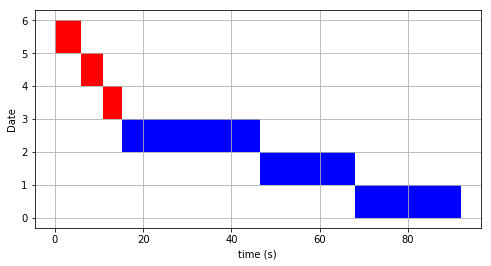

In [220]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
 
plan0T=np.mean(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000
plan1T=np.mean(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000
plan2T=np.mean(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000
# Rainfall data - 2nd day of the month for plotting broken horizontal bar chart

yrange = (5,1)
xranges = [(0,plan0T)]
plt.broken_barh(xranges, yrange, facecolors='red')
yrange = (4,1)
xranges = [(plan0T,plan1T)]
plt.broken_barh(xranges, yrange, facecolors='red')
yrange = (3,1)
xranges = [(plan0T+plan1T,plan2T)]
plt.broken_barh(xranges, yrange, facecolors='red')


plan_full = plan0T+plan1T+plan2T
exe0, exe1, exe2 = np.mean(np.divide(np.array(traj_dur_list_list, dtype=np.float), traj_freq), axis=0)

xranges = [(plan_full,exe0)]
yrange = (2,1)
plt.broken_barh(xranges, yrange, facecolors='blue')

xranges = [(plan_full+exe0,exe1)]
yrange = (1,1)
plt.broken_barh(xranges, yrange, facecolors='blue')
xranges = [(plan_full+exe0+exe1,exe2)]
yrange = (0,1)
plt.broken_barh(xranges, yrange, facecolors='blue')

 

# Give the title for the broken horizontal bar chart

 

# Give x axis label for the broken horizontal bar chart

plt.xlabel('time (s)')

 

# Give y axis label for for the broken horizontal bar chart

plt.ylabel('Date')

 
plt.grid()

plt.show()

In [222]:
plan_full

15.197400164604188

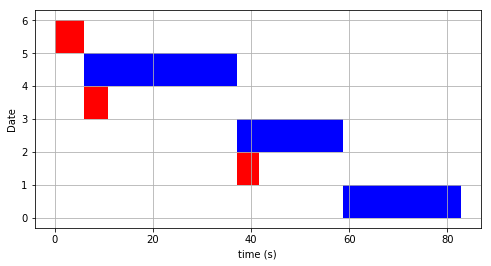

In [221]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
 
plan0T=np.mean(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000
plan1T=np.mean(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000
plan2T=np.mean(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000
# Rainfall data - 2nd day of the month for plotting broken horizontal bar chart

exe0, exe1, exe2 = np.mean(np.divide(np.array(traj_dur_list_list, dtype=np.float), traj_freq), axis=0)

yrange = (5,1)
xranges = [(0,plan0T)]
plt.broken_barh(xranges, yrange, facecolors='red')
yrange = (3,1)
xranges = [(plan0T,plan1T)]
plt.broken_barh(xranges, yrange, facecolors='red')
yrange = (1,1)
xranges = [(plan0T+exe0,plan2T)]
plt.broken_barh(xranges, yrange, facecolors='red')



xranges = [(plan0T,exe0)]
yrange = (4,1)
plt.broken_barh(xranges, yrange, facecolors='blue')

xranges = [(plan0T+exe0,exe1)]
yrange = (2,1)
plt.broken_barh(xranges, yrange, facecolors='blue')
xranges = [(plan0T+exe0+exe1,exe2)]
yrange = (0,1)
plt.broken_barh(xranges, yrange, facecolors='blue')

 

# Give the title for the broken horizontal bar chart

 

# Give x axis label for the broken horizontal bar chart

plt.xlabel('time (s)')

 

# Give y axis label for for the broken horizontal bar chart

plt.ylabel('Date')

 
plt.grid()

plt.show()

In [224]:
plan0T

5.964423441886902

In [183]:
print("total : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['one_plan'])[np.where(result_list)[0]])/1000))

print("plan0 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan0'])[np.where(result_list)[0]])/1000))
print("plan1 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan1'])[np.where(result_list)[0]])/1000))
print("plan2 : {} / {} / {} / {}".format(
                                        np.min(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.mean(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.median(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000,
                                        np.max(np.array(gtimer.timelist_dict['plan2'])[np.where(result_list)[0]])/1000))

total : 14.0552799702 / 17.2248143435 / 18.0531425476 / 20.2256550789
plan0 : 4.32055497169 / 5.96442344189 / 5.96379446983 / 7.31965589523
plan1 : 3.96429610252 / 4.88614721298 / 4.60508596897 / 5.99698090553
plan2 : 2.63792109489 / 4.34682950974 / 4.10673451424 / 6.33868217468


[[[<pkg.planning.task.interface.SearchNode at 0x7fb5804eb6d0>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb581285f10>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb58045c9d0>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb582d13750>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb581266c90>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb5804cf490>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb5804fabd0>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb5804cf210>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb581271d90>,
 [[<pkg.planning.task.interface.SearchNode at 0x7fb582bda950>,